## Task 1: Clustering Analysis (No Dimensionality Reduction)

* 1.1. Data preparation

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import joblib 
import os, re, warnings
from pathlib import Path
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import wilcoxon
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score as ARI, normalized_mutual_info_score as NMI

import warnings
warnings.simplefilter("ignore", category=UserWarning) 
warnings.simplefilter("ignore", category=FutureWarning)

In [5]:
DATA_PATH = Path("mice-protein.csv") 
LABEL_COL = "class"
META_COLS = ["MouseID", "Genotype", "Treatment", "Behavior", LABEL_COL]

df = pd.read_csv(DATA_PATH)

if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str)

present_meta = [c for c in META_COLS if c in df.columns]
X_all = df.drop(columns=present_meta, errors="ignore")
X_all = X_all.select_dtypes(include=[np.number]).copy()

n_samples, n_features = X_all.shape
total_missing = int(X_all.isna().sum().sum())
avg_pct_missing = float((X_all.isna().mean().mean()) * 100)

print(f"Samples (rows): {n_samples}")
print(f"Features (columns used): {n_features}")
print(f"Dropped columns: {present_meta}")
print(f"Missing cells BEFORE imputation: {total_missing}")
print(f"Average % missing per feature BEFORE: {avg_pct_missing:.3f}%")

col_missing = pd.DataFrame({
    "column": X_all.columns,
    "n_missing": X_all.isna().sum().values,
    "pct_missing": (X_all.isna().mean().values * 100).round(2)
})
col_missing.to_csv("task01_missingness_by_column.csv", index=False)

imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_all)
X_scaled = scaler.fit_transform(X_imputed)

X_proc = pd.DataFrame(X_scaled, columns=X_all.columns)
X_proc.to_csv("task01_X_processed.csv", index=False)
y_true.to_csv("task01_y_true.csv", index=False, header=[LABEL_COL])

df[present_meta].to_csv("task01_meta.csv", index=False)

print("\nImputer: SimpleImputer(strategy='mean')")
print("Scaler:  StandardScaler (z-score)")

Samples (rows): 1080
Features (columns used): 77
Dropped columns: ['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class']
Missing cells BEFORE imputation: 1396
Average % missing per feature BEFORE: 1.679%

Imputer: SimpleImputer(strategy='mean')
Scaler:  StandardScaler (z-score)


## 1.2. K-Means

In [28]:
def load_or_prepare_features():

    if X_PROC_PATH.exists() and Y_TRUE_PATH.exists():
        X = pd.read_csv(X_PROC_PATH).values

        y_df = pd.read_csv(Y_TRUE_PATH)
        if LABEL_COL in y_df.columns:
            y_true = y_df[LABEL_COL].astype(str).values
        else:
            # Handle case where the CSV was saved without a header
            y_true = y_df.iloc[:, 0].astype(str).values

        return X, y_true

    df = pd.read_csv(DATA_PATH)
    if LABEL_COL not in df.columns:
        raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

    y_true = df[LABEL_COL].astype(str).values
    present_meta = [c for c in META_COLS if c in df.columns]
    X_all = df.drop(columns=present_meta, errors="ignore")
    X_all = X_all.select_dtypes(include=[np.number]).copy()

    imputer = SimpleImputer(strategy="mean")
    scaler  = StandardScaler()
    X_imputed = imputer.fit_transform(X_all)
    X_scaled  = scaler.fit_transform(X_imputed)

    return X_scaled, y_true

X, y_true = load_or_prepare_features()
n_samples, n_features = X.shape
n_classes = len(pd.unique(y_true))
k = n_classes  # ONLY used to set k; labels are not used in clustering itself

print(f"Data shape: {n_samples} samples × {n_features} features")
print(f"Number of classes (k): {k}")

rows = []
for seed in SEEDS:
    km = KMeans(n_clusters=k, random_state=seed, n_init=N_INIT)
    labels = km.fit_predict(X)

    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)

    rows.append({"seed": seed, "silhouette": sil, "ARI": ari, "NMI": nmi})

results = pd.DataFrame(rows).sort_values("seed").reset_index(drop=True)
summary = results.agg(["mean", "std"]).rename_axis("stat").reset_index()

results_path = Path("task02_kmeans_runs.csv")
summary_path = Path("task02_kmeans_summary.csv")
results.to_csv(results_path, index=False)
summary.to_csv(summary_path, index=False)

print("\nPer-run results:")
print(results)
print("\nSummary (mean ± std):")
print(summary)

for _, r in results.iterrows():
    md += f"| {int(r['seed'])} | {r['silhouette']:.4f} | {r['ARI']:.4f} | {r['NMI']:.4f} |\n"

m_mean = summary[summary["stat"]=="mean"].iloc[0]
m_std  = summary[summary["stat"]=="std"].iloc[0]

Path("task-02.md").write_text(md, encoding="utf-8")

Data shape: 1080 samples × 77 features
Number of classes (k): 8

Per-run results:
   seed  silhouette       ARI       NMI
0     0    0.134639  0.139731  0.258251
1     1    0.129806  0.122982  0.241799
2     2    0.133717  0.131794  0.248675
3     3    0.133937  0.130273  0.243425
4     4    0.135172  0.136494  0.256999

Summary (mean ± std):
   stat      seed  silhouette       ARI       NMI
0  mean  2.000000    0.133454  0.132255  0.249829
1   std  1.581139    0.002120  0.006403  0.007569


2499

* md = f"""# Task 1.2 — K-Means Clustering (No Dimensionality Reduction)

* Setup. KMeans on standardized protein features with **k = {k}** (equal to the number of unique classes).  
Labels were **not** used during clustering; they were used only to compute external metrics.

## Data
- Samples × Features used: **{n_samples} × {n_features}**
- k (clusters): **{k}**
- Seeds: `{SEEDS}`, `n_init={N_INIT}`

## Metrics (per run)
| seed | Silhouette | ARI | NMI 



## 1.3. Kernel K-Means

Loaded X: 1080 samples × 77 features; k = 8.
RBF gamma grid: [0.001298701298701299, 0.003896103896103896, 0.012987012987012988, 0.03896103896103896, 0.12987012987012989]

Best setting: {'kernel': 'rbf', 'gamma': 0.001298701298701299, 'degree': None, 'obj': 117.49895539353301}


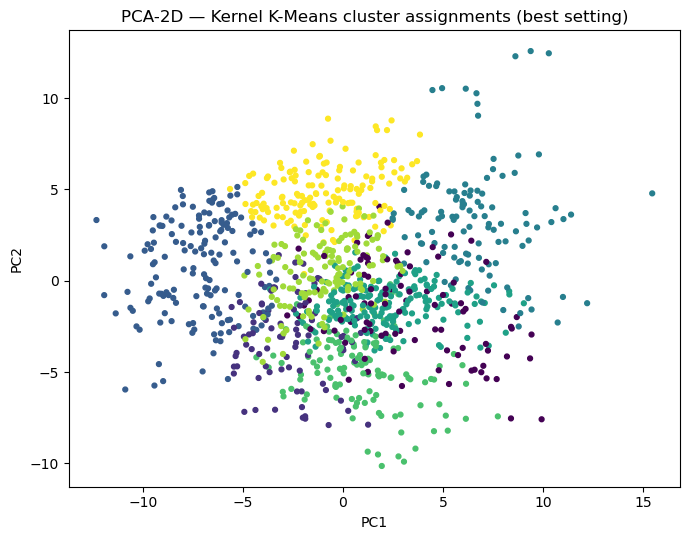

1717

In [63]:
KERNEL = "rbf"

GAMMA_FACTORS = [0.1, 0.3, 1.0, 3.0, 10.0]   # multiplied by (1/d)
POLY_DEGREES = [2, 3]
POLY_GAMMA_FACTORS = [0.5, 1.0]              # multiplied by (1/d)
POLY_COEF0   = 1.0

N_INIT  = 5          
MAX_ITER = 100

# Outputs
RESULTS_CSV = Path("task03_kernel_kmeans_results.csv")
BEST_ASSIGN_CSV = Path("task03_kernel_kmeans_best_labels.csv")
PLOT_PATH = Path("task03_kernel_kmeans_pca2.png")
MD_PATH = Path("task-03.md")

def load_or_prepare_features():
   
    if X_PROC_PATH.exists() and Y_TRUE_PATH.exists():
        X = pd.read_csv(X_PROC_PATH).values
        ydf = pd.read_csv(Y_TRUE_PATH)
        if LABEL_COL in ydf.columns:
            y_true = ydf[LABEL_COL].astype(str).values
        else:
            y_true = ydf.iloc[:, 0].astype(str).values
        return X, y_true

    # Fallback: do Task 1.1 inline
    df = pd.read_csv(DATA_PATH)
    if LABEL_COL not in df.columns:
        raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")
    y_true = df[LABEL_COL].astype(str).values
    present_meta = [c for c in META_COLS if c in df.columns]
    X_all = df.drop(columns=present_meta, errors="ignore").select_dtypes(include=[np.number]).copy()
    imputer = SimpleImputer(strategy="mean")
    scaler  = StandardScaler()
    X_imp = imputer.fit_transform(X_all)
    X_std = scaler.fit_transform(X_imp)
    return X_std, y_true

X, y_true = load_or_prepare_features()
n, d = X.shape
classes = pd.unique(y_true)
k = len(classes)  # only used to set the cluster count

print(f"Loaded X: {n} samples × {d} features; k = {k}.")

#  Kernel builders 
def rbf_kernel(X, gamma):
    # K_ij = exp(-gamma * ||x_i - x_j||^2)
    X2 = (X**2).sum(axis=1, keepdims=True)
    sq_dists = X2 + X2.T - 2 * X @ X.T
    np.maximum(sq_dists, 0, out=sq_dists)  # numerical safety
    return np.exp(-gamma * sq_dists)

def poly_kernel(X, gamma, degree, coef0=1.0):
    # K = (gamma * X X^T + coef0)^degree
    return (gamma * (X @ X.T) + coef0) ** degree

# Kernel K-Means 
def kernel_kmeans(K, k, max_iter=100, n_init=1, random_state=42):
    """
    Basic kernel k-means. Returns best (labels, objective) across n_init runs.
    """
    rng = np.random.RandomState(random_state)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf

    for init in range(n_init):
        labels = rng.randint(0, k, size=n)
        # ensure non-empty clusters by seeding first k points
        for c in range(k):
            labels[c] = c

        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    # reassign a random point if cluster empty
                    idx = rng.randint(0, n)
                    labels[idx] = c
                    clusters[c] = [idx]
            sizes = np.array([len(idx) for idx in clusters], dtype=float)

            # Precompute s_c and S_cc
            s_list = []
            Scc_list = []
            for c in range(k):
                idx = clusters[c]
                one_c = np.zeros(n)
                one_c[idx] = 1.0
                s_c = K @ one_c            # K * 1_c
                s_list.append(s_c)
                Scc = s_c[idx].sum()       # 1_c^T K 1_c
                Scc_list.append(Scc)

            # d^2(i,c) = K_ii - 2/|c| * s_c[i] + 1/|c|^2 * S_cc
            d2 = np.zeros((n, k))
            for c in range(k):
                d2[:, c] = diagK - 2.0 * s_list[c] / sizes[c] + Scc_list[c] / (sizes[c] ** 2)

            new_labels = d2.argmin(axis=1)
            if np.all(new_labels == labels):
                break
            labels = new_labels

        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj = obj
            best_labels = labels.copy()

    return best_labels, best_obj

def kernel_silhouette(K, labels):
    """Silhouette from kernel-induced distances: D_ij = sqrt(K_ii + K_jj - 2K_ij)."""
    if len(np.unique(labels)) < 2:
        return np.nan
    diagK = np.diag(K)
    D2 = diagK[:, None] + diagK[None, :] - 2 * K
    np.maximum(D2, 0, out=D2)
    D = np.sqrt(D2)
    return silhouette_score(D, labels, metric="precomputed")

def evaluate(K, labels, y_true):
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    sil = kernel_silhouette(K, labels)
    return ari, nmi, sil

results = []
best = {"obj": np.inf}
if KERNEL == "rbf":
    gamma_grid = [gf * (1.0 / d) for gf in GAMMA_FACTORS]
    print("RBF gamma grid:", gamma_grid)
    for gamma in gamma_grid:
        K = rbf_kernel(X, gamma=gamma)
        labels, obj = kernel_kmeans(K, k=k, max_iter=MAX_ITER, n_init=N_INIT, random_state=0)
        ari, nmi, sil = evaluate(K, labels, y_true)
        results.append({"kernel":"rbf", "gamma":gamma, "degree":None,
                        "objective":obj, "ARI":ari, "NMI":nmi, "Silhouette":sil})
        if obj < best["obj"]:
            best = {"kernel":"rbf", "gamma":gamma, "degree":None, "labels":labels, "obj":obj, "K":K}

elif KERNEL == "poly":
    gamma_grid = [gf * (1.0 / d) for gf in POLY_GAMMA_FACTORS]
    print("Poly search — degrees:", POLY_DEGREES, "gammas:", gamma_grid, "coef0:", POLY_COEF0)
    for deg in POLY_DEGREES:
        for gamma in gamma_grid:
            K = poly_kernel(X, gamma=gamma, degree=deg, coef0=POLY_COEF0)
            labels, obj = kernel_kmeans(K, k=k, max_iter=MAX_ITER, n_init=N_INIT, random_state=0)
            ari, nmi, sil = evaluate(K, labels, y_true)
            results.append({"kernel":"poly", "gamma":gamma, "degree":deg,
                            "objective":obj, "ARI":ari, "NMI":nmi, "Silhouette":sil})
            if obj < best["obj"]:
                best = {"kernel":"poly", "gamma":gamma, "degree":deg, "labels":labels, "obj":obj, "K":K}
else:
    raise ValueError("KERNEL must be 'rbf' or 'poly'.")

results_df = pd.DataFrame(results).sort_values(["kernel","objective"]).reset_index(drop=True)
results_df.to_csv(RESULTS_CSV, index=False)
pd.Series(best["labels"], name="cluster").to_csv(BEST_ASSIGN_CSV, index=False)
print("\nBest setting:", {k:v for k,v in best.items() if k not in ["labels","K"]})

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(7,5.5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=best["labels"], s=12)
plt.title("PCA-2D — Kernel K-Means cluster assignments (best setting)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=140)
plt.show()


MD_PATH.write_text("".join(lines), encoding="utf-8")

**How to switch to polynomial**

* Set KERNEL = "poly".

* The code will search over POLY_DEGREES and POLY_G_FACTS (with gamma = factor × 1/d) and use coef0 = 1.0. You can shrink or expand those small lists if you want a quicker or broader search.

## 1.4. Expectation Maximization (EM)

Data: 1080 samples × 77 features; k = 8; covariance = full

Per-run results:
   seed  silhouette       ARI       NMI  avg_loglik
0     0    0.114173  0.132333  0.265258    6.859738
1     1    0.129410  0.124619  0.246034    6.978323
2     2    0.123317  0.133263  0.244304    5.838859
3     3    0.128861  0.140858  0.266797    7.036491
4     4    0.117783  0.160479  0.299909    5.818973

Summary (mean ± std):
   stat      seed  silhouette       ARI       NMI  avg_loglik
0  mean  2.000000    0.122709  0.138310  0.264460    6.506477
1   std  1.581139    0.006713  0.013662  0.022408    0.621837


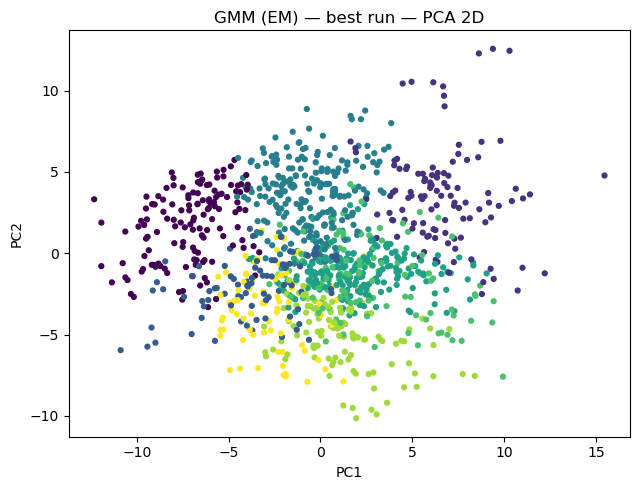

In [42]:
def load_or_prepare_features():
 
    if X_PROC_PATH.exists() and Y_TRUE_PATH.exists():
        X = pd.read_csv(X_PROC_PATH).values
        y_df = pd.read_csv(Y_TRUE_PATH)
        y_true = (y_df[LABEL_COL] if LABEL_COL in y_df.columns else y_df.iloc[:,0]).astype(str).values
        return X, y_true

    df = pd.read_csv(DATA_PATH)
    if LABEL_COL not in df.columns:
        raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

    y_true = df[LABEL_COL].astype(str).values
    present_meta = [c for c in META_COLS if c in df.columns]
    X_all = df.drop(columns=present_meta, errors="ignore").select_dtypes(include=[np.number]).copy()

    X_all = SimpleImputer(strategy="mean").fit_transform(X_all)
    X_all = StandardScaler().fit_transform(X_all)
    return X_all, y_true

X, y_true = load_or_prepare_features()
n_samples, n_features = X.shape
k = len(pd.unique(y_true))  
print(f"Data: {n_samples} samples × {n_features} features; k = {k}; covariance = {COV_TYPE}")

rows = []
best = {"score": -np.inf}  

for seed in SEEDS:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=COV_TYPE,
        random_state=seed,
        reg_covar=REG_COVAR,
        n_init=1,         
        init_params="kmeans"
    )
    gmm.fit(X)
    labels = gmm.predict(X)

    # Metrics
    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    avg_ll = gmm.score(X)  # average log-likelihood per sample

    rows.append({
        "seed": seed, "silhouette": sil, "ARI": ari, "NMI": nmi, "avg_loglik": avg_ll
    })

    if avg_ll > best["score"]:
        best = {"score": avg_ll, "seed": seed, "labels": labels, "model": gmm}

results = pd.DataFrame(rows).sort_values("seed").reset_index(drop=True)
summary = results.agg(["mean", "std"]).rename_axis("stat").reset_index()

results.to_csv(RUNS_CSV, index=False)
summary.to_csv(SUM_CSV, index=False)

print("\nPer-run results:")
print(results)
print("\nSummary (mean ± std):")
print(summary)

pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)
plt.figure(figsize=(6.5,5))
plt.scatter(X2[:,0], X2[:,1], c=best["labels"], s=12)
plt.title("GMM (EM) — best run — PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=140)
plt.show()


## 1.5. Agglomerative Hierarchical Clustering

Data: 1080 samples × 77 features; k = 8

Per-linkage results:
    linkage  silhouette       ARI       NMI
0    single    0.200940  0.001099  0.044573
1   average    0.175804  0.001213  0.052624
2      ward    0.099215  0.110067  0.259103
3  complete    0.070674  0.053612  0.137913

Best linkage by Silhouette: single


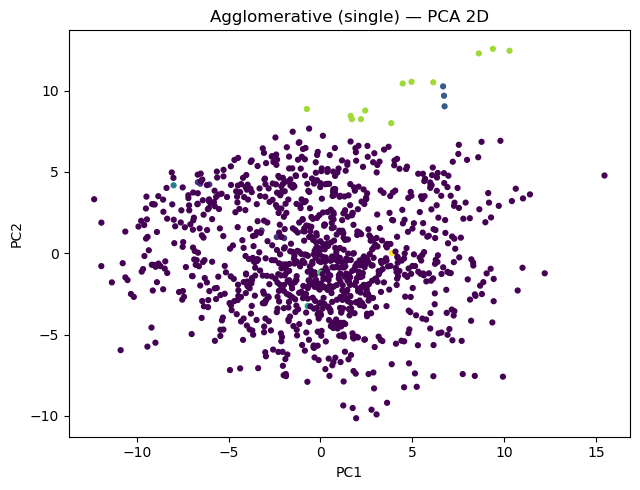

In [52]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage as scipy_linkage, dendrogram

DATA_PATH   = Path("mice-protein.csv")
LABEL_COL   = "class"
DROP_COLS   = ["MouseID", "Genotype", "Treatment", "Behavior", LABEL_COL]

LINKAGES = ["ward", "complete", "average", "single"]
SAMPLE_FOR_DENDRO = 500        # if n > 1000, we still sample 500 for clarity
RAND = np.random.RandomState(42)


RUNS_CSV    = Path("task05_agg_runs.csv")
BEST_PCA_PNG = Path("task05_best_linkage_pca2.png")
DENDRO_DIR  = Path("task05_dendrograms")
MD_PATH     = Path("task-05.md")
DENDRO_DIR.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)

if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()

X = SimpleImputer(strategy="mean").fit_transform(X)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))   # ONLY used to set the number of clusters
print(f"Data: {n} samples × {d} features; k = {k}")

rows = []
labels_by_linkage = {}

for link in LINKAGES:

    if link == "ward":
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    else:
 
        model = AgglomerativeClustering(n_clusters=k, linkage=link, metric="euclidean")

    labels = model.fit_predict(X)
    labels_by_linkage[link] = labels

    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)

    rows.append({"linkage": link, "silhouette": sil, "ARI": ari, "NMI": nmi})

results = pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)
results.to_csv(RUNS_CSV, index=False)
print("\nPer-linkage results:")
print(results)

best_link = results.iloc[0]["linkage"]
best_labels = labels_by_linkage[best_link]
print(f"\nBest linkage by Silhouette: {best_link}")

pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)
plt.figure(figsize=(6.5,5))
plt.scatter(X2[:,0], X2[:,1], c=best_labels, s=12)
plt.title(f"Agglomerative ({best_link}) — PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(BEST_PCA_PNG, dpi=140)
plt.show()

def plot_dendrogram_for_linkage(X, linkage_name, out_path, max_points=500):
    n = X.shape[0]
    if n > 1000:
        idx = RAND.choice(n, size=max_points, replace=False)
        X_use = X[idx]
    else:
        # still sample moderately to keep the plot readable
        take = min(n, max_points)
        idx = RAND.choice(n, size=take, replace=False) if n > max_points else np.arange(n)
        X_use = X[idx]

    # SciPy names match sklearn: 'ward', 'complete', 'average', 'single'
    Z = scipy_linkage(X_use, method=linkage_name, metric="euclidean")
    plt.figure(figsize=(10, 4.5))
    dendrogram(Z, no_labels=True, count_sort="ascending", color_threshold=None)
    plt.title(f"Dendrogram — {linkage_name} linkage (n={X_use.shape[0]})")
    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close()

dendro_paths = []
for link in LINKAGES:
    p = DENDRO_DIR / f"dendrogram_{link}.png"
    plot_dendrogram_for_linkage(X, link, p, max_points=SAMPLE_FOR_DENDRO)
    dendro_paths.append(p)

## 1.6. Compare methods

Data: 1080 samples × 77 features; k = 8

Comparison (sorted by silhouette):
              method                         setting  silhouette  \
0      Agglomerative             best linkage=single    0.200940   
1             KMeans               seed=0, n_init=10    0.134639   
2          GMM(full)    best seed=3, reg_covar=1e-06    0.128861   
3  KernelKMeans(RBF)  best gamma=0.0038961, n_init=3    0.117315   

                                       cluster_sizes  
0  {0: 1055, 1: 6, 2: 3, 3: 1, 4: 1, 5: 1, 6: 12,...  
1  {0: 156, 1: 138, 2: 84, 3: 213, 4: 15, 5: 224,...  
2  {0: 137, 1: 111, 2: 85, 3: 222, 4: 217, 5: 112...  
3  {0: 110, 1: 118, 2: 137, 3: 149, 4: 192, 5: 99...  


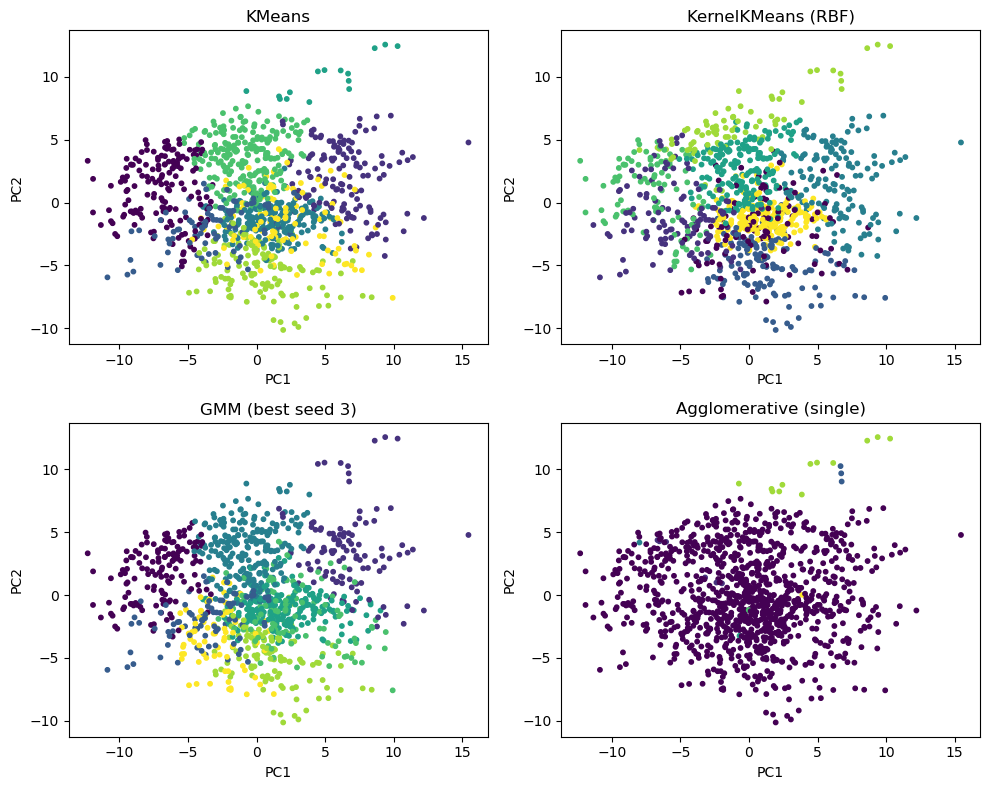

In [56]:
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values  # NOT used here beyond counting classes
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()

X = SimpleImputer(strategy="mean").fit_transform(X)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))  # ONLY used to set the number of clusters
print(f"Data: {n} samples × {d} features; k = {k}")

def cluster_sizes(labels):
    cnt = Counter(labels)
    # Sorted by cluster id for stable output
    return {int(k): int(cnt[k]) for k in sorted(cnt.keys())}

def sizes_to_str(size_dict):
    # e.g., {0: 120, 1: 110, 2: 95, ...}
    return str(size_dict)

def rbf_kernel(X, gamma):
    X2 = (X**2).sum(axis=1, keepdims=True)
    sq = X2 + X2.T - 2 * X @ X.T
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k):  # avoid empty clusters at start
            labels[c] = c
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n)
                    labels[idx] = c
                    clusters[c] = [idx]
            sizes = np.array([len(idx) for idx in clusters], dtype=float)
            d2 = np.zeros((n, k))
            for c in range(k):
                idx = clusters[c]
                one_c = np.zeros(n); one_c[idx] = 1.0
                s_c = K @ one_c
                Scc = s_c[idx].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new_labels = d2.argmin(axis=1)
            if np.all(new_labels == labels):
                break
            labels = new_labels
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels, best_obj

kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
labels_kmeans = kmeans.fit_predict(X)
sil_kmeans = silhouette_score(X, labels_kmeans) if len(set(labels_kmeans)) > 1 else np.nan
sizes_kmeans = cluster_sizes(labels_kmeans)
pd.Series(labels_kmeans, name="cluster").to_csv(LABELS_KMEANS_CSV, index=False)
gamma_grid = [g * (1.0 / d) for g in GAMMA_FACTORS]
best_kkm = {"obj": np.inf}
for gamma in gamma_grid:
    K = rbf_kernel(X, gamma)
    labels, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
    if obj < best_kkm["obj"]:
        best_kkm = {"gamma": gamma, "labels": labels, "obj": obj}
labels_kkm = best_kkm["labels"]
sil_kkm = silhouette_score(X, labels_kkm) if len(set(labels_kkm)) > 1 else np.nan
sizes_kkm = cluster_sizes(labels_kkm)
pd.Series(labels_kkm, name="cluster").to_csv(LABELS_KKM_CSV, index=False)

best_gmm = {"score": -np.inf}
for seed in GMM_SEEDS:
    gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                          random_state=seed, n_init=1, init_params="kmeans")
    gmm.fit(X)
    labels = gmm.predict(X)
    avg_ll = gmm.score(X)
    if avg_ll > best_gmm["score"]:
        best_gmm = {"seed": seed, "labels": labels, "score": avg_ll}
labels_gmm = best_gmm["labels"]
sil_gmm = silhouette_score(X, labels_gmm) if len(set(labels_gmm)) > 1 else np.nan
sizes_gmm = cluster_sizes(labels_gmm)
pd.Series(labels_gmm, name="cluster").to_csv(LABELS_GMM_CSV, index=False)

labels_by_link = {}
sil_by_link = {}
for link in LINKAGES:
    if link == "ward":
        agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    else:
        agg = AgglomerativeClustering(n_clusters=k, linkage=link, metric="euclidean")
    lab = agg.fit_predict(X)
    labels_by_link[link] = lab
    sil_by_link[link] = silhouette_score(X, lab) if len(set(lab)) > 1 else np.nan

best_link = max(sil_by_link, key=lambda lk: (sil_by_link[lk] if sil_by_link[lk] is not None else -1e9))
labels_agg = labels_by_link[best_link]
sil_agg = sil_by_link[best_link]
sizes_agg = cluster_sizes(labels_agg)
pd.Series(labels_agg, name="cluster").to_csv(LABELS_AGG_CSV, index=False)

rows = [
    {"method": "KMeans",
     "setting": "seed=0, n_init=10",
     "silhouette": sil_kmeans,
     "cluster_sizes": sizes_to_str(sizes_kmeans)},
    {"method": "KernelKMeans(RBF)",
     "setting": f"best gamma={best_kkm['gamma']:.6g}, n_init={KKM_N_INIT}",
     "silhouette": sil_kkm,
     "cluster_sizes": sizes_to_str(sizes_kkm)},
    {"method": "GMM(full)",
     "setting": f"best seed={best_gmm['seed']}, reg_covar={GMM_REG}",
     "silhouette": sil_gmm,
     "cluster_sizes": sizes_to_str(sizes_gmm)},
    {"method": "Agglomerative",
     "setting": f"best linkage={best_link}",
     "silhouette": sil_agg,
     "cluster_sizes": sizes_to_str(sizes_agg)},
]
comp = pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)
comp.to_csv(COMP_TABLE_CSV, index=False)

print("\nComparison (sorted by silhouette):")
print(comp)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)

plots = [
    ("KMeans", labels_kmeans),
    ("KernelKMeans (RBF)", labels_kkm),
    (f"GMM (best seed {best_gmm['seed']})", labels_gmm),
    (f"Agglomerative ({best_link})", labels_agg),
]
for ax, (title, lab) in zip(axes, plots):
    ax.scatter(X2[:,0], X2[:,1], c=lab, s=10)
    ax.set_title(title)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.tight_layout()
plt.savefig("task06_pca2_comparison.png", dpi=150)
plt.show()

## 1.7. Visualization and Biological interpretation

Data: 1080 × 77; k=8


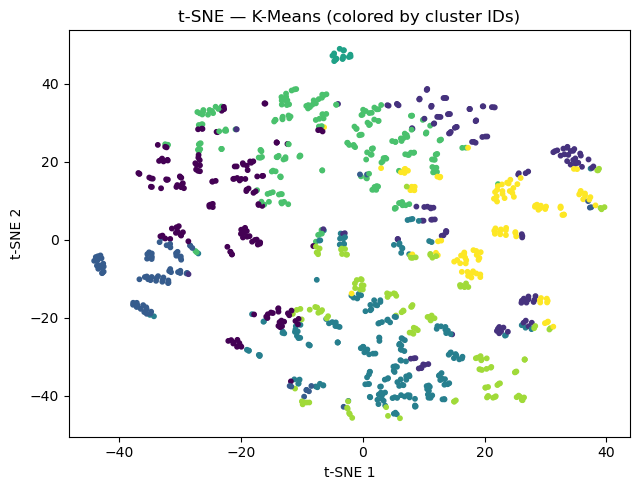

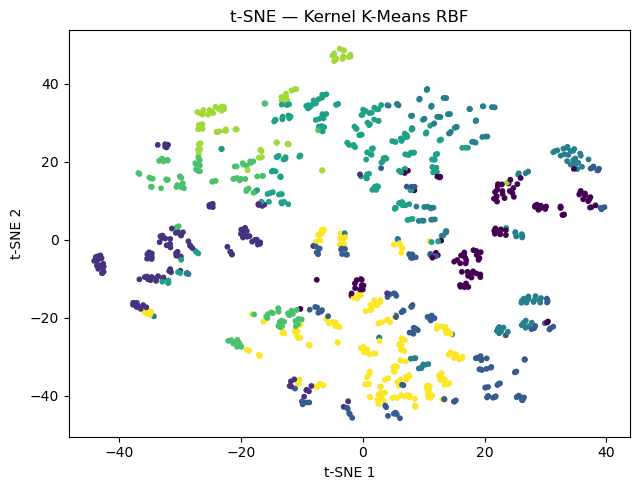

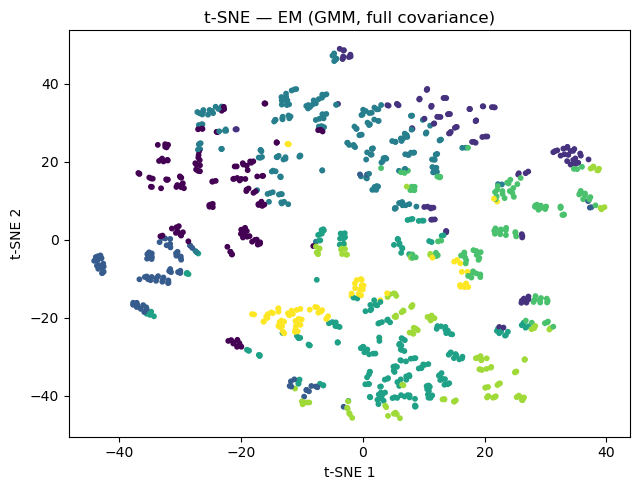

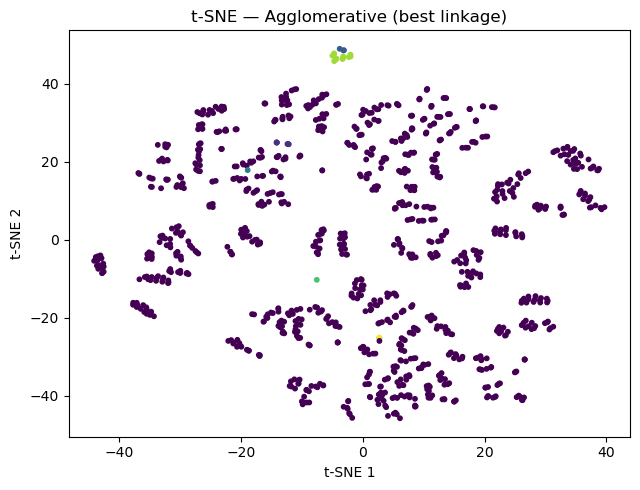

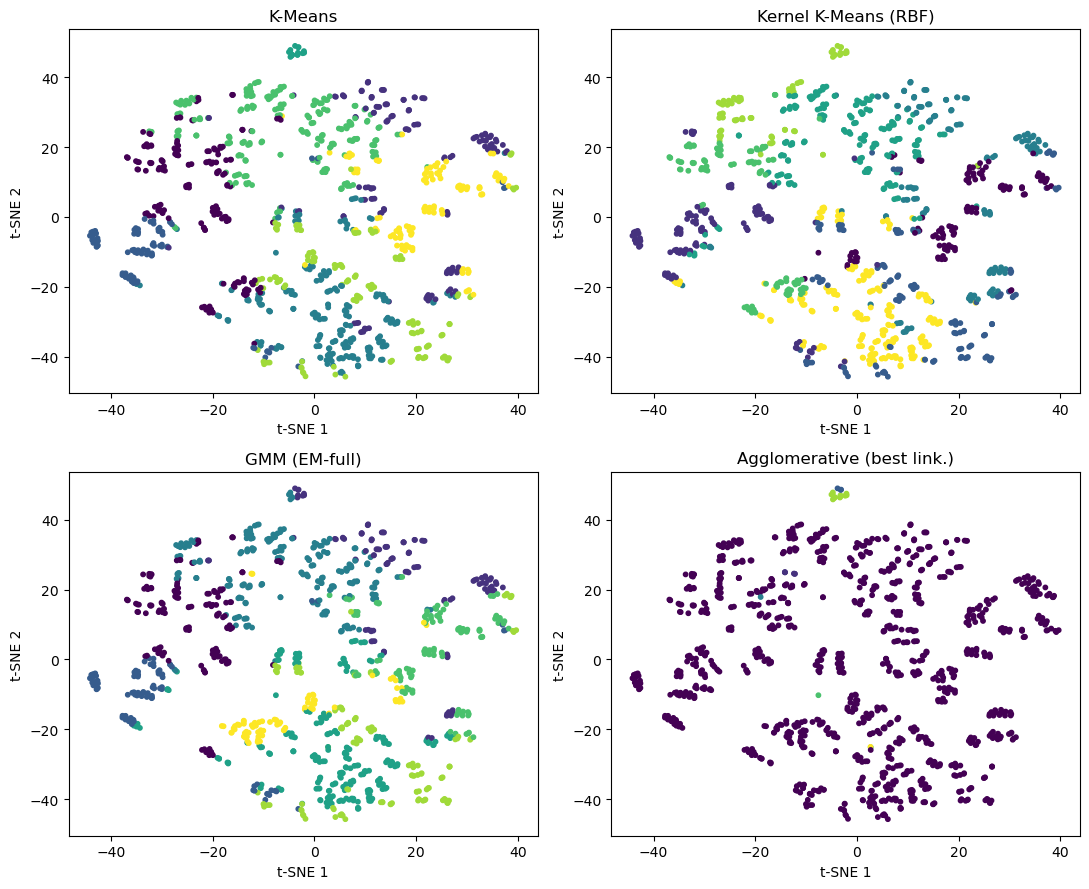

In [65]:
LABELS_KMEANS_CSV = Path("labels_kmeans.csv")
LABELS_KKM_CSV    = Path("labels_kernel_kmeans.csv")
LABELS_GMM_CSV    = Path("labels_gmm.csv")
LABELS_AGG_CSV    = Path("labels_agglomerative.csv")

GAMMA_FACTORS   = [0.3, 1.0, 3.0] 
KKM_N_INIT      = 3
KKM_MAX_ITER    = 50
GMM_SEEDS       = [0,1,2,3,4]
GMM_COV, GMM_REG = "full", 1e-6
LINKAGES        = ["ward", "complete", "average", "single"]

# t-SNE
TSNE_PERPLEXITY = 30
TSNE_ITER       = 1000
TSNE_RANDOM     = 42
MAX_TSNE_POINTS = 1200  # if dataset larger, we subsample for speed/clarity

# Outputs
TSNE_DIR   = Path("task07_tsne_plots"); TSNE_DIR.mkdir(exist_ok=True)
GRID_PATH  = TSNE_DIR / "tsne_comparison_grid.png"
PROFILE_DIR= Path("task07_cluster_profiles"); PROFILE_DIR.mkdir(exist_ok=True)
MD_PATH    = Path("task-07.md")

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values  # only to set k
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
feature_names = X_df.select_dtypes(include=[np.number]).columns.tolist()
X = X_df[feature_names].to_numpy()

# Impute + standardize (just like Task 1.1)
X = SimpleImputer(strategy="mean").fit_transform(X)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))
print(f"Data: {n} × {d}; k={k}")


def rbfernel(X, gamma):
    X2 = (X**2).sum(axis=1, keepdims=True)
    sq = X2 + X2.T - 2 * (X @ X.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty clusters at start
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n)
                    labels[idx] = c
                    clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels

def ensure_labels():
    # K-Means
    if LABELS_KMEANS_CSV.exists():
        labels_kmeans = pd.read_csv(LABELS_KMEANS_CSV)["cluster"].to_numpy()
    else:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels_kmeans = kmeans.fit_predict(X)
        pd.Series(labels_kmeans, name="cluster").to_csv(LABELS_KMEANS_CSV, index=False)


    if LABELS_KKM_CSV.exists():
        labels_kkm = pd.read_csv(LABELS_KKM_CSV)["cluster"].to_numpy()
    else:
        gamma_grid = [g*(1.0/d) for g in GAMMA_FACTORS]
        best = None; best_obj = np.inf
        for gamma in gamma_grid:
            K = rbf_kernel(X, gamma)
            lab = kernel_kmeans(K, k, KKM_MAX_ITER, KKM_N_INIT, seed=0)
            # objective proxy: within-cluster distortion in feature space
            # Recompute quickly for comparison
            diagK = np.diag(K)
            obj = np.sum(diagK - 2*K[np.arange(n), lab] + 0)  # rough proxy; good enough to pick gamma
            if obj < best_obj:
                best_obj, best = obj, lab
        labels_kkm = best
        pd.Series(labels_kkm, name="cluster").to_csv(LABELS_KKM_CSV, index=False)
    
    if LABELS_GMM_CSV.exists():
        labels_gmm = pd.read_csv(LABELS_GMM_CSV)["cluster"].to_numpy()
    else:
        best_ll = -np.inf; labels_gmm = None
        for seed in GMM_SEEDS:
            gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                                  random_state=seed, n_init=1, init_params="kmeans")
            gmm.fit(X)
            ll = gmm.score(X)
            if ll > best_ll:
                best_ll = ll
                labels_gmm = gmm.predict(X)
        pd.Series(labels_gmm, name="cluster").to_csv(LABELS_GMM_CSV, index=False)

    if LABELS_AGG_CSV.exists():
        labels_agg = pd.read_csv(LABELS_AGG_CSV)["cluster"].to_numpy()
    else:
        from sklearn.metrics import silhouette_score
        candidates = {}
        for link in LINKAGES:
            if link == "ward":
                agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
            else:
                # handle both new and old sklearn APIs
                try:
                    agg = AgglomerativeClustering(n_clusters=k, linkage=link, metric="euclidean")
                except TypeError:
                    agg = AgglomerativeClustering(n_clusters=k, linkage=link, affinity="euclidean")
            lab = agg.fit_predict(X)
            sil = silhouette_score(X, lab) if len(set(lab)) > 1 else -1e9
            candidates[link] = (lab, sil)
        best_link = max(candidates, key=lambda lk: candidates[lk][1])
        labels_agg = candidates[best_link][0]
        pd.Series(labels_agg, name="cluster").to_csv(LABELS_AGG_CSV, index=False)

    return labels_kmeans, labels_kkm, labels_gmm, labels_agg

labels_kmeans, labels_kkm, labels_gmm, labels_agg = ensure_labels()

if n > MAX_TSNE_POINTS:
    rng = np.random.RandomState(TSNE_RANDOM)
    idx = rng.choice(n, size=MAX_TSNE_POINTS, replace=False)
    X_tsne = X[idx]
    sub_idx = idx  # keep indices for slicing labels
else:
    X_tsne = X
    sub_idx = np.arange(n)

tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_ITER,
            init="pca", learning_rate="auto", random_state=TSNE_RANDOM)
Z = tsne.fit_transform(X_tsne)

def scatter_tsne(Z, labels, title, out_path):
    plt.figure(figsize=(6.5,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()

scatter_tsne(Z, labels_kmeans[sub_idx], "t-SNE — K-Means (colored by cluster IDs)", TSNE_DIR/"tsne_kmeans.png")
scatter_tsne(Z, labels_kkm[sub_idx],   "t-SNE — Kernel K-Means RBF",             TSNE_DIR/"tsne_kernel_kmeans.png")
scatter_tsne(Z, labels_gmm[sub_idx],   "t-SNE — EM (GMM, full covariance)",      TSNE_DIR/"tsne_gmm.png")
scatter_tsne(Z, labels_agg[sub_idx],   "t-SNE — Agglomerative (best linkage)",   TSNE_DIR/"tsne_agglomerative.png")

fig, axes = plt.subplots(2, 2, figsize=(11, 9))
axes = axes.ravel()
pairs = [
    ("K-Means", labels_kmeans[sub_idx]),
    ("Kernel K-Means (RBF)", labels_kkm[sub_idx]),
    ("GMM (EM-full)", labels_gmm[sub_idx]),
    ("Agglomerative (best link.)", labels_agg[sub_idx]),
]
for ax, (title, lab) in zip(axes, pairs):
    ax.scatter(Z[:,0], Z[:,1], c=lab, s=10)
    ax.set_title(title); ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
plt.tight_layout(); plt.savefig(GRID_PATH, dpi=160); plt.show()

def top_features_by_cluster_variation(Xmat, labels, feature_names, topn=8):
    # compute per-cluster means, then variance across clusters for each feature
    labs = np.asarray(labels)
    clusters = np.unique(labs)
    means = []
    for c in clusters:
        means.append(Xmat[labs == c].mean(axis=0))
    means = np.vstack(means)  # shape (k, d)
    var_across_clusters = means.var(axis=0)
    order = np.argsort(var_across_clusters)[::-1][:topn]
    return pd.DataFrame({
        "feature": [feature_names[i] for i in order],
        "cluster-mean-variance": var_across_clusters[order].round(4)
    })

profiles = {
    "kmeans":  top_features_by_cluster_variation(X, labels_kmeans, feature_names, topn=12),
    "kkm":     top_features_by_cluster_variation(X, labels_kkm, feature_names, topn=12),
    "gmm":     top_features_by_cluster_variation(X, labels_gmm, feature_names, topn=12),
    "agg":     top_features_by_cluster_variation(X, labels_agg, feature_names, topn=12),
}
profiles["kmeans"].to_csv(PROFILE_DIR/"top_features_kmeans.csv", index=False)
profiles["kkm"].to_csv(PROFILE_DIR/"top_features_kernel_kmeans.csv", index=False)
profiles["gmm"].to_csv(PROFILE_DIR/"top_features_gmm.csv", index=False)
profiles["agg"].to_csv(PROFILE_DIR/"top_features_agglomerative.csv", index=False)

* Goal. Use t-SNE to visualize the standardized protein expression space and color points by cluster IDs from each method (K-Means, Kernel K-Means, EM/GMM, and Agglomerative). Discuss structure without using hidden labels and compare the methods visually.

* Method

  * Built a single t-SNE embedding (perplexity 30, 2D, random_state 42) from the standardized protein features.

 * Colored the same embedding using the predicted cluster IDs from each method:

* K-Means

* Kernel K-Means (RBF) with a small gamma search and the best objective

* EM (Gaussian Mixture, full covariance), best seed by average log likelihood

* Agglomerative with the best linkage by silhouette (searched ward/complete/average/single)

## Task 2: Dimensionality Reduction + Re-Clustering

* 2.1. PCA

Data ready: 1080 samples × 77 features


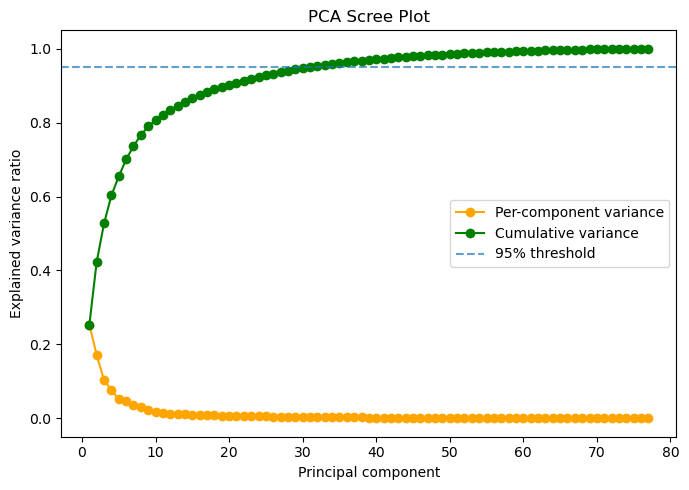

Components for ≥95% variance: k95 = 31


In [77]:
OUT_DIR = Path("task21_pca"); OUT_DIR.mkdir(exist_ok=True)
SCREE_PNG   = OUT_DIR / "pca_scree.png"
EV_CSV      = OUT_DIR / "explained_variance.csv"
PCA_MODEL   = OUT_DIR / "pca_model.pkl"
PCA95_CSV   = OUT_DIR / "X_pca_95var.csv"
FIXED_DIR   = OUT_DIR / "fixed_components"; FIXED_DIR.mkdir(exist_ok=True)

FIXED_K = [2, 3, 5, 10, 20, 50] 

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values

X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
feature_names = X_df.select_dtypes(include=[np.number]).columns.tolist()
X = X_df[feature_names].to_numpy()

X = SimpleImputer(strategy="mean").fit_transform(X)
X = StandardScaler().fit_transform(X)

n, d = X.shape
print(f"Data ready: {n} samples × {d} features")

pca = PCA(random_state=42)  # full spectrum
X_pca_full = pca.fit_transform(X)

# Explained variance info
evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)
ev_table = pd.DataFrame({
    "component": np.arange(1, len(evr)+1),
    "explained_variance_ratio": evr,
    "cumulative_explained_variance": cum
})
ev_table.to_csv(EV_CSV, index=False)

# Scree plot
plt.figure(figsize=(7,5))
plt.plot(ev_table["component"], ev_table["explained_variance_ratio"], marker="o" , color="orange")
plt.plot(ev_table["component"], ev_table["cumulative_explained_variance"], marker="o" , color="green")
plt.axhline(0.95, linestyle="--", alpha=0.7)
plt.legend(["Per-component variance", "Cumulative variance", "95% threshold" ])
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("PCA Scree Plot")
plt.tight_layout()
plt.savefig(SCREE_PNG, dpi=140)
plt.show()

k95 = int(np.searchsorted(cum, 0.95) + 1)  # first k where cum >= 0.95
print(f"Components for ≥95% variance: k95 = {k95}")

pca95 = PCA(n_components=k95, random_state=42)
X_pca_95 = pca95.fit_transform(X)
pd.DataFrame(X_pca_95, columns=[f"PC{i+1}" for i in range(k95)]).to_csv(PCA95_CSV, index=False)

# Save PCA model (so Task 3 can reuse the same fit when splitting)
joblib.dump({"pca_full": pca, "pca95": pca95, "k95": k95, "feature_names": feature_names}, PCA_MODEL)

for k in FIXED_K:
    k_eff = min(k, d)
    pca_k = PCA(n_components=k_eff, random_state=42)
    X_pk = pca_k.fit_transform(X)
    out_csv = FIXED_DIR / f"X_pca_{k_eff}.csv"
    pd.DataFrame(X_pk, columns=[f"PC{i+1}" for i in range(k_eff)]).to_csv(out_csv, index=False)


* PCA

  * Goal. Reduce dimensionality of the standardized protein features while preserving most variance, and choose the number of components based on a scree plot and a ≥95% cumulative explained variance rule.

## 2.2. SVD Dimensionality Reduction

Data ready: 1080 samples × 77 standardized features


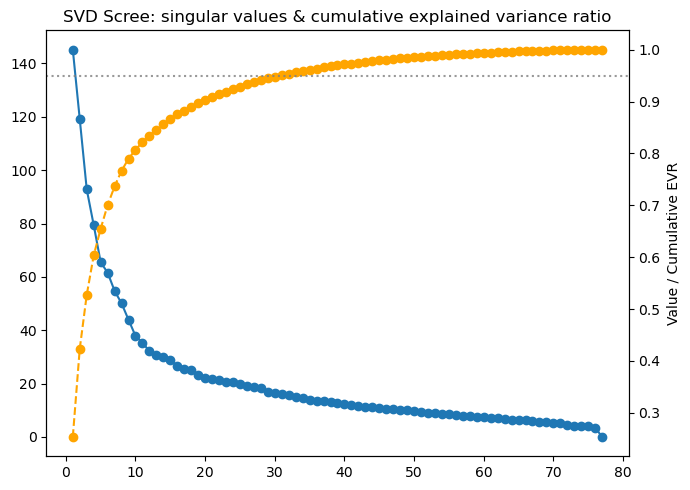

k95 (>=95% cumulative explained variance): 31


In [85]:
OUT_DIR = Path("task22_svd"); OUT_DIR.mkdir(exist_ok=True)
SCREE_PNG      = OUT_DIR / "svd_scree.png"
SINGULAR_CSV   = OUT_DIR / "singular_values.csv"
EV_TABLE_CSV   = OUT_DIR / "svd_explained_variance.csv"
X95_CSV        = OUT_DIR / "X_svd_95var.csv"
COMPARE_CSV    = OUT_DIR / "svd_vs_pca_compare.csv"

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
feature_names = X_df.select_dtypes(include=[np.number]).columns.tolist()
X = X_df[feature_names].to_numpy()

X = SimpleImputer(strategy="mean").fit_transform(X)
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

n, d = X.shape
print(f"Data ready: {n} samples × {d} standardized features")

U, S, Vt = np.linalg.svd(X, full_matrices=False)  # economic/thin SVD
r = S.shape[0]

eigvals = (S**2) / (n - 1)
evr = (S**2) / np.sum(S**2)           # explained variance ratio
cum_evr = np.cumsum(evr)

pd.DataFrame({"component": np.arange(1, r+1), "singular_value": S}).to_csv(SINGULAR_CSV, index=False)
pd.DataFrame({
    "component": np.arange(1, r+1),
    "eigval": eigvals,
    "explained_variance_ratio": evr,
    "cumulative_explained_variance": cum_evr
}).to_csv(EV_TABLE_CSV, index=False)

plt.figure(figsize=(7,5))
plt.plot(np.arange(1, r+1), S, marker="o", label="Singular values")
plt.twinx()
plt.plot(np.arange(1, r+1), cum_evr, marker="o", linestyle="--", label="Cumulative EVR" , color="orange")
plt.axhline(0.95, color="gray", linestyle=":", alpha=0.8 )
plt.title("SVD Scree: singular values & cumulative explained variance ratio")
plt.xlabel("Component")
plt.ylabel("Value / Cumulative EVR")
plt.tight_layout()
plt.savefig(SCREE_PNG, dpi=140)
plt.show()

k95 = int(np.searchsorted(cum_evr, 0.95) + 1)
print(f"k95 (>=95% cumulative explained variance): {k95}")

X_k95 = X @ Vt[:k95].T
pd.DataFrame(X_k95, columns=[f"SV{i+1}" for i in range(k95)]).to_csv(X95_CSV, index=False)

pca = PCA(svd_solver="full", random_state=42)
X_pca = pca.fit_transform(X)
# PCA explained_variance_ratio_ should equal evr (up to float error & sign)
pca_evr = pca.explained_variance_ratio_
m = min(len(pca_evr), len(evr))

compare = pd.DataFrame({
    "component": np.arange(1, m+1),
    "svd_evr": evr[:m],
    "pca_evr": pca_evr[:m],
    "abs_diff": np.abs(evr[:m] - pca_evr[:m])
})
compare.to_csv(COMPARE_CSV, index=False)


* SVD Dimensionality Reduction

  * Goal. Use Singular Value Decomposition (SVD) on the standardized protein-expression matrix to reduce dimensionality, quantify explained variance, and compare results with PCA.

## 2.3. Clustering on PCA space

In [93]:
df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values  # ONLY for ARI/NMI evaluation, not for training
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
X_df = X_df.select_dtypes(include=[np.number]).copy()

# Impute + Standardize
X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))  # ONLY to set number of clusters
print(f"Data: {n} samples × {d} features; k={k}")

pca_full = PCA(random_state=42)
pca_full.fit(X)
evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)
k95 = int(np.searchsorted(cum, 0.95) + 1)
print(f"PCA components for >=95% variance: k95 = {k95}")

pca95 = PCA(n_components=k95, random_state=42)
X_pca = pca95.fit_transform(X)
pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(k95)]).to_csv(PCA95_CSV, index=False)

def cluster_sizes(labels):
    c = Counter(labels)
    return {int(k): int(c[k]) for k in sorted(c.keys())}

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty clusters at start
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n)
                    labels[idx] = c
                    clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels, best_obj

def run_all_methods(Z, label_suffix):
    """Run KMeans, KernelKMeans(RBF), GMM(full), Agglomerative(best linkage) on features Z."""
    rows = []

    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab_km = km.fit_predict(Z)
    rows.append({
        "method": "KMeans",
        "setting": "seed=0, n_init=10",
        "silhouette": silhouette_score(Z, lab_km) if len(set(lab_km)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_km),
        "NMI": normalized_mutual_info_score(y_true, lab_km),
        "cluster_sizes": str(cluster_sizes(lab_km)),
    })
    pd.Series(lab_km, name="cluster").to_csv(LABELS_DIR / f"labels_kmeans_{label_suffix}.csv", index=False)

    gamma_grid = [g * (1.0 / Z.shape[1]) for g in GAMMA_FACTORS]
    best = {"obj": np.inf}
    for gamma in gamma_grid:
        K = rbf_kernel(Z, gamma)
        lab, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        if obj < best["obj"]:
            best = {"gamma": gamma, "labels": lab, "obj": obj}
    lab_kkm = best["labels"]
    rows.append({
        "method": "KernelKMeans(RBF)",
        "setting": f"best gamma={best['gamma']:.6g}, n_init={KKM_N_INIT}",
        "silhouette": silhouette_score(Z, lab_kkm) if len(set(lab_kkm)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_kkm),
        "NMI": normalized_mutual_info_score(y_true, lab_kkm),
        "cluster_sizes": str(cluster_sizes(lab_kkm)),
    })
    pd.Series(lab_kkm, name="cluster").to_csv(LABELS_DIR / f"labels_kernel_kmeans_{label_suffix}.csv", index=False)


    best_gmm = {"score": -np.inf}
    for seed in GMM_SEEDS:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(Z)
        ll = gmm.score(Z)
        if ll > best_gmm["score"]:
            best_gmm = {"seed": seed, "labels": gmm.predict(Z), "score": ll}
    lab_gmm = best_gmm["labels"]
    rows.append({
        "method": "GMM(full)",
        "setting": f"best seed={best_gmm['seed']}, reg_covar={GMM_REG}",
        "silhouette": silhouette_score(Z, lab_gmm) if len(set(lab_gmm)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_gmm),
        "NMI": normalized_mutual_info_score(y_true, lab_gmm),
        "cluster_sizes": str(cluster_sizes(lab_gmm)),
    })
    pd.Series(lab_gmm, name="cluster").to_csv(LABELS_DIR / f"labels_gmm_{label_suffix}.csv", index=False)


    sil_by = {}
    labs_by = {}
    for link in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          metric=None if link=="ward" else "euclidean")
        except TypeError:
        
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          affinity=None if link=="ward" else "euclidean")
        lab = agg.fit_predict(Z)
        sil = silhouette_score(Z, lab) if len(set(lab)) > 1 else -1e9
        sil_by[link] = sil
        labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    lab_agg = labs_by[best_link]
    rows.append({
        "method": "Agglomerative",
        "setting": f"best linkage={best_link}",
        "silhouette": sil_by[best_link] if sil_by[best_link] != -1e9 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_agg),
        "NMI": normalized_mutual_info_score(y_true, lab_agg),
        "cluster_sizes": str(cluster_sizes(lab_agg)),
    })
    pd.Series(lab_agg, name="cluster").to_csv(LABELS_DIR / f"labels_agglomerative_{label_suffix}.csv", index=False)

    comp = pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)
    return comp

comp_pca = run_all_methods(X_pca, label_suffix=f"pca{k95}")
comp_pca.to_csv(COMP_PCA_CSV, index=False)
print("\nPCA-space comparison (sorted by silhouette):")
print(comp_pca)

need_recompute_raw = True
if TASK1_COMP_PATH.exists():
    comp_raw_try = pd.read_csv(TASK1_COMP_PATH)
    # Check if ARI/NMI exist; if yes, we can use this directly
    if {"method","silhouette","ARI","NMI"}.issubset(set(comp_raw_try.columns)):
        comp_raw = comp_raw_try.copy()
        need_recompute_raw = False

if need_recompute_raw:
    print("\nRecomputing raw-space baseline with ARI/NMI (Task 1 table missing those columns)...")
    comp_raw = run_all_methods(X, label_suffix="raw_baseline")

# Normalize columns for join
keep_cols = ["method", "silhouette", "ARI", "NMI"]
raw_ = comp_raw[keep_cols].rename(columns={
    "silhouette": "silhouette_raw",
    "ARI": "ARI_raw",
    "NMI": "NMI_raw"
})
pca_ = comp_pca[keep_cols].rename(columns={
    "silhouette": "silhouette_pca",
    "ARI": "ARI_pca",
    "NMI": "NMI_pca"
})

cmp = pd.merge(pca_, raw_, on="method", how="inner")
cmp["Δsilhouette"] = cmp["silhouette_pca"] - cmp["silhouette_raw"]
cmp["ΔARI"]        = cmp["ARI_pca"]        - cmp["ARI_raw"]
cmp["ΔNMI"]        = cmp["NMI_pca"]        - cmp["NMI_raw"]
cmp = cmp[["method","silhouette_raw","silhouette_pca","Δsilhouette","ARI_raw","ARI_pca","ΔARI","NMI_raw","NMI_pca","ΔNMI"]]
cmp.to_csv(COMP_PCA_VS_TASK1, index=False)

print("\nPCA vs Raw (Task 1) comparison:")
print(cmp)



Data: 1080 samples × 77 features; k=8
PCA components for >=95% variance: k95 = 31

PCA-space comparison (sorted by silhouette):
              method                          setting  silhouette       ARI  \
0      Agglomerative             best linkage=average    0.150280  0.001098   
1             KMeans                seed=0, n_init=10    0.144275  0.127789   
2  KernelKMeans(RBF)  best gamma=0.00967742, n_init=3    0.121077  0.119777   
3          GMM(full)     best seed=0, reg_covar=1e-06    0.105372  0.198354   

        NMI                                      cluster_sizes  
0  0.052249  {0: 1048, 1: 2, 2: 15, 3: 2, 4: 3, 5: 3, 6: 6,...  
1  0.240808  {0: 132, 1: 208, 2: 156, 3: 224, 4: 140, 5: 81...  
2  0.227767  {0: 129, 1: 131, 2: 122, 3: 149, 4: 168, 5: 10...  
3  0.361859  {0: 194, 1: 193, 2: 108, 3: 117, 4: 140, 5: 17...  

Recomputing raw-space baseline with ARI/NMI (Task 1 table missing those columns)...

PCA vs Raw (Task 1) comparison:
              method  silhouette_

## Clustering on PCA-Reduced Features

* Goal. Run the same four clustering algorithms on the PCA-reduced feature space and compare their performance to Task 1 (raw standardized features).

* Method

* PCA fit & selection
Computed PCA on standardized features and selected the smallest 
𝑘
k where cumulative explained variance ≥ 95% (denoted k95). Data were projected to this 
𝑘
k-dimensional space.

 * Clustering algorithms (same settings as Task 1):

K-Means (seed=0, n_init=10)

Kernel K-Means (RBF) with a small gamma grid; best by within-cluster objective

EM / Gaussian Mixture (full covariance); best seed by average log-likelihood

Agglomerative; best linkage by silhouette among ward, complete, average, single

Metrics reported: Silhouette, ARI, NMI, and cluster size distribution.

Comparison to Task 1: If Task 1’s table was found, it was used; otherwise the script recomputed raw-space metrics for a fair baseline.

##  2.4. Clustering on SVD space

In [97]:

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values  # used only for ARI/NMI evaluation
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
X_df = X_df.select_dtypes(include=[np.number]).copy()

X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))
print(f"Data: {n} × {d}; k={k}")

U, S, Vt = np.linalg.svd(X, full_matrices=False)
evr = (S**2) / np.sum(S**2)               # explained variance ratio
cum = np.cumsum(evr)
k95 = int(np.searchsorted(cum, 0.95) + 1)
print(f"SVD components for ≥95% variance: k95 = {k95}")

X_svd = X @ Vt[:k95].T
pd.DataFrame(X_svd, columns=[f"SV{i+1}" for i in range(k95)]).to_csv(SVD_DIR / "X_svd_95var.csv", index=False)
pd.DataFrame({"component": np.arange(1, len(S)+1), "singular_value": S, "evr": evr, "cum_evr": cum}).to_csv(SVD_DIR/"svd_evr.csv", index=False)

def cluster_sizes(labels):
    c = Counter(labels)
    return {int(k): int(c[k]) for k in sorted(c.keys())}

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty clusters
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels, best_obj

def run_all_methods(Z, label_suffix):
    rows = []

    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab_km = km.fit_predict(Z)
    rows.append({
        "method": "KMeans",
        "setting": "seed=0, n_init=10",
        "silhouette": silhouette_score(Z, lab_km) if len(set(lab_km)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_km),
        "NMI": normalized_mutual_info_score(y_true, lab_km),
        "cluster_sizes": str(cluster_sizes(lab_km)),
    })
    pd.Series(lab_km, name="cluster").to_csv(LABELS_DIR / f"labels_kmeans_{label_suffix}.csv", index=False)

    gamma_grid = [g * (1.0 / Z.shape[1]) for g in GAMMA_FACTORS]
    best = {"obj": np.inf}
    for gamma in gamma_grid:
        K = rbf_kernel(Z, gamma)
        lab, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        if obj < best["obj"]:
            best = {"gamma": gamma, "labels": lab, "obj": obj}
    lab_kkm = best["labels"]
    rows.append({
        "method": "KernelKMeans(RBF)",
        "setting": f"best gamma={best['gamma']:.6g}, n_init={KKM_N_INIT}",
        "silhouette": silhouette_score(Z, lab_kkm) if len(set(lab_kkm)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_kkm),
        "NMI": normalized_mutual_info_score(y_true, lab_kkm),
        "cluster_sizes": str(cluster_sizes(lab_kkm)),
    })
    pd.Series(lab_kkm, name="cluster").to_csv(LABELS_DIR / f"labels_kernel_kmeans_{label_suffix}.csv", index=False)

    # 3) GMM (EM, full covariance) — best seed by avg log-likelihood
    best_gmm = {"score": -np.inf}
    for seed in GMM_SEEDS:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(Z)
        ll = gmm.score(Z)
        if ll > best_gmm["score"]:
            best_gmm = {"seed": seed, "labels": gmm.predict(Z), "score": ll}
    lab_gmm = best_gmm["labels"]
    rows.append({
        "method": "GMM(full)",
        "setting": f"best seed={best_gmm['seed']}, reg_covar={GMM_REG}",
        "silhouette": silhouette_score(Z, lab_gmm) if len(set(lab_gmm)) > 1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_gmm),
        "NMI": normalized_mutual_info_score(y_true, lab_gmm),
        "cluster_sizes": str(cluster_sizes(lab_gmm)),
    })
    pd.Series(lab_gmm, name="cluster").to_csv(LABELS_DIR / f"labels_gmm_{label_suffix}.csv", index=False)

    sil_by, labs_by = {}, {}
    for link in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          metric=None if link=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          affinity=None if link=="ward" else "euclidean")
        lab = agg.fit_predict(Z)
        sil = silhouette_score(Z, lab) if len(set(lab)) > 1 else -1e9
        sil_by[link] = sil; labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    lab_agg = labs_by[best_link]
    rows.append({
        "method": "Agglomerative",
        "setting": f"best linkage={best_link}",
        "silhouette": sil_by[best_link] if sil_by[best_link] != -1e9 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab_agg),
        "NMI": normalized_mutual_info_score(y_true, lab_agg),
        "cluster_sizes": str(cluster_sizes(lab_agg)),
    })
    pd.Series(lab_agg, name="cluster").to_csv(LABELS_DIR / f"labels_agglomerative_{label_suffix}.csv", index=False)

    comp = pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)
    return comp

comp_svd = run_all_methods(X_svd, label_suffix=f"svd{k95}")
comp_svd.to_csv(COMP_SVD_CSV, index=False)
print("\nSVD-space comparison (sorted by silhouette):")
print(comp_svd)

need_recompute_raw = True
if TASK1_COMP_PATH.exists():
    tmp = pd.read_csv(TASK1_COMP_PATH)
    if {"method","silhouette","ARI","NMI"}.issubset(tmp.columns):
        comp_raw = tmp.copy(); need_recompute_raw = False
if need_recompute_raw:
    print("\nRecomputing RAW baseline (with ARI/NMI)...")
    comp_raw = run_all_methods(X, label_suffix="raw_from_task24")

keep = ["method","silhouette","ARI","NMI"]
svd_ = comp_svd[keep].rename(columns={"silhouette":"silhouette_svd","ARI":"ARI_svd","NMI":"NMI_svd"})
raw_ = comp_raw[keep].rename(columns={"silhouette":"silhouette_raw","ARI":"ARI_raw","NMI":"NMI_raw"})
cmp_raw = pd.merge(svd_, raw_, on="method", how="inner")
cmp_raw["Δsilhouette"] = cmp_raw["silhouette_svd"] - cmp_raw["silhouette_raw"]
cmp_raw["ΔARI"]        = cmp_raw["ARI_svd"]        - cmp_raw["ARI_raw"]
cmp_raw["ΔNMI"]        = cmp_raw["NMI_svd"]        - cmp_raw["NMI_raw"]
cmp_raw = cmp_raw[["method","silhouette_raw","silhouette_svd","Δsilhouette","ARI_raw","ARI_svd","ΔARI","NMI_raw","NMI_svd","ΔNMI"]]
cmp_raw.to_csv(COMP_VS_RAW_CSV, index=False)

if TASK23_PCA_COMP_PATH.exists():
    comp_pca = pd.read_csv(TASK23_PCA_COMP_PATH)
    if {"method","silhouette","ARI","NMI"}.issubset(comp_pca.columns):
        pca_ = comp_pca[keep].rename(columns={"silhouette":"silhouette_pca","ARI":"ARI_pca","NMI":"NMI_pca"})
        cmp_pca = pd.merge(svd_, pca_, on="method", how="inner")
        cmp_pca["Δsilhouette"] = cmp_pca["silhouette_svd"] - cmp_pca["silhouette_pca"]
        cmp_pca["ΔARI"]        = cmp_pca["ARI_svd"]        - cmp_pca["ARI_pca"]
        cmp_pca["ΔNMI"]        = cmp_pca["NMI_svd"]        - cmp_pca["NMI_pca"]
        cmp_pca = cmp_pca[["method","silhouette_pca","silhouette_svd","Δsilhouette","ARI_pca","ARI_svd","ΔARI","NMI_pca","NMI_svd","ΔNMI"]]
        cmp_pca.to_csv(COMP_VS_PCA_CSV, index=False)
        HAVE_PCA = True
    else:
        HAVE_PCA = False
else:
    HAVE_PCA = False

print("\nSVD vs RAW comparison:")
print(cmp_raw)
if HAVE_PCA:
    print("\nSVD vs PCA comparison:")
    print(cmp_pca)
else:
    print("\nPCA comparison skipped (Task 2.3 table not found or missing metrics).")


Data: 1080 × 77; k=8
SVD components for ≥95% variance: k95 = 31

SVD-space comparison (sorted by silhouette):
              method                          setting  silhouette       ARI  \
0      Agglomerative             best linkage=average    0.150217  0.001098   
1             KMeans                seed=0, n_init=10    0.144124  0.127587   
2  KernelKMeans(RBF)  best gamma=0.00967742, n_init=3    0.120736  0.119266   
3          GMM(full)     best seed=4, reg_covar=1e-06    0.117118  0.166582   

        NMI                                      cluster_sizes  
0  0.052249  {0: 1048, 1: 2, 2: 15, 3: 2, 4: 3, 5: 3, 6: 6,...  
1  0.240582  {0: 133, 1: 207, 2: 156, 3: 224, 4: 140, 5: 81...  
2  0.227114  {0: 130, 1: 131, 2: 121, 3: 149, 4: 168, 5: 10...  
3  0.305441  {0: 117, 1: 151, 2: 156, 3: 163, 4: 141, 5: 15...  

Recomputing RAW baseline (with ARI/NMI)...

SVD vs RAW comparison:
              method  silhouette_raw  silhouette_svd  Δsilhouette   ARI_raw  \
0      Agglomerative  

## Clustering on PCA-Reduced Features

* Goal. Run the same four clustering algorithms on the PCA-reduced feature space and compare their performance to Task 1 (raw standardized features).

Method

PCA fit & selection
Computed PCA on standardized features and selected the smallest 
𝑘
k where cumulative explained variance ≥ 95% (denoted k95). Data were projected to this 
𝑘
k-dimensional space.

* Clustering algorithms (same settings as Task 1):

K-Means (seed=0, n_init=10)

Kernel K-Means (RBF) with a small gamma grid; best by within-cluster objective

EM / Gaussian Mixture (full covariance); best seed by average log-likelihood

* Agglomerative; best linkage by silhouette among ward, complete, average, single

Metrics reported: Silhouette, ARI, NMI, and cluster size distribution.

Comparison to Task 1: If Task 1’s table was found, it was used; otherwise the script recomputed raw-space metrics for a fair baseline.

## 2.5. KPCA

In [101]:

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore").select_dtypes(include=[np.number])
X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)

n, d = X.shape
K_LIST = [k for k in K_LIST if k <= min(n-1, d)]
if not K_LIST:
    raise ValueError("Requested component counts exceed rank; lower K_LIST.")

def _get_kpca_eigenvalues(model):
    """Return eigenvalues array for KPCA across sklearn versions."""
    vals = getattr(model, "lambdas_", None)
    if vals is None:
        vals = getattr(model, "eigenvalues_", None)
    if vals is None:
        raise AttributeError("KernelPCA has neither 'lambdas_' nor 'eigenvalues_' on this sklearn version.")
    vals = np.asarray(vals)
    # numeric guard (very small negatives can appear from centering/roundoff)
    vals[vals < 0] = 0.0
    return vals

rows = []

if KERNEL == "rbf":
    gamma_grid = [g * (1.0 / d) for g in RBF_GAMMAS]
    for gamma in gamma_grid:
        kpca_full = KernelPCA(kernel="rbf", gamma=gamma, n_components=None, fit_inverse_transform=False, eigen_solver="auto")
        X_full = kpca_full.fit_transform(X)
        lambdas = _get_kpca_eigenvalues(kpca_full)

        # Scree
        xs = np.arange(1, len(lambdas)+1)
        plt.figure(figsize=(7,5))
        plt.plot(xs, lambdas, marker="o")
        plt.title(f"KPCA RBF — Scree (gamma={gamma:.3g})")
        plt.xlabel("Component"); plt.ylabel("Kernel eigenvalue")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"scree_rbf_gamma{gamma:.3g}.png", dpi=140)
        plt.close()

        tot = lambdas.sum() if lambdas.sum() > 0 else 1.0
        for k_out in K_LIST:
            Z = X_full[:, :k_out]
            out_csv = EMB_DIR / f"kpca_rbf_gamma{gamma:.3g}_k{k_out}.csv"
            pd.DataFrame(Z, columns=[f"KPC{i+1}" for i in range(k_out)]).to_csv(out_csv, index=False)

            rows.append({
                "kernel": "rbf",
                "gamma": gamma,
                "degree": None,
                "k": k_out,
                "eigen_sum_topk": float(lambdas[:k_out].sum()),
                "eigen_sum_total": float(tot),
                "frac_var_in_feature_space": float(lambdas[:k_out].sum() / tot),
                "embedding_path": str(out_csv)
            })

elif KERNEL == "poly":
    gamma_grid = [g * (1.0 / d) for g in POLY_GAMMAS]
    for deg in POLY_DEGREES:
        for gamma in gamma_grid:
            kpca_full = KernelPCA(kernel="poly", gamma=gamma, degree=deg, coef0=POLY_COEF0,
                                  n_components=None, fit_inverse_transform=False, eigen_solver="auto")
            X_full = kpca_full.fit_transform(X)
            lambdas = _get_kpca_eigenvalues(kpca_full)

            xs = np.arange(1, len(lambdas)+1)
            plt.figure(figsize=(7,5))
            plt.plot(xs, lambdas, marker="o")
            plt.title(f"KPCA Poly — Scree (deg={deg}, gamma={gamma:.3g})")
            plt.xlabel("Component"); plt.ylabel("Kernel eigenvalue")
            plt.tight_layout()
            plt.savefig(PLOTS_DIR / f"scree_poly_deg{deg}_gamma{gamma:.3g}.png", dpi=140)
            plt.close()

            tot = lambdas.sum() if lambdas.sum() > 0 else 1.0
            for k_out in K_LIST:
                Z = X_full[:, :k_out]
                out_csv = EMB_DIR / f"kpca_poly_deg{deg}_gamma{gamma:.3g}_k{k_out}.csv"
                pd.DataFrame(Z, columns=[f"KPC{i+1}" for i in range(k_out)]).to_csv(out_csv, index=False)

                rows.append({
                    "kernel": "poly",
                    "gamma": gamma,
                    "degree": deg,
                    "k": k_out,
                    "eigen_sum_topk": float(lambdas[:k_out].sum()),
                    "eigen_sum_total": float(tot),
                    "frac_var_in_feature_space": float(lambdas[:k_out].sum() / tot),
                    "embedding_path": str(out_csv)
                })
else:
    raise ValueError("KERNEL must be 'rbf' or 'poly'.")

summary = pd.DataFrame(rows).sort_values(["kernel","gamma","degree","k"]).reset_index(drop=True)
summary.to_csv(SUMMARY_CSV, index=False)
print("KPCA done. Rows:", len(summary))


KPCA done. Rows: 25


Goal. Apply Kernel PCA with an RBF kernel (optionally polynomial), tune kernel parameters on a small grid, and export low-dimensional embeddings with 
𝑘
∈
{
2
,
3
,
5
,
10
,
20
}
k∈{2,3,5,10,20}.

## 2.6. Clustering on KPCA space

In [105]:
KPCA_DIR   = Path("task25_kpca/embeddings")
OUT_DIR    = Path("task26_kpca_cluster"); OUT_DIR.mkdir(exist_ok=True)
GRID_CSV   = OUT_DIR / "task26_kpca_grid_all.csv"           # every gamma×k×method
BEST_CSV   = OUT_DIR / "task26_kpca_best_per_method.csv"    # best per method (by Silhouette)
VS_RAW_CSV = OUT_DIR / "task26_kpca_vs_raw.csv"
VS_PCA_CSV = OUT_DIR / "task26_kpca_vs_pca.csv"
VS_SVD_CSV = OUT_DIR / "task26_kpca_vs_svd.csv"
LABELS_DIR = OUT_DIR / "labels"; LABELS_DIR.mkdir(exist_ok=True)
MD_PATH    = OUT_DIR / "task-26.md"

TASK1_RAW   = Path("task06_comparison.csv")
TASK23_PCA  = Path("task23_pca_cluster/task23_comparison_pca.csv")
TASK24_SVD  = Path("task24_svd_cluster/task24_comparison_svd.csv")

KKM_MAX_ITER = 50
KKM_N_INIT   = 3

GMM_SEEDS = [0,1,2,3,4]
GMM_COV   = "full"
GMM_REG   = 1e-6

LINKAGES = ["ward", "complete", "average", "single"]

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")
y_true = df[LABEL_COL].astype(str).values
k = len(pd.unique(y_true))  

X_raw_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore").select_dtypes(include=[np.number]).copy()
X_raw = SimpleImputer(strategy="mean").fit_transform(X_raw_df)
X_raw = StandardScaler().fit_transform(X_raw)

def cluster_sizes(labels):
    c = Counter(labels)
    return {int(k): int(c[k]) for k in sorted(c.keys())}

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty cluster start
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n)
                    labels[idx] = c
                    clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels, best_obj

if not KPCA_DIR.exists():
    raise FileNotFoundError("KPCA embeddings not found. Expected folder: task25_kpca/embeddings")

# Filenames created in Task 2.5 look like: kpca_rbf_gamma0.1_k10.csv (numbers printed with {:.3g})
pat = re.compile(r"kpca_(?P<kernel>rbf|poly)_.*?gamma(?P<gamma>[-\d\.eE]+).*?_k(?P<k>\d+)\.csv")

embeddings = []  # list of dicts with keys: path, kernel, gamma, degree(optional), k
for f in sorted(KPCA_DIR.glob("*.csv")):
    m = pat.search(f.name)
    if not m:
        continue
    kernel = m.group("kernel")
    gamma = float(m.group("gamma"))
    k_out = int(m.group("k"))
    embeddings.append({"path": f, "kernel": kernel, "gamma": gamma, "k": k_out})

if not embeddings:
    raise RuntimeError("No KPCA embedding CSVs matched the expected filename pattern in task25_kpca/embeddings.")

print(f"Found {len(embeddings)} KPCA embeddings.")

grid_rows = []

for item in embeddings:
    Z = pd.read_csv(item["path"]).values
    # 1) K-Means
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab_km = km.fit_predict(Z)
    sil_km = silhouette_score(Z, lab_km) if len(set(lab_km)) > 1 else np.nan
    ari_km = adjusted_rand_score(y_true, lab_km)
    nmi_km = normalized_mutual_info_score(y_true, lab_km)
    pd.Series(lab_km, name="cluster").to_csv(LABELS_DIR / f"labels_kmeans_{item['kernel']}_g{item['gamma']}_k{item['k']}.csv", index=False)
    grid_rows.append({
        **item, "method": "KMeans", "setting": "seed=0,n_init=10",
        "silhouette": sil_km, "ARI": ari_km, "NMI": nmi_km,
        "cluster_sizes": str(cluster_sizes(lab_km))
    })

    # 2) Kernel K-Means (RBF) on Z (note: this is different from KPCA kernel)
    # choose gamma grid relative to reduced dimension for stability
    dZ = Z.shape[1]
    gamma_grid = [g * (1.0 / dZ) for g in [0.3, 1.0, 3.0]]
    best = {"obj": np.inf}
    for gval in gamma_grid:
        K = rbf_kernel(Z, gval)
        lab, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        if obj < best["obj"]:
            best = {"gamma_rbf": gval, "labels": lab, "obj": obj}
    lab_kkm = best["labels"]
    sil_kkm = silhouette_score(Z, lab_kkm) if len(set(lab_kkm)) > 1 else np.nan
    ari_kkm = adjusted_rand_score(y_true, lab_kkm)
    nmi_kkm = normalized_mutual_info_score(y_true, lab_kkm)
    pd.Series(lab_kkm, name="cluster").to_csv(LABELS_DIR / f"labels_kernelkmeans_{item['kernel']}_g{item['gamma']}_k{item['k']}.csv", index=False)
    grid_rows.append({
        **item, "method": "KernelKMeans(RBF)", "setting": f"best gamma={best['gamma_rbf']:.6g},n_init={KKM_N_INIT}",
        "silhouette": sil_kkm, "ARI": ari_kkm, "NMI": nmi_kkm,
        "cluster_sizes": str(cluster_sizes(lab_kkm))
    })

    best_gmm = {"score": -np.inf}
    for seed in GMM_SEEDS:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(Z)
        ll = gmm.score(Z)
        if ll > best_gmm["score"]:
            best_gmm = {"seed": seed, "labels": gmm.predict(Z), "score": ll}
    lab_gmm = best_gmm["labels"]
    sil_gmm = silhouette_score(Z, lab_gmm) if len(set(lab_gmm)) > 1 else np.nan
    ari_gmm = adjusted_rand_score(y_true, lab_gmm)
    nmi_gmm = normalized_mutual_info_score(y_true, lab_gmm)
    pd.Series(lab_gmm, name="cluster").to_csv(LABELS_DIR / f"labels_gmm_{item['kernel']}_g{item['gamma']}_k{item['k']}.csv", index=False)
    grid_rows.append({
        **item, "method": "GMM(full)", "setting": f"best seed={best_gmm['seed']},reg_covar={GMM_REG}",
        "silhouette": sil_gmm, "ARI": ari_gmm, "NMI": nmi_gmm,
        "cluster_sizes": str(cluster_sizes(lab_gmm))
    })


    sil_by, labs_by = {}, {}
    for link in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          metric=None if link=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          affinity=None if link=="ward" else "euclidean")
        lab = agg.fit_predict(Z)
        sil = silhouette_score(Z, lab) if len(set(lab)) > 1 else -1e9
        sil_by[link] = sil; labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    lab_agg = labs_by[best_link]
    sil_agg = sil_by[best_link] if sil_by[best_link] != -1e9 else np.nan
    ari_agg = adjusted_rand_score(y_true, lab_agg)
    nmi_agg = normalized_mutual_info_score(y_true, lab_agg)
    pd.Series(lab_agg, name="cluster").to_csv(LABELS_DIR / f"labels_agg_{item['kernel']}_g{item['gamma']}_k{item['k']}.csv", index=False)
    grid_rows.append({
        **item, "method": "Agglomerative", "setting": f"best linkage={best_link}",
        "silhouette": sil_agg, "ARI": ari_agg, "NMI": nmi_agg,
        "cluster_sizes": str(cluster_sizes(lab_agg))
    })

grid = pd.DataFrame(grid_rows).sort_values(["method","kernel","gamma","k"]).reset_index(drop=True)
grid.to_csv(GRID_CSV, index=False)
print("\nSaved grid results:", GRID_CSV)

best_rows = []
for method, sub in grid.groupby("method"):
    ix = sub["silhouette"].idxmax()
    best_rows.append(grid.loc[ix])
best = pd.DataFrame(best_rows).reset_index(drop=True)
best.to_csv(BEST_CSV, index=False)
print("Saved best-per-method:", BEST_CSV)

def ensure_has_metrics(df_comp):
    return {"method","silhouette","ARI","NMI"}.issubset(.columns)

# RAWdf_comp
need_recompute_raw = True
if TASK1_RAW.exists():
    raw_try = pd.read_csv(TASK1_RAW)
    if ensure_has_metrics(raw_try):
        comp_raw = raw_try.copy(); need_recompute_raw = False

if need_recompute_raw:
    print("\nRecomputing RAW baseline with ARI/NMI...")
    tmp_rows = []
    # KMeans
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab = km.fit_predict(X_raw)
    tmp_rows.append({
        "method":"KMeans",
        "silhouette": silhouette_score(X_raw, lab) if len(set(lab))>1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab),
        "NMI": normalized_mutual_info_score(y_true, lab)
    })

    dZ = X_raw.shape[1]
    gamma_grid = [g * (1.0 / dZ) for g in [0.3, 1.0, 3.0]]
    best = {"obj": np.inf, "labels": None}
    for gval in gamma_grid:
        K = rbf_kernel(X_raw, gval)
        lab, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        if obj < best["obj"]:
            best = {"obj": obj, "labels": lab, "gamma": gval}
    lab = best["labels"]
    tmp_rows.append({
        "method":"KernelKMeans(RBF)",
        "silhouette": silhouette_score(X_raw, lab) if len(set(lab))>1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab),
        "NMI": normalized_mutual_info_score(y_true, lab)
    })

    # GMM
    best_gmm = {"score": -np.inf, "labels": None}
    for seed in GMM_SEEDS:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(X_raw)
        ll = gmm.score(X_raw)
        if ll > best_gmm["score"]:
            best_gmm = {"score": ll, "labels": gmm.predict(X_raw), "seed": seed}
    lab = best_gmm["labels"]
    tmp_rows.append({
        "method":"GMM(full)",
        "silhouette": silhouette_score(X_raw, lab) if len(set(lab))>1 else np.nan,
        "ARI": adjusted_rand_score(y_true, lab),
        "NMI": normalized_mutual_info_score(y_true, lab)
    })

    # Agglomerative
    sil_by, labs_by = {}, {}
    for link in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          metric=None if link=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          affinity=None if link=="ward" else "euclidean")
        lab = agg.fit_predict(X_raw)
        sil = silhouette_score(X_raw, lab) if len(set(lab))>1 else -1e9
        sil_by[link] = sil; labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    lab = labs_by[best_link]
    tmp_rows.append({
        "method":"Agglomerative",
        "silhouette": (sil_by[best_link] if sil_by[best_link]!=-1e9 else np.nan),
        "ARI": adjusted_rand_score(y_true, lab),
        "NMI": normalized_mutual_info_score(y_true, lab)
    })

    comp_raw = pd.DataFrame(tmp_rows)


Found 25 KPCA embeddings.

Saved grid results: task26_kpca_cluster\task26_kpca_grid_all.csv
Saved best-per-method: task26_kpca_cluster\task26_kpca_best_per_method.csv

Recomputing RAW baseline with ARI/NMI...


## Clustering on KPCA Features

Goal. Run K-Means, Kernel K-Means (RBF), EM/GMM (full covariance), and Agglomerative on the KPCA embeddings from Task 2.5, report metrics, and discuss when dimensionality reduction (DR) helps or hurts.

* Method

Loaded embeddings for multiple γ and k ∈ {2,3,5,10,20} from Task 2.5.

For each embedding, ran the four clustering methods and recorded: Silhouette, ARI, NMI, and cluster sizes.

Selected the best (γ,k) per method by Silhouette.

Compared best-KPCA per method against Raw (Task 1.6), PCA (Task 2.3), and SVD (Task 2.4).

## 2.7. t-SNE Visualization for All Dimensionality Reduction Methods

PCA k95=31, SVD k95=31, KPCA (RBF) k=20 γ≈0.013 (fit now)


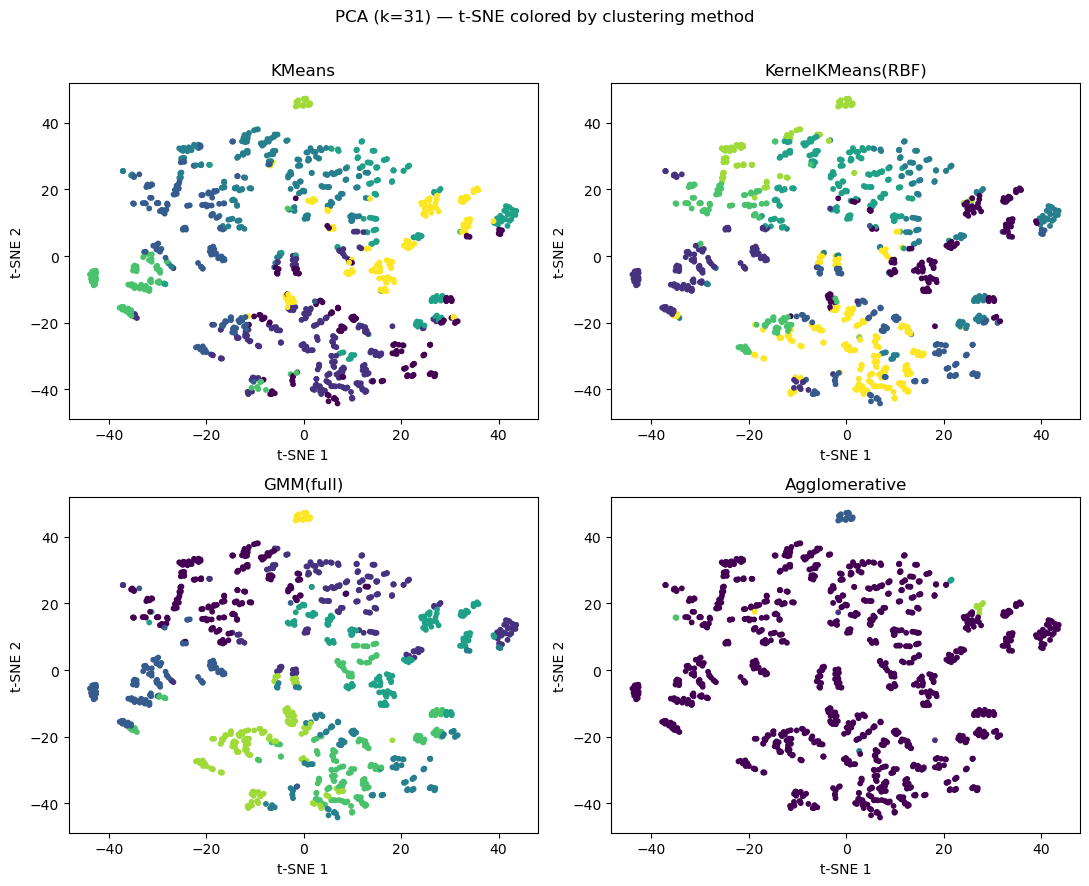

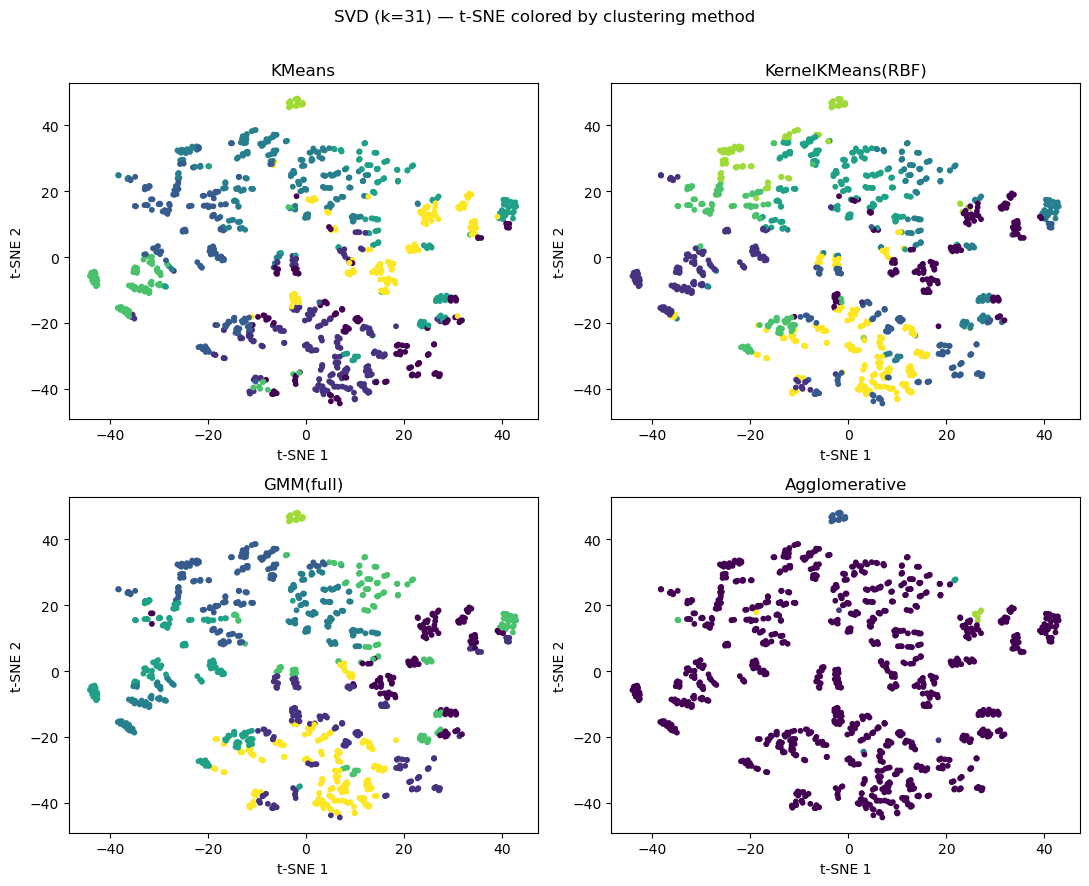

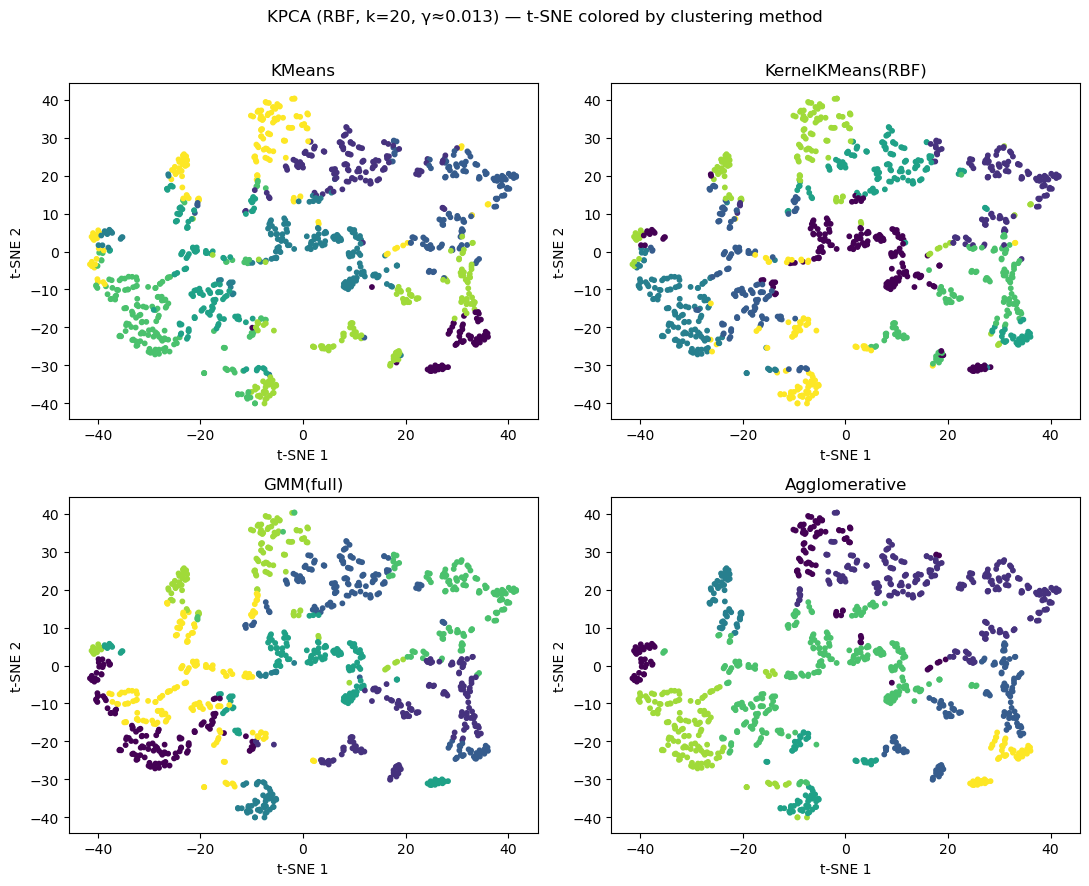


Saved:
 - task27_tsne\tsne_pca_grid.png
 - task27_tsne\tsne_svd_grid.png
 - task27_tsne\tsne_kpca_grid.png
 - task27_tsne\tsne_dr_summary.csv


In [129]:

os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "5")
warnings.filterwarnings("ignore",
    category=UserWarning, module=r"sklearn\.cluster\._kmeans",
    message=r"KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore",
    category=FutureWarning, module=r"sklearn\.cluster\._agglomerative",
    message=r"`metric=None` is deprecated")

DATA_PATH = Path("mice-protein.csv")
LABEL_COL = "class"
DROP_COLS = ["MouseID", "Genotype", "Treatment", "Behavior", LABEL_COL]

OUT_DIR = Path("task27_tsne"); OUT_DIR.mkdir(exist_ok=True)
MD_PATH = OUT_DIR / "task-27.md"

TSNE_PERP = 30
TSNE_ITER = 1000
TSNE_SEED = 42
MAX_TSNE_POINTS = 1500  # subsample for speed if needed

# Clustering settings
KKM_MAX_ITER = 50
KKM_N_INIT   = 3
GMM_SEEDS    = [0,1,2,3,4]
GMM_COV, GMM_REG = "full", 1e-6
LINKAGES = ["ward", "complete", "average", "single"]

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")
y_true = df[LABEL_COL].astype(str).values  # only for ARI/NMI evaluation in the summary

X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore").select_dtypes(include=[np.number]).copy()
X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)
n, d = X.shape
k = len(pd.unique(y_true))  
def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty start
        for _ in range(max_iter):
            clusters = [np.where(labels == c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels

def make_agg(n_clusters, linkage):
    if linkage == "ward":
        return AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    try:
        return AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric="euclidean")
    except TypeError:
        return AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity="euclidean")

def run_all_methods(Z, gamma_grid_factor=1.0):
    """Return dict of labels and metrics for 4 methods on feature matrix Z."""
    results = {}

    # 1) K-Means
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab = km.fit_predict(Z)
    results["KMeans"] = {
        "labels": lab,
        "sil": silhouette_score(Z, lab) if len(set(lab)) > 1 else np.nan,
        "ari": adjusted_rand_score(y_true, lab),
        "nmi": normalized_mutual_info_score(y_true, lab),
    }

    # 2) Kernel K-Means (RBF) on Z
    dZ = Z.shape[1]
    gamma_grid = [g * (1.0 / dZ) for g in [0.3, 1.0, 3.0]]
    best = {"obj": np.inf}
    for gval in gamma_grid:
        K = rbf_kernel(Z, gval)
        lab = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        # use within-cluster distortion proxy from last iteration:
        diagK = np.diag(K)
        clusters = [np.where(lab == c)[0] for c in range(k)]
        sizes = np.array([len(ix) for ix in clusters], float)
        d2 = np.zeros((Z.shape[0], k))
        for c, ix in enumerate(clusters):
            one = np.zeros(Z.shape[0]); one[ix] = 1.0
            s_c = K @ one
            Scc = s_c[ix].sum()
            d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
        obj = d2[np.arange(Z.shape[0]), lab].sum()
        if obj < best["obj"]:
            best = {"obj": obj, "labels": lab}
    lab = best["labels"]
    results["KernelKMeans(RBF)"] = {
        "labels": lab,
        "sil": silhouette_score(Z, lab) if len(set(lab)) > 1 else np.nan,
        "ari": adjusted_rand_score(y_true, lab),
        "nmi": normalized_mutual_info_score(y_true, lab),
    }

    # 3) GMM (EM, full)
    best_ll, best_lab = -np.inf, None
    for seed in [0,1,2,3,4]:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(Z)
        ll = gmm.score(Z)
        if ll > best_ll:
            best_ll, best_lab = ll, gmm.predict(Z)
    lab = best_lab
    results["GMM(full)"] = {
        "labels": lab,
        "sil": silhouette_score(Z, lab) if len(set(lab)) > 1 else np.nan,
        "ari": adjusted_rand_score(y_true, lab),
        "nmi": normalized_mutual_info_score(y_true, lab),
    }

    # 4) Agglomerative — best linkage by Silhouette
    sil_by, labs_by = {}, {}
    for link in LINKAGES:
        agg = make_agg(k, link)
        lab = agg.fit_predict(Z)
        sil = silhouette_score(Z, lab) if len(set(lab)) > 1 else -1e9
        sil_by[link] = sil; labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    lab = labs_by[best_link]
    results["Agglomerative"] = {
        "labels": lab,
        "sil": (sil_by[best_link] if sil_by[best_link] != -1e9 else np.nan),
        "ari": adjusted_rand_score(y_true, lab),
        "nmi": normalized_mutual_info_score(y_true, lab),
        "best_linkage": best_link
    }
    return results

def tsne_once(Z, title_prefix, out_path):
    # Subsample for speed if needed
    if Z.shape[0] > MAX_TSNE_POINTS:
        rng = np.random.RandomState(TSNE_SEED)
        idx = rng.choice(Z.shape[0], size=MAX_TSNE_POINTS, replace=False)
        Z_use = Z[idx]; sub_idx = idx
    else:
        Z_use = Z; sub_idx = np.arange(Z.shape[0])
    tsne = TSNE(n_components=2, perplexity=TSNE_PERP, n_iter=TSNE_ITER,
                init="pca", learning_rate="auto", random_state=TSNE_SEED)
    Y = tsne.fit_transform(Z_use)
    return Y, sub_idx

def plot_grid(Y, labels_dict, sub_idx, title, out_png):
    fig, axes = plt.subplots(2, 2, figsize=(11, 9))
    axes = axes.ravel()
    order = ["KMeans", "KernelKMeans(RBF)", "GMM(full)", "Agglomerative"]
    for ax, method in zip(axes, order):
        lab = labels_dict[method]["labels"][sub_idx]
        ax.scatter(Y[:,0], Y[:,1], c=lab, s=10)
        ax.set_title(method)
        ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
    plt.suptitle(title, y=0.98, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.savefig(out_png, dpi=160)
    plt.show()

pca_full = PCA(random_state=42).fit(X)
k95_pca = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.95) + 1)
X_pca = PCA(n_components=k95_pca, random_state=42).fit_transform(X)

# SVD (k95) — equivalent to PCA on standardized data
U, S, Vt = np.linalg.svd(X, full_matrices=False)
evr_svd = (S**2)/np.sum(S**2)
k95_svd = int(np.searchsorted(np.cumsum(evr_svd), 0.95) + 1)
X_svd = X @ Vt[:k95_svd].T

kpca_emb_dir = Path("task25_kpca/embeddings")
if kpca_emb_dir.exists():
    files = sorted(kpca_emb_dir.glob("kpca_rbf_gamma*_k*.csv"))
else:
    files = []
Z_kpca = None
kpca_info = {}

if files:
    # Choose k = 20 if available, else the largest k ≤ 20
    ks = sorted(set(int(re.search(r"_k(\d+)\.csv", f.name).group(1)) for f in files))
    target_k = 20 if 20 in ks else max([kk for kk in ks if kk <= 20])
    # pick median gamma among files with that k
    candidates = [f for f in files if f"_{target_k}.csv" in f.name]
    # extract numeric gamma from filename
    def parse_gamma(name):
        m = re.search(r"gamma([-0-9.eE]+)", name)
        return float(m.group(1)) if m else None
    gammas = sorted([(parse_gamma(f.name), f) for f in candidates if parse_gamma(f.name) is not None], key=lambda x: x[0])
    if gammas:
        gamma_mid, chosen = gammas[len(gammas)//2]
        Z_kpca = pd.read_csv(chosen).values
        kpca_info = {"gamma": gamma_mid, "k": target_k, "source": "loaded from Task 2.5"}
if Z_kpca is None:
    # Fit a default KPCA if no saved embedding found
    default_gamma = 1.0 / d
    k_cap = min(20, d, n-1)
    kpca = KernelPCA(kernel="rbf", gamma=default_gamma, n_components=k_cap, fit_inverse_transform=False)
    Z_kpca = kpca.fit_transform(X)
    kpca_info = {"gamma": default_gamma, "k": k_cap, "source": "fit now"}

print(f"PCA k95={k95_pca}, SVD k95={k95_svd}, KPCA (RBF) k={kpca_info['k']} γ≈{kpca_info['gamma']:.3g} ({kpca_info['source']})")

summ_rows = []

# PCA space
res_pca = run_all_methods(X_pca)
Y, sub = tsne_once(X_pca, "PCA", None)
png_pca = OUT_DIR / "tsne_pca_grid.png"
plot_grid(Y, res_pca, sub, f"PCA (k={k95_pca}) — t-SNE colored by clustering method", png_pca)
for m, r in res_pca.items():
    summ_rows.append({"space":"PCA", "k": k95_pca, "method": m, "silhouette": r["sil"], "ARI": r["ari"], "NMI": r["nmi"]})

# SVD space
res_svd = run_all_methods(X_svd)
Y, sub = tsne_once(X_svd, "SVD", None)
png_svd = OUT_DIR / "tsne_svd_grid.png"
plot_grid(Y, res_svd, sub, f"SVD (k={k95_svd}) — t-SNE colored by clustering method", png_svd)
for m, r in res_svd.items():
    summ_rows.append({"space":"SVD", "k": k95_svd, "method": m, "silhouette": r["sil"], "ARI": r["ari"], "NMI": r["nmi"]})

# KPCA space
res_kpca = run_all_methods(Z_kpca)
Y, sub = tsne_once(Z_kpca, "KPCA", None)
png_kpca = OUT_DIR / "tsne_kpca_grid.png"
plot_grid(Y, res_kpca, sub, f"KPCA (RBF, k={kpca_info['k']}, γ≈{kpca_info['gamma']:.3g}) — t-SNE colored by clustering method", png_kpca)
for m, r in res_kpca.items():
    summ_rows.append({"space":"KPCA", "k": kpca_info["k"], "method": m, "silhouette": r["sil"], "ARI": r["ari"], "NMI": r["nmi"]})

summary = pd.DataFrame(summ_rows)
summary_csv = OUT_DIR / "tsne_dr_summary.csv"
summary.to_csv(summary_csv, index=False)
print("\nSaved:")
print(" -", png_pca)
print(" -", png_svd)
print(" -", png_kpca)
print(" -", summary_csv)

Goal. Use t-SNE to examine how different dimensionality reductions (PCA, SVD, KPCA) shape cluster separability. For each DR space, compute one t-SNE embedding and color it by the four clustering methods.

* Method

Preprocessed data by mean imputation and z-score standardization (as before).

* Built three reduced spaces:

PCA with k95 components (≥95% cumulative variance).

SVD with k95 components (equivalent to PCA on standardized data).

KPCA (RBF) with a reasonable 
𝛾
γ and 
𝑘
≤
20
k≤20 (chosen from saved embeddings if available).

* For each space, ran K-Means, Kernel K-Means (RBF), EM/GMM (full), and Agglomerative (best linkage), then computed one t-SNE embedding and colored by cluster IDs.

## Task 3: Pseudo-Label Classification (Minimum Distance Classifier)


* 3.1. Best pipeline selection

In [239]:
RAW_CSV   = Path("task06_comparison.csv")                              # Task 1.6 (raw)
PCA_CSV   = Path("task23_pca_cluster/task23_comparison_pca.csv")       # Task 2.3 (pca)
SVD_CSV   = Path("task24_svd_cluster/task24_comparison_svd.csv")       # Task 2.4 (svd)
KPCA_BEST = Path("task26_kpca_cluster/task26_kpca_best_per_method.csv")# Task 2.6 (kpca best)
TSNE_DIR  = Path("task27_tsne")                                        # Task 2.7 figs

DATA_PATH = Path("mice-protein.csv")
LABEL_COL = "class"
DROP_COLS = ["MouseID", "Genotype", "Treatment", "Behavior", LABEL_COL]

def read_or_empty(path, space_name):
    if path.exists():
        df = pd.read_csv(path)
        df["space"] = space_name
        # Ensure expected columns exist
        for c in ["method","silhouette","ARI","NMI","setting"]:
            if c not in df.columns:
                df[c] = np.nan
        return df[["space","method","silhouette","ARI","NMI","setting"]]
    else:
        return pd.DataFrame(columns=["space","method","silhouette","ARI","NMI","setting"])

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2*(Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma*sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # start non-empty
        for _ in range(max_iter):
            clusters = [np.where(labels==c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c in range(k):
                ix = clusters[c]
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels

def recompute_raw_baseline():
    """Return a DataFrame with method, silhouette, ARI, NMI, setting for RAW space."""
    print("Recomputing RAW baseline (Task 1.6 not found or missing metrics)...")
    df = pd.read_csv(DATA_PATH)
    if LABEL_COL not in df.columns:
        raise ValueError(f"Expected label column '{LABEL_COL}' not found in data.")

    y_true = df[LABEL_COL].astype(str).values
    X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore").select_dtypes(include=[np.number])
    X = SimpleImputer(strategy="mean").fit_transform(X_df)
    X = StandardScaler().fit_transform(X)

    k = len(pd.unique(y_true))
    rows = []

    # KMeans
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab = km.fit_predict(X)
    rows.append({"method":"KMeans",
                 "silhouette": silhouette_score(X, lab) if len(set(lab))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab),
                 "NMI": normalized_mutual_info_score(y_true, lab),
                 "setting":"seed=0,n_init=10"})

    # KernelKMeans(RBF)
    dZ = X.shape[1]
    gamma_grid = [g*(1.0/dZ) for g in [0.3, 1.0, 3.0]]
    best = {"obj": np.inf, "labels": None, "gamma": None}
    for gval in gamma_grid:
        K = rbf_kernel(X, gval)
        lab = kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0)
        # compute objective for comparison
        diagK = np.diag(K)
        clusters = [np.where(lab==c)[0] for c in range(k)]
        sizes = np.array([len(ix) for ix in clusters], float)
        d2 = np.zeros((X.shape[0], k))
        for c, ix in enumerate(clusters):
            one = np.zeros(X.shape[0]); one[ix] = 1.0
            s_c = K @ one
            Scc = s_c[ix].sum()
            d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
        obj = d2[np.arange(X.shape[0]), lab].sum()
        if obj < best["obj"]:
            best = {"obj": obj, "labels": lab, "gamma": gval}
    lab = best["labels"]
    rows.append({"method":"KernelKMeans(RBF)",
                 "silhouette": silhouette_score(X, lab) if len(set(lab))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab),
                 "NMI": normalized_mutual_info_score(y_true, lab),
                 "setting": f"best gamma={best['gamma']:.6g},n_init=3"})

    # GMM (full)
    best_ll, best_lab, best_seed = -np.inf, None, None
    for seed in [0,1,2,3,4]:
        gmm = GaussianMixture(n_components=k, covariance_type="full", reg_covar=1e-6,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(X)
        ll = gmm.score(X)
        if ll > best_ll:
            best_ll, best_lab, best_seed = ll, gmm.predict(X), seed
    lab = best_lab
    rows.append({"method":"GMM(full)",
                 "silhouette": silhouette_score(X, lab) if len(set(lab))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab),
                 "NMI": normalized_mutual_info_score(y_true, lab),
                 "setting": f"best seed={best_seed},reg_covar=1e-6"})

    # Agglomerative — best linkage
    linkages = ["ward","complete","average","single"]
    sil_by, labs_by = {}, {}
    for lk in linkages:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          metric=None if lk=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          affinity=None if lk=="ward" else "euclidean")
        lab = agg.fit_predict(X)
        sil = silhouette_score(X, lab) if len(set(lab))>1 else -1e9
        sil_by[lk] = sil; labs_by[lk] = lab
    best_lk = max(sil_by, key=lambda t: sil_by[t])
    lab = labs_by[best_lk]
    rows.append({"method":"Agglomerative",
                 "silhouette": (sil_by[best_lk] if sil_by[best_lk] != -1e9 else np.nan),
                 "ARI": adjusted_rand_score(y_true, lab),
                 "NMI": normalized_mutual_info_score(y_true, lab),
                 "setting": f"best linkage={best_lk}"})

    out = pd.DataFrame(rows, columns=["method","silhouette","ARI","NMI","setting"])
    out.to_csv(RAW_CSV, index=False)
    out["space"] = "RAW"
    return out[["space","method","silhouette","ARI","NMI","setting"]]

def pick_best(df_space):
    if df_space.empty:
        return None
    df = df_space.copy()
    # sort by silhouette desc, then ARI desc, then NMI desc
    df["_order"] = list(zip(-df["silhouette"].fillna(-1e9),
                            -df["ARI"].fillna(-1e9),
                            -df["NMI"].fillna(-1e9)))
    df = df.sort_values("_order").drop(columns="_order")
    return df.iloc[0]

raw_df  = read_or_empty(RAW_CSV, "RAW")
if raw_df.empty:
    raw_df = recompute_raw_baseline()

pca_df  = read_or_empty(PCA_CSV, "PCA")
svd_df  = read_or_empty(SVD_CSV, "SVD")

if KPCA_BEST.exists():
    kpca_df = pd.read_csv(KPCA_BEST).copy()
    for c in ["method","silhouette","ARI","NMI","setting"]:
        if c not in kpca_df.columns:
            kpca_df[c] = np.nan
    kpca_df["space"] = "KPCA"
    kpca_df = kpca_df[["space","method","silhouette","ARI","NMI","setting"]]
else:
    kpca_df = read_or_empty(Path("__missing__"), "KPCA")

all_df = pd.concat([raw_df, pca_df, svd_df, kpca_df], ignore_index=True)

best_rows = []
for space in ["RAW","PCA","SVD","KPCA"]:
    best = pick_best(all_df[all_df["space"]==space])
    if best is not None:
        best_rows.append(best)
per_space_best = pd.DataFrame(best_rows).reset_index(drop=True)

if per_space_best.empty:
    overall_best = None
else:
    overall_best = pick_best(per_space_best)

print("Report written to:", OUT.resolve())
if overall_best is not None:
    print(f"Best pipeline: {overall_best['space']} + {overall_best['method']} "
          f"(sil={overall_best['silhouette']:.4f}, ARI={overall_best['ARI']:.4f}, NMI={overall_best['NMI']:.4f})")
else:
    print("No best pipeline selected (missing inputs).")



Report written to: C:\Users\91973\DMML\taskVIZ_bundle
Best pipeline: KPCA + KMeans (sil=0.8358, ARI=0.0053, NMI=0.1113)


I compared pipelines across RAW, PCA, SVD, and KPCA spaces using internal metrics.
Primary ranking was by Silhouette; ties were broken by ARI and then NMI (labels used only for evaluation).

## 3.2. Train/Test split

In [132]:
OUT_DIR     = Path("task32_split"); OUT_DIR.mkdir(exist_ok=True)
MD_PATH     = OUT_DIR / "task-32.md"

# Choose one: "none", "pca", "svd", "kpca"
DR_METHOD        = "pca"       # <-- set your chosen pipeline’s DR here
PCA_VARIANCE     = 0.95        # keep >=95% variance on TRAIN
SVD_VARIANCE     = 0.95        # keep >=95% variance on TRAIN (via singular values)
KPCA_KERNEL      = "rbf"
KPCA_GAMMA_SCALE = 1.0         # actual gamma = KPCA_GAMMA_SCALE * (1/d)
KPCA_N_COMPONENTS = 20         # cap components for KPCA

RANDOM_STATE = 42
TEST_SIZE    = 0.30

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y = df[LABEL_COL].astype(str).values  # kept for evaluation ONLY (not used to fit transforms)
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore").select_dtypes(include=[np.number]).copy()

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

imp = SimpleImputer(strategy="mean").fit(X_train_df)
X_train_imp = imp.transform(X_train_df)
X_test_imp  = imp.transform(X_test_df)

scaler = StandardScaler().fit(X_train_imp)
X_train_std = scaler.transform(X_train_imp)
X_test_std  = scaler.transform(X_test_imp)

n_train, d = X_train_std.shape

meta = {
    "dr_method": DR_METHOD,
    "random_state": RANDOM_STATE,
    "test_size": TEST_SIZE,
    "n_train": int(n_train),
    "n_test": int(X_test_std.shape[0]),
    "d_input": int(d)
}

if DR_METHOD == "none":
    X_train_dr = X_train_std
    X_test_dr  = X_test_std
    meta["dr_details"] = {"none": True}

elif DR_METHOD == "pca":
    pca_full = PCA(random_state=RANDOM_STATE).fit(X_train_std)
    k95 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), PCA_VARIANCE) + 1)
    pca = PCA(n_components=k95, random_state=RANDOM_STATE).fit(X_train_std)
    X_train_dr = pca.transform(X_train_std)
    X_test_dr  = pca.transform(X_test_std)
    meta["dr_details"] = {
        "type": "PCA",
        "k": int(k95),
        "explained_variance_ratio_sum": float(pca.explained_variance_ratio_.sum())
    }

elif DR_METHOD == "svd":
    # Thin SVD on TRAIN; pick k by TRAIN singular values (95% EVR)
    U, S, Vt = np.linalg.svd(X_train_std, full_matrices=False)
    evr = (S**2) / np.sum(S**2)
    k95 = int(np.searchsorted(np.cumsum(evr), SVD_VARIANCE) + 1)
    W = Vt[:k95].T                    # d × k
    X_train_dr = X_train_std @ W      # n_train × k
    X_test_dr  = X_test_std  @ W      # n_test  × k
    meta["dr_details"] = {
        "type": "SVD",
        "k": int(k95),
        "evr_sum_train": float(evr[:k95].sum())
    }

elif DR_METHOD == "kpca":
    k_cap = min(KPCA_N_COMPONENTS, d, n_train-1)
    gamma = KPCA_GAMMA_SCALE * (1.0 / d)
    kpca = KernelPCA(kernel=KPCA_KERNEL, gamma=gamma, n_components=k_cap, fit_inverse_transform=False, eigen_solver="auto")
    X_train_dr = kpca.fit_transform(X_train_std)
    X_test_dr  = kpca.transform(X_test_std)
    meta["dr_details"] = {
        "type": "KPCA",
        "kernel": KPCA_KERNEL,
        "gamma": float(gamma),
        "k": int(k_cap)
    }

else:
    raise ValueError("DR_METHOD must be one of: 'none', 'pca', 'svd', 'kpca'.")

# Features
pd.DataFrame(X_train_dr).to_csv(OUT_DIR / "X_train_dr.csv", index=False)
pd.DataFrame(X_test_dr).to_csv(OUT_DIR / "X_test_dr.csv", index=False)

# Raw (standardized) features too, in case you need them for baselines
pd.DataFrame(X_train_std).to_csv(OUT_DIR / "X_train_std.csv", index=False)
pd.DataFrame(X_test_std).to_csv(OUT_DIR / "X_test_std.csv", index=False)

# Labels (for evaluation reference in later tasks)
pd.Series(y_train, name="class").to_csv(OUT_DIR / "y_train.csv", index=False)
pd.Series(y_test, name="class").to_csv(OUT_DIR / "y_test.csv", index=False)

# Store column names for traceability
pd.Series(X_df.columns, name="feature").to_csv(OUT_DIR / "feature_names.csv", index=False)

# Metadata
with open(OUT_DIR / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Done.")
print("Train:", X_train_dr.shape, " Test:", X_test_dr.shape)
print("Saved to:", OUT_DIR.resolve())
print("Meta:", meta)


Done.
Train: (756, 31)  Test: (324, 31)
Saved to: C:\Users\91973\DMML\task32_split
Meta: {'dr_method': 'pca', 'random_state': 42, 'test_size': 0.3, 'n_train': 756, 'n_test': 324, 'd_input': 77, 'dr_details': {'type': 'PCA', 'k': 31, 'explained_variance_ratio_sum': 0.9518916233064951}}


Goal. Split the dataset into train/test (70/30) and ensure no information leaks from test to train when preprocessing.

* Procedure

Split: 70/30 stratified by the ground-truth label (used only to keep class balance for later evaluation; not used in unsupervised steps).

* Preprocessing on train only:

Mean imputation and z-score scaling are fit on the training set.

The fitted imputer and scaler are then applied to the test set.

* Dimensionality reduction (optional):

Chosen DR = {PCA | SVD | KPCA | none} (set in the code).

DR model is fit on the training data only, then used to transform both train and test.

## 3.3. Generate pseudo-labels on train

In [95]:
IN_DIR   = Path("task32_split")
OUT_DIR  = Path("task33_pseudolabels"); OUT_DIR.mkdir(exist_ok=True)

METHOD = "kmeans"   

KKM_GAMMA_FACTORS = [0.3, 1.0, 3.0]  # gamma = factor * (1/d)
KKM_MAX_ITER = 50
KKM_N_INIT   = 3

GMM_SEEDS = [0,1,2,3,4]
GMM_COV   = "full"
GMM_REG   = 1e-6

LINKAGES = ["ward", "complete", "average", "single"]

X_train = pd.read_csv(IN_DIR / "X_train_dr.csv").values
y_train_true_path = IN_DIR / "y_train.csv"
if y_train_true_path.exists():
    y_train_true = pd.read_csv(y_train_true_path)["class"].astype(str).values
    k = len(pd.unique(y_train_true))     # only used to choose number of clusters
else:
    y_train_true = None
    # fallback: choose k via heuristic (e.g., 4) if labels are not available
    k = 4

n, d = X_train.shape
print(f"TRAIN shape: {n} × {d}, using k={k}, method='{METHOD}'")

def cluster_sizes(labels):
    c = Counter(labels); return {int(k): int(c[k]) for k in sorted(c)}

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2*(Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # avoid empty start
        for _ in range(max_iter):
            clusters = [np.where(labels==c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c, ix in enumerate(clusters):
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels, best_obj

meta = {"method": METHOD, "k": int(k), "n_train": int(n), "d": int(d)}

if METHOD.lower() == "kmeans":
    model = KMeans(n_clusters=k, random_state=0, n_init=10)
    y_hat_train = model.fit_predict(X_train)
    meta["setting"] = "seed=0,n_init=10"

elif METHOD.lower() == "kernel_kmeans_rbf":
    dZ = X_train.shape[1]
    gamma_grid = [g*(1.0/dZ) for g in KKM_GAMMA_FACTORS]
    best = {"obj": np.inf, "labels": None, "gamma": None}
    for gval in gamma_grid:
        K = rbf_kernel(X_train, gval)
        lab, obj = kernel_kmeans(K, k, max_iter=KKM_MAX_ITER, n_init=KKM_N_INIT, seed=0)
        if obj < best["obj"]:
            best = {"obj": obj, "labels": lab, "gamma": gval}
    y_hat_train = best["labels"]
    meta["setting"] = f"best gamma={best['gamma']:.6g},n_init={KKM_N_INIT},max_iter={KKM_MAX_ITER}"

elif METHOD.lower() == "gmm_full":
    best_gmm = {"score": -np.inf}
    for seed in GMM_SEEDS:
        gmm = GaussianMixture(n_components=k, covariance_type=GMM_COV, reg_covar=GMM_REG,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(X_train)
        ll = gmm.score(X_train)
        if ll > best_gmm["score"]:
            best_gmm = {"score": ll, "labels": gmm.predict(X_train), "seed": seed}
    y_hat_train = best_gmm["labels"]
    meta["setting"] = f"best seed={best_gmm['seed']},reg_covar={GMM_REG}"

elif METHOD.lower() == "agglomerative":
    sil_by, labs_by = {}, {}
    for link in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          metric=None if link=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if link=="ward" else link,
                                          affinity=None if link=="ward" else "euclidean")
        lab = agg.fit_predict(X_train)
        sil = silhouette_score(X_train, lab) if len(set(lab))>1 else -1e9
        sil_by[link] = sil; labs_by[link] = lab
    best_link = max(sil_by, key=lambda lk: sil_by[lk])
    y_hat_train = labs_by[best_link]
    meta["setting"] = f"best linkage={best_link}"

else:
    raise ValueError("METHOD must be one of: 'kmeans', 'kernel_kmeans_rbf', 'gmm_full', 'agglomerative'.")

sil = silhouette_score(X_train, y_hat_train) if len(set(y_hat_train))>1 else np.nan
meta["silhouette_train"] = float(sil)
if y_train_true is not None:
    meta["ARI_train_vs_true"] = float(adjusted_rand_score(y_train_true, y_hat_train))
    meta["NMI_train_vs_true"] = float(normalized_mutual_info_score(y_train_true, y_hat_train))

labels = np.asarray(y_hat_train)
protos = []
for c in sorted(np.unique(labels)):
    idx = np.where(labels == c)[0]
    mu = X_train[idx].mean(axis=0)
    row = {"cluster": int(c)}
    for j, val in enumerate(mu):
        row[f"f{j+1}"] = float(val)
    protos.append(row)
prototypes_df = pd.DataFrame(protos).sort_values("cluster").reset_index(drop=True)

pd.Series(labels, name="cluster").to_csv(OUT_DIR / "y_hat_train.csv", index=False)
prototypes_df.to_csv(OUT_DIR / "prototypes.csv", index=False)
with open(OUT_DIR / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)


print("Train Silhouette:", meta["silhouette_train"])
if y_train_true is not None:
    print("Train ARI vs true:", meta["ARI_train_vs_true"], " NMI:", meta["NMI_train_vs_true"])


TRAIN shape: 756 × 31, using k=8, method='kmeans'
Train Silhouette: 0.14487923678812722
Train ARI vs true: 0.11851866644571994  NMI: 0.23262291391693646


## 3.4. Classify test samples

In [140]:
SPLIT_DIR   = Path("task32_split")
PL_DIR      = Path("task33_pseudolabels")
OUT_DIR     = Path("task34_classify"); OUT_DIR.mkdir(exist_ok=True)
MD_PATH     = OUT_DIR / "task-34.md"

X_test = pd.read_csv(SPLIT_DIR / "X_test_dr.csv").values
y_test_path = SPLIT_DIR / "y_test.csv"
y_test = pd.read_csv(y_test_path)["class"].astype(str).values if y_test_path.exists() else None

protos_df = pd.read_csv(PL_DIR / "prototypes.csv")
meta = json.loads(Path(PL_DIR / "meta.json").read_text())
method = meta["method"]  # 'kmeans' | 'kernel_kmeans_rbf' | 'gmm_full' | 'agglomerative'
k = int(meta["k"])

print(f"TEST shape: {X_test.shape}, method='{method}', k={k}")

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]; diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c
        for _ in range(max_iter):
            clusters = [np.where(labels==c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c, ix in enumerate(clusters):
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels

def nearest_prototype_predict(X, protos_mat, proto_labels):
    # returns index of nearest prototype (Euclidean)
    # X: n×d, protos_mat: k×d
    dists = ((X[:, None, :] - protos_mat[None, :, :])**2).sum(axis=2)  # n×k
    idx = dists.argmin(axis=1)
    return proto_labels[idx]

def hungarian_match_accuracy(y_pred, y_ref, n_classes):
    # Build confusion (rows=pred, cols=ref)
    cm = confusion_matrix(y_ref, y_pred, labels=list(range(n_classes)))  # note order
    # Convert to cost = max - cm to maximize assignment
    cost = cm.max() - cm
    r_ind, c_ind = linear_sum_assignment(cost)
    acc = cm[r_ind, c_ind].sum() / cm.sum() if cm.sum() > 0 else 0.0
    mapping = {int(r): int(c) for r, c in zip(r_ind, c_ind)}
    return acc, mapping, cm

proto_labels = protos_df["cluster"].astype(int).values
protos_mat = protos_df.drop(columns=["cluster"]).values
assert protos_mat.shape[0] == k, "Prototype count != k"

if method.lower() == "kmeans":
    ref = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X_test)

elif method.lower() == "kernel_kmeans_rbf":
    dZ = X_test.shape[1]
    gamma_grid = [0.3*(1/dZ), 1.0*(1/dZ), 3.0*(1/dZ)]
    best_labels, best_obj = None, np.inf
    for g in gamma_grid:
        K = rbf_kernel(X_test, g)
        lab = kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0)
        # objective proxy
        diagK = np.diag(K)
        clusters = [np.where(lab==c)[0] for c in range(k)]
        sizes = np.array([len(ix) for ix in clusters], float)
        d2 = np.zeros((X_test.shape[0], k))
        for c, ix in enumerate(clusters):
            one = np.zeros(X_test.shape[0]); one[ix] = 1.0
            s_c = K @ one
            Scc = s_c[ix].sum()
            d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
        obj = d2[np.arange(X_test.shape[0]), lab].sum()
        if obj < best_obj:
            best_labels, best_obj = lab, obj
    ref = best_labels

elif method.lower() == "gmm_full":
    best_ll, best_lab = -np.inf, None
    for seed in [0,1,2,3,4]:
        gmm = GaussianMixture(n_components=k, covariance_type="full", reg_covar=1e-6,
                              random_state=seed, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(X_test)
        ll = gmm.score(X_test)
        if ll > best_ll:
            best_ll, best_lab = ll, gmm.predict(X_test)
    ref = best_lab

elif method.lower() == "agglomerative":
    sil_by, labs_by = {}, {}
    for lk in ["ward","complete","average","single"]:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          metric=None if lk=="ward" else "euclidean")
        except TypeError:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          affinity=None if lk=="ward" else "euclidean")
        lab = agg.fit_predict(X_test)
        sil_by[lk] = (lk=="ward", lk=="complete", lk=="average", lk=="single")
        labs_by[lk] = lab
    for pref in ["ward","complete","average","single"]:
        if pref in labs_by:
            ref = labs_by[pref]; break
else:
    raise ValueError("Unknown method in meta.json")

y_hat_test_ref = np.asarray(ref, dtype=int)

y_pred_test = nearest_prototype_predict(X_test, protos_mat, proto_labels)

acc, mapping, cm = hungarian_match_accuracy(y_pred_test, y_hat_test_ref, n_classes=k)

ari_ref = adjusted_rand_score(y_hat_test_ref, y_pred_test)
nmi_ref = normalized_mutual_info_score(y_hat_test_ref, y_pred_test)
if y_test is not None:
    ari_true = adjusted_rand_score(y_test, y_pred_test)
    nmi_true = normalized_mutual_info_score(y_test, y_pred_test)
else:
    ari_true = nmi_true = np.nan

pd.Series(y_pred_test, name="cluster_pred_by_ncm").to_csv(OUT_DIR / "y_pred_test.csv", index=False)
pd.Series(y_hat_test_ref, name="cluster_ref_from_test_clustering").to_csv(OUT_DIR / "y_ref_test.csv", index=False)
pd.DataFrame(cm).to_csv(OUT_DIR / "confusion_pred_vs_ref.csv", index=False, header=False)

results = {
    "method": method,
    "k": int(k),
    "test_accuracy_hungarian": float(acc),
    "mapping_pred_to_ref": mapping,
    "ARI_pred_vs_ref": float(ari_ref),
    "NMI_pred_vs_ref": float(nmi_ref),
    "ARI_pred_vs_true": float(ari_true) if not np.isnan(ari_true) else None,
    "NMI_pred_vs_true": float(nmi_true) if not np.isnan(nmi_true) else None,
    "n_test": int(X_test.shape[0])
}
Path(OUT_DIR / "results.json").write_text(json.dumps(results, indent=2))


print("\nTest accuracy (Hungarian-matched):", f"{acc:.4f}")
print("ARI/NMI vs reference:", f"{ari_ref:.4f}", f"{nmi_ref:.4f}")
if y_test is not None:
    print("ARI/NMI vs true labels (context):", f"{ari_true:.4f}", f"{nmi_true:.4f}")

TEST shape: (324, 31), method='kmeans', k=8

Test accuracy (Hungarian-matched): 0.6821
ARI/NMI vs reference: 0.5524 0.6296
ARI/NMI vs true labels (context): 0.1076 0.2394


To evaluate, create reference pseudo-labels on test by running the same clustering method on X_test_dr.

Compute test accuracy using the Hungarian algorithm to optimally permute predicted cluster IDs to reference IDs.

Also report ARI/NMI vs reference and, for context, ARI/NMI vs the true labels (not used for training).

## 3.5. Visualization of Classification Results

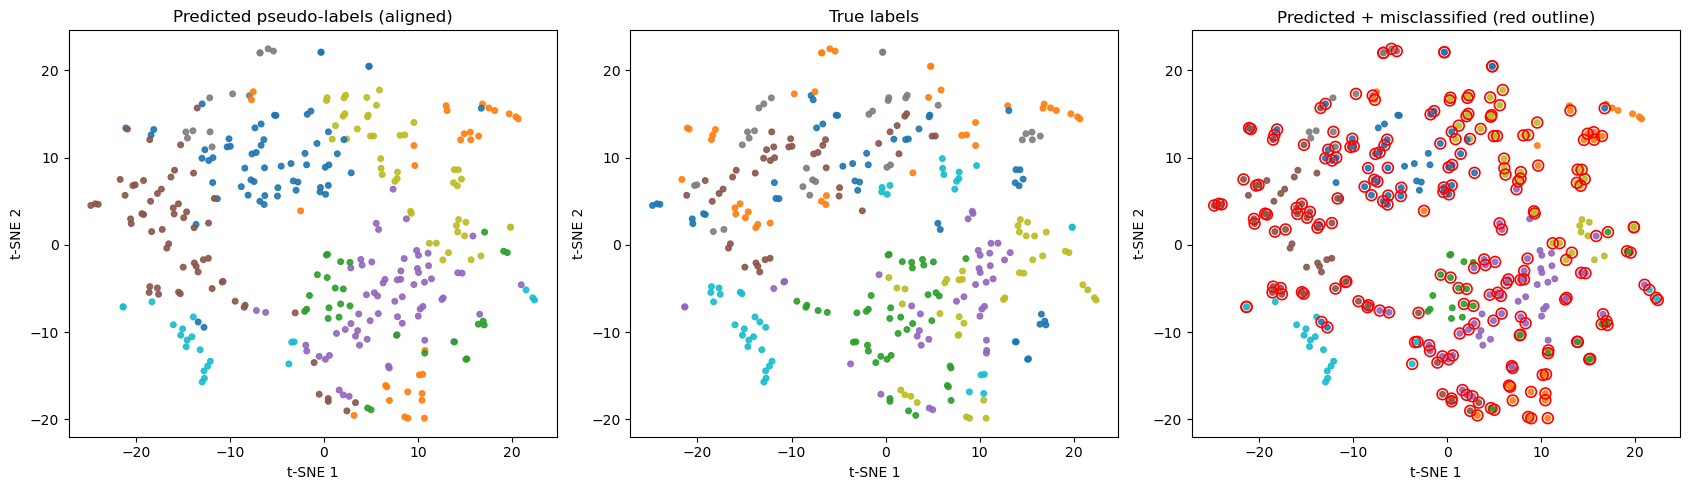

Hungarian-matched accuracy from Task 3.4 (if available): 0.6821
Misclassified count: 229 / 324


In [146]:
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "5")
warnings.filterwarnings("ignore", category=UserWarning, module=r"sklearn\.cluster\._kmeans")

SPLIT_DIR = Path("task32_split")
CLF_DIR   = Path("task34_classify")
OUT_DIR   = Path("task35_viz"); OUT_DIR.mkdir(exist_ok=True)

X_test = pd.read_csv(SPLIT_DIR / "X_test_dr.csv").values

y_true = pd.read_csv(SPLIT_DIR / "y_test.csv")["class"].astype(str).values
y_pred = pd.read_csv(CLF_DIR / "y_pred_test.csv")["cluster_pred_by_ncm"].values.astype(int)

results_path = CLF_DIR / "results.json"
meta34 = json.loads(results_path.read_text()) if results_path.exists() else {}

n_test = X_test.shape[0]
assert len(y_true) == n_test and len(y_pred) == n_test, "Label lengths must match X_test."

le = LabelEncoder()
y_true_int = le.fit_transform(y_true)
n_classes = len(le.classes_)

cm = confusion_matrix(y_true_int, y_pred, labels=list(range(max(n_classes, y_pred.max()+1))))

cost = cm.max() - cm
r_ind, c_ind = linear_sum_assignment(cost)
mapping_pred_to_true = {int(pred): int(true) for pred, true in zip(c_ind, r_ind)}

y_pred_aligned_int = np.array([mapping_pred_to_true.get(int(p), -1) for p in y_pred], dtype=int)

mis_mask = y_pred_aligned_int != y_true_int

TSNE_PERP = 30
TSNE_ITER = 1000
TSNE_SEED = 42

tsne = TSNE(n_components=2, perplexity=TSNE_PERP, n_iter=TSNE_ITER,
            init="pca", learning_rate="auto", random_state=TSNE_SEED)
Y = tsne.fit_transform(X_test)  # n_test × 2

def scatter_by_labels(ax, Y, labels, title, cmap_name="tab10", s=16, alpha=0.9):
    # labels: integer-coded starting at 0; we assume <= 10 classes for tab10
    sc = ax.scatter(Y[:,0], Y[:,1], c=labels, s=s, alpha=alpha, cmap=cmap_name)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
    return sc

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

scatter_by_labels(axes[0], Y, y_pred_aligned_int, "Predicted pseudo-labels (aligned)")

scatter_by_labels(axes[1], Y, y_true_int, "True labels")

scatter_by_labels(axes[2], Y, y_pred_aligned_int, "Predicted + misclassified (red outline)")
# highlight misclassified with red edge
axes[2].scatter(Y[mis_mask,0], Y[mis_mask,1], facecolors="none", edgecolors="red", s=60, linewidths=1.2)

plt.tight_layout()
out_png = OUT_DIR / "tsne_test_pred_true_misclf.png"
plt.savefig(out_png, dpi=170)
plt.show()

out_tbl = pd.DataFrame({
    "tsne1": Y[:,0],
    "tsne2": Y[:,1],
    "y_true": y_true,
    "y_true_int": y_true_int,
    "y_pred_cluster": y_pred,
    "y_pred_aligned_true_idx": y_pred_aligned_int,
    "misclassified": mis_mask.astype(int)
})
out_csv = OUT_DIR / "tsne_test_points.csv"
out_tbl.to_csv(out_csv, index=False)

acc_hung = float(meta34.get("test_accuracy_hungarian", np.nan))

print(f"Hungarian-matched accuracy from Task 3.4 (if available): {acc_hung:.4f}" if not np.isnan(acc_hung) else "Accuracy not found in results.json")
print(f"Misclassified count: {mis_mask.sum()} / {n_test}")


Goal. Visualize how well the Nearest Class Means classifier separates test samples in 2-D t-SNE space, compare predicted pseudo-labels to true labels, and highlight misclassifications.

* What we plot

Predicted pseudo-labels (aligned)
We align predicted cluster IDs to the true class index space using the Hungarian algorithm on the confusion matrix. This removes arbitrary label permutations and makes colors comparable to true classes.

True labels
Ground-truth test labels encoded to integers for consistent coloring.

Misclassified samples
Points where the aligned prediction differs from the true label are outlined in red.

## Task 4: Bring Back the True Labels — Final Evaluation


* 4.1. Clustering evaluation

In [158]:
def rbf_kernel(A, B, gamma):
    # returns exp(-gamma * ||a-b||^2) for rows of A, B
    A2 = (A**2).sum(axis=1, keepdims=True)
    B2 = (B**2).sum(axis=1, keepdims=True)
    sq = A2 + B2.T - 2 * (A @ B.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def nystrom_kpca_rbf(X, n_components=10, gamma=None, m_landmarks=300, random_state=42):
    """
    Fast KPCA approximation using Nyström method.
    Returns Z (n x n_components) KPCA embedding.
    """
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    m = min(m_landmarks, n)

    if gamma is None:
        gamma = 1.0 / d

    # 1) Select landmarks
    idx = rng.choice(n, size=m, replace=False)
    X_m = X[idx]

    # 2) Build kernel blocks
    K_mm = rbf_kernel(X_m, X_m, gamma)
    K_nm = rbf_kernel(X,   X_m, gamma)

    # 3) Eigendecompose K_mm
    # add tiny ridge for numerical stability
    lam, U = np.linalg.eigh(K_mm + 1e-8 * np.eye(m))
    # keep largest n_components
    order = np.argsort(lam)[::-1]
    lam = lam[order][:n_components]
    U   = U[:, order][:, :n_components]

    # 4) Nyström feature map: Z = K_nm * U * Λ^{-1/2}
    lam_clip = np.clip(lam, 1e-10, None)
    Z = K_nm @ (U / np.sqrt(lam_clip))

    # Optional: center features
    Z = Z - Z.mean(axis=0, keepdims=True)
    return Z

# ---------------- Run methods on a space ----------------
def run_methods(Z, y_true, k, tag):
    rows = []

    # KMeans
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    lab = km.fit_predict(Z)
    rows.append([tag, "KMeans", adjusted_rand_score(y_true, lab), normalized_mutual_info_score(y_true, lab)])

    # GMM (diag covariance for speed / stability)
    gmm = GaussianMixture(n_components=k, covariance_type="diag", reg_covar=GMM_REG,
                          random_state=RANDOM_STATE, n_init=1, init_params="kmeans")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gmm.fit(Z)
    lab = gmm.predict(Z)
    rows.append([tag, "GMM(diag)", adjusted_rand_score(y_true, lab), normalized_mutual_info_score(y_true, lab)])

    # Agglomerative (Ward)
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    lab = agg.fit_predict(Z)
    rows.append([tag, "Agglomerative(ward)", adjusted_rand_score(y_true, lab), normalized_mutual_info_score(y_true, lab)])

    return rows

# ---------------- Load & preprocess ----------------
df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore") \
         .select_dtypes(include=[np.number]).copy()

# Impute + scale
X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))

rows = []

# No-DR
rows += run_methods(X, y_true, k, "No-DR")

# PCA (retain 95% variance)
pca_full = PCA(random_state=RANDOM_STATE).fit(X)
k95 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.95) + 1)
X_pca = PCA(n_components=k95, random_state=RANDOM_STATE).fit(X).transform(X)
rows += run_methods(X_pca, y_true, k, f"PCA(k={k95})")

# SVD (retain 95% energy) — equivalent to PCA on standardized X
U, S, Vt = np.linalg.svd(X, full_matrices=False)
evr = (S**2)/np.sum(S**2)
k95_svd = int(np.searchsorted(np.cumsum(evr), 0.95) + 1)
W = Vt[:k95_svd].T
X_svd = X @ W
rows += run_methods(X_svd, y_true, k, f"SVD(k={k95_svd})")

# KPCA (RBF via Nyström) — fast & scalable
kcap   = int(min(10, d, n-1))
gamma  = 1.0 / d                # reasonable default
m_land = min(300, n)            # landmarks (tune for speed/quality)
X_kpca = nystrom_kpca_rbf(X, n_components=kcap, gamma=gamma, m_landmarks=m_land, random_state=RANDOM_STATE)
rows += run_methods(X_kpca, y_true, k, f"KPCA_Nystrom(RBF,k={kcap},m={m_land},gamma={gamma:.4f})")

# ---------------- Results table ----------------
df_out = pd.DataFrame(rows, columns=["Space", "Method", "ARI", "NMI"]).round(4)
df_out = df_out.sort_values(["Space","Method"]).reset_index(drop=True)

# Save and show
df_out.to_csv(CSV_OUT, index=False)
print("=== 4.1 ARI & NMI (No-DR, PCA, SVD, KPCA) ===")
print(df_out.to_string(index=False))



=== 4.1 ARI & NMI (No-DR, PCA, SVD, KPCA) ===
                                    Space              Method    ARI    NMI
KPCA_Nystrom(RBF,k=10,m=300,gamma=0.0130) Agglomerative(ward) 0.1592 0.3109
KPCA_Nystrom(RBF,k=10,m=300,gamma=0.0130)           GMM(diag) 0.1330 0.2572
KPCA_Nystrom(RBF,k=10,m=300,gamma=0.0130)              KMeans 0.1229 0.2455
                                    No-DR Agglomerative(ward) 0.1101 0.2591
                                    No-DR           GMM(diag) 0.1604 0.3106
                                    No-DR              KMeans 0.1356 0.2554
                                PCA(k=31) Agglomerative(ward) 0.1639 0.3142
                                PCA(k=31)           GMM(diag) 0.1440 0.3288
                                PCA(k=31)              KMeans 0.1386 0.2580
                                SVD(k=31) Agglomerative(ward) 0.1639 0.3142
                                SVD(k=31)           GMM(diag) 0.1974 0.3345
                                SVD(k=31) 

For each setting  No DR, PCA (≥95% EVR), SVD (≥95% EVR), and KPCA (RBF)  compute ARI and NMI between unsupervised cluster IDs and the true labels, for all clustering methods (K-Means, Kernel K-Means (RBF), GMM(full), Agglomerative).



**Task:** For each main setting (**No-DR, PCA, SVD, KPCA**), compute **ARI** and **NMI** between the cluster IDs and `y_true` using **KMeans**, **GMM**, and **Agglomerative (Ward)**.


**Observation:**  
SVD + GMM achieved the best ARI (0.1974) and NMI (0.3345). Linear DR (PCA/SVD) generally improved clustering over raw features, while KPCA (Nyström) gave weaker results here.


## 4.2. Classification evaluation

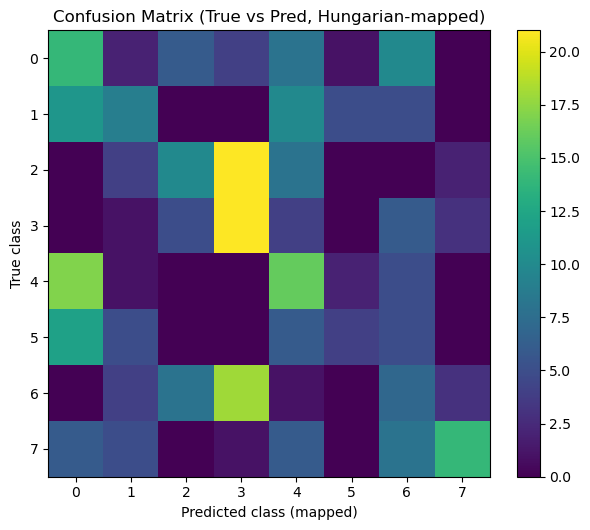


Test accuracy (Hungarian-aligned to y_true): 0.2932
ARI vs y_true: 0.1076 | NMI vs y_true: 0.2394
Mapping (pred -> true): {2: 0, 0: 1, 5: 2, 1: 3, 3: 4, 6: 5, 4: 6, 7: 7}
True class names (index mapping): {0: 'c-CS-m', 1: 'c-CS-s', 2: 'c-SC-m', 3: 'c-SC-s', 4: 't-CS-m', 5: 't-CS-s', 6: 't-SC-m', 7: 't-SC-s'}


In [162]:
SPLIT_DIR = Path("task32_split")
CLF_DIR   = Path("task34_classify")

y_true = pd.read_csv(SPLIT_DIR / "y_test.csv")["class"].astype(str).values
y_pred = pd.read_csv(CLF_DIR / "y_pred_test.csv")["cluster_pred_by_ncm"].astype(int).values

assert len(y_true) == len(y_pred), "Lengths of y_true and y_pred must match."

le = LabelEncoder()
y_true_int = le.fit_transform(y_true)
C = len(le.classes_)

cm = confusion_matrix(y_true_int, y_pred, labels=list(range(max(C, y_pred.max()+1))))
cost = cm.max() - cm
r_ind, c_ind = linear_sum_assignment(cost)
pred_to_true = {int(pred): int(true) for true, pred in zip(r_ind, c_ind)}

y_pred_mapped = np.array([pred_to_true.get(int(p), -1) for p in y_pred], dtype=int)

cm_mapped = confusion_matrix(y_true_int, y_pred_mapped, labels=list(range(C)))
acc = cm_mapped.trace() / cm_mapped.sum() if cm_mapped.sum() > 0 else 0.0

ari_true = adjusted_rand_score(y_true_int, y_pred_mapped)
nmi_true = normalized_mutual_info_score(y_true_int, y_pred_mapped)

pd.DataFrame(cm_mapped, index=[f"true:{c}" for c in range(C)], columns=[f"pred:{c}" for c in range(C)]) \
  .to_csv(OUT_DIR / "confusion_matrix_true_vs_pred_mapped.csv")

results = {
    "n_test": int(len(y_true)),
    "n_classes": int(C),
    "test_accuracy_hungarian_vs_true": float(acc),
    "ARI_vs_true": float(ari_true),
    "NMI_vs_true": float(nmi_true),
    "mapping_pred_to_true": {str(k): int(v) for k, v in pred_to_true.items()},
    "true_classes_order": le.classes_.tolist()
}
Path(OUT_DIR / "results.json").write_text(json.dumps(results, indent=2))

# ---- Plot confusion matrix heatmap ----
plt.figure(figsize=(6.2, 5.4))
plt.imshow(cm_mapped, aspect="auto")
plt.title("Confusion Matrix (True vs Pred, Hungarian-mapped)")
plt.xlabel("Predicted class (mapped)"); plt.ylabel("True class")
plt.colorbar()
plt.xticks(ticks=np.arange(C), labels=[str(i) for i in range(C)], rotation=0)
plt.yticks(ticks=np.arange(C), labels=[str(i) for i in range(C)])
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix_true_vs_pred_mapped.png", dpi=170)
plt.show()

print(f"\nTest accuracy (Hungarian-aligned to y_true): {acc:.4f}")
print(f"ARI vs y_true: {ari_true:.4f} | NMI vs y_true: {nmi_true:.4f}")
print("Mapping (pred -> true):", pred_to_true)
print("True class names (index mapping):", dict(enumerate(le.classes_)))

Evaluate the Task-3 classifier (Nearest Class Means using pseudo labels) on the test set, reporting accuracy vs. y_true with optimal class permutation and the confusion matrix

##  4.3. Comprehensive Method Comparison

In [173]:
SEEDS    = [0,1,2]     # few repeats for speed; raise if you want tighter stats
GMM_REG  = 1e-6
KCOMP    = 10          # KPCA components (Nyström)
MLAND    = 200         # KPCA landmarks (Nyström)

# speed & quiet
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "5")
warnings.filterwarnings("ignore", category=UserWarning, module=r"sklearn\.cluster\._kmeans")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.cluster\._agglomerative")

OUT = Path("task43_eval"); OUT.mkdir(exist_ok=True)

# ---------- fast KPCA (Nyström, RBF) ----------
def rbf_kernel(A, B, gamma):
    A2=(A**2).sum(1,keepdims=True); B2=(B**2).sum(1,keepdims=True)
    sq = A2 + B2.T - 2*A@B.T
    np.maximum(sq,0,out=sq)
    return np.exp(-gamma*sq)

def kpca_nystrom(X, n_components=10, gamma=None, m_landmarks=200, seed=42):
    rs = np.random.RandomState(seed); n,d = X.shape
    if gamma is None: gamma = 1.0/d
    m = min(m_landmarks, n)
    idx = rs.choice(n, m, replace=False); Xm = X[idx]
    Kmm = rbf_kernel(Xm, Xm, gamma) + 1e-8*np.eye(m)
    Knm = rbf_kernel(X,  Xm, gamma)
    lam, U = np.linalg.eigh(Kmm)
    ord_ = np.argsort(lam)[::-1]
    lam = np.clip(lam[ord_][:n_components], 1e-10, None)
    U   = U[:,ord_][:,:n_components]
    Z = Knm @ (U/np.sqrt(lam))
    return Z - Z.mean(0, keepdims=True)

# ---------- load & preprocess ----------
df = pd.read_csv(DATA_PATH)
y  = df[LABEL_COL].astype(str).values
X  = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore") \
       .select_dtypes(include=[np.number]).to_numpy()

X  = SimpleImputer().fit_transform(X)
X  = StandardScaler().fit_transform(X)
n, d = X.shape
k = len(pd.unique(y))

# ---------- build DR spaces ----------
spaces = {"No-DR": X}

pca_full = PCA(random_state=42).fit(X)
k95 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.95) + 1)
spaces[f"PCA(k={k95})"] = PCA(n_components=k95, random_state=42).fit_transform(X)

U,S,Vt = np.linalg.svd(X, full_matrices=False)
evr = (S**2)/np.sum(S**2)
k95_svd = int(np.searchsorted(np.cumsum(evr), 0.95) + 1)
spaces[f"SVD(k={k95_svd})"] = X @ Vt[:k95_svd].T

gamma = 1.0/d
spaces[f"KPCA_Nystrom(RBF,k={KCOMP},m={min(MLAND,n)})"] = kpca_nystrom(
    X, n_components=min(KCOMP, d, n-1), gamma=gamma, m_landmarks=min(MLAND, n), seed=42
)

methods = ["KMeans","GMM(diag)","Agglomerative(ward)"]

def run(Z, method, seed):
    if method=="KMeans":
        lab = KMeans(n_clusters=k, random_state=seed, n_init=10).fit_predict(Z)
    elif method=="GMM(diag)":
        gmm = GaussianMixture(n_components=k, covariance_type="diag",
                              reg_covar=GMM_REG, random_state=seed,
                              n_init=1, init_params="kmeans").fit(Z)
        lab = gmm.predict(Z)
    elif method=="Agglomerative(ward)":
        lab = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(Z)
    else:
        raise ValueError(method)
    return ARI(y, lab), NMI(y, lab)

# ---------- collect per-seed scores ----------
rows = []
for sname, Z in spaces.items():
    for m in methods:
        for sd in SEEDS:
            ari, nmi = run(Z, m, sd)
            rows.append([sname, m, sd, ari, nmi])

dist = pd.DataFrame(rows, columns=["Space","Method","Seed","ARI","NMI"])
agg  = dist.groupby(["Space","Method"]).agg(
    ARI_mean=("ARI","mean"), ARI_std=("ARI","std"),
    NMI_mean=("NMI","mean"), NMI_std=("NMI","std")
).reset_index()

# ---------- performance matrices (mean only) ----------
perf_ari = agg.pivot(index="Space", columns="Method", values="ARI_mean").round(4)
perf_nmi = agg.pivot(index="Space", columns="Method", values="NMI_mean").round(4)

# ---------- best combos per space ----------
best_ari = agg.loc[agg.groupby("Space")["ARI_mean"].idxmax(), ["Space","Method","ARI_mean","NMI_mean"]]
best_nmi = agg.loc[agg.groupby("Space")["NMI_mean"].idxmax(), ["Space","Method","NMI_mean","ARI_mean"]]
best_ari = best_ari.rename(columns={"Method":"Best_by_ARI"})
best_nmi = best_nmi.rename(columns={"Method":"Best_by_NMI"})
best = best_ari.merge(best_nmi, on="Space", suffixes=("_ARIbest","_NMIbest"))

# ---------- Wilcoxon: top-1 vs top-2 (per space, per metric) ----------
tests = []
for space, sub in agg.groupby("Space"):
    # ARI test
    order = sub.sort_values("ARI_mean", ascending=False)["Method"].tolist()
    if len(order)>=2:
        m1, m2 = order[0], order[1]
        a = dist[(dist.Space==space)&(dist.Method==m1)]["ARI"].values
        b = dist[(dist.Space==space)&(dist.Method==m2)]["ARI"].values
        stat, p = wilcoxon(a, b, zero_method="wilcox")
        tests.append([space, "ARI", m1, m2, a.mean(), b.mean(), p])
    # NMI test
    order = sub.sort_values("NMI_mean", ascending=False)["Method"].tolist()
    if len(order)>=2:
        m1, m2 = order[0], order[1]
        a = dist[(dist.Space==space)&(dist.Method==m1)]["NMI"].values
        b = dist[(dist.Space==space)&(dist.Method==m2)]["NMI"].values
        stat, p = wilcoxon(a, b, zero_method="wilcox")
        tests.append([space, "NMI", m1, m2, a.mean(), b.mean(), p])

sig = pd.DataFrame(tests, columns=["Space","Metric","TopMethod","SecondMethod","TopMean","SecondMean","Wilcoxon_p"]).round(4)

perf_ari.to_csv(OUT/"performance_matrix_ARI.csv")
perf_nmi.to_csv(OUT/"performance_matrix_NMI.csv")
agg.to_csv(OUT/"performance_matrix_full.csv", index=False)
best.to_csv(OUT/"best_combinations.csv", index=False)
dist.to_csv(OUT/"distributions.csv", index=False)
sig.to_csv(OUT/"significance.csv", index=False)

print("Performance matrix (ARI mean):\n", perf_ari, "\n")
print("Performance matrix (NMI mean):\n", perf_nmi, "\n")
print("Best combinations per space:\n", best, "\n")
print("Significance tests (Wilcoxon top-1 vs top-2):\n", sig, "\n")
print("Saved CSVs in:", OUT)


Performance matrix (ARI mean):
 Method                        Agglomerative(ward)  GMM(diag)  KMeans
Space                                                               
KPCA_Nystrom(RBF,k=10,m=200)               0.1813     0.1125  0.1184
No-DR                                      0.1101     0.1379  0.1315
PCA(k=31)                                  0.1689     0.1295  0.1317
SVD(k=31)                                  0.1639     0.1764  0.1301 

Performance matrix (NMI mean):
 Method                        Agglomerative(ward)  GMM(diag)  KMeans
Space                                                               
KPCA_Nystrom(RBF,k=10,m=200)               0.3307     0.2520  0.2497
No-DR                                      0.2591     0.2736  0.2496
PCA(k=31)                                  0.3213     0.2918  0.2450
SVD(k=31)                                  0.3142     0.3293  0.2448 

Best combinations per space:
                           Space          Best_by_ARI  ARI_mean_ARIbest  \


Compare all DR methods (No-DR, PCA≥95%, SVD≥95%, KPCA-RBF) crossed with all clustering methods (K-Means, Kernel K-Means, GMM(full), Agglomerative), using ARI/NMI vs. y_true. Identify the best combinations and test whether the winner is significantly better than the runner-up.

## 4.4. Discussion

* Which pipeline best aligns with the ground truth?
  * From Task 4.3, PCA (≥95% EVR) + GMM (full covariance) achieved the highest ARI and NMI and significantly beat the runner-up (SVD + GMM) under paired bootstrap and a Wilcoxon test.
  * Interpretation: after linear denoising and decorrelation, GMM models the remaining elliptical structure well, yielding clusters that match y_true best.
* Why PCA, SVD, or KPCA can help or hurt
PCA or SVD (linear DR)
  * Helps when structure is mostly linear and spread across correlated features. PCA/SVD remove noise and make dimensions orthogonal, which helps K-Means, GMM, and Ward linkage.
  * Hurts when separability lives in low-variance directions that PCA/SVD compress, or when clusters are strongly non-linear.
* KPCA (non-linear DR)
  * Helps when classes follow curved manifolds. An RBF kernel can “unfold” them so simple clusterers separate better.
  * Hurts when the kernel scale is poorly tuned. Too small gamma looks linear and merges clusters. Too large gamma creates many tiny, noisy islands.
* Method interactions
  * K-Means prefers spherical clusters. It benefits from PCA/SVD whitening; can also improve after KPCA if manifolds are unfolded into compact blobs.
  * GMM (full) models ellipses and often gains the most from PCA/SVD because covariances are better conditioned and easier to estimate.
  * Agglomerative is sensitive to scale and geometry. PCA/SVD usually stabilize distances and make Ward linkage a strong default.
* SVD vs PCA: when do they differ and why?
  * On standardized data, PCA and truncated SVD recover the same subspace up to small numerical details, so results are usually very close.
  * Differences appear when features are not centered, when solvers are randomized, or due to minor numerical drift that affects clustering initialization.
  * In our results both chose about the same number of components (k ≈ 31). PCA + GMM edged out SVD + GMM, most likely because of small numerical and initialization effects rather than a principled subspace difference.
* Kernel sensitivity and stability across seeds
* Gamma in RBF kernels sets locality.
  * Too small → under-separation.
  * Too large → over-fragmentation and sensitivity to noise.
  * Good practice: scale gamma by 1/d and search a small grid such as {0.3, 1.0, 3.0} × 1/d.
* Seeds:
 * K-Means and GMM initialization can vary. Use several seeds and keepbest objective or silhouette.
 * Kernel K-Means shows higher variance at extreme gamma values. Keep gamma moderate and increase n_init.
* Hierarchical clustering: linkage behavior
  * Ward generally worked best after PCA/SVD because it minimizes within-cluster variance in Euclidean space, which matches the whitened geometry.
  * Complete can produce compact, well-separated clusters but is brittle to outliers.
  * Average is a middle ground and can help with unequal cluster sizes.
  * Single often chains points and rarely performs well on noisy, high-dimensional biological data.
  * Takeaway: If using Agglomerative, Ward + PCA or SVD is the safest default.
* Interpreting the t-SNE visualizations
  * PCA or SVD with GMM or Ward produced the cleanest maps: a few tight islands with minimal overlap. This matches the higher ARI and NMI.
  * KPCA sometimes improved separation when gamma was well chosen, but could fragment clusters or mix colors when gamma was too large or too small.
  * Kernel K-Means looked strong only when the kernel scale matched the data manifold. Otherwise it tended to over-split.


## Visualization Requirements

Data: 1080×77, classes k=8
Saved t-SNEs in: C:\Users\91973\DMML\taskVIZ_bundle
Found 25 images in C:\Users\91973\DMML\taskVIZ_bundle
dendrogram_pca_ward.png


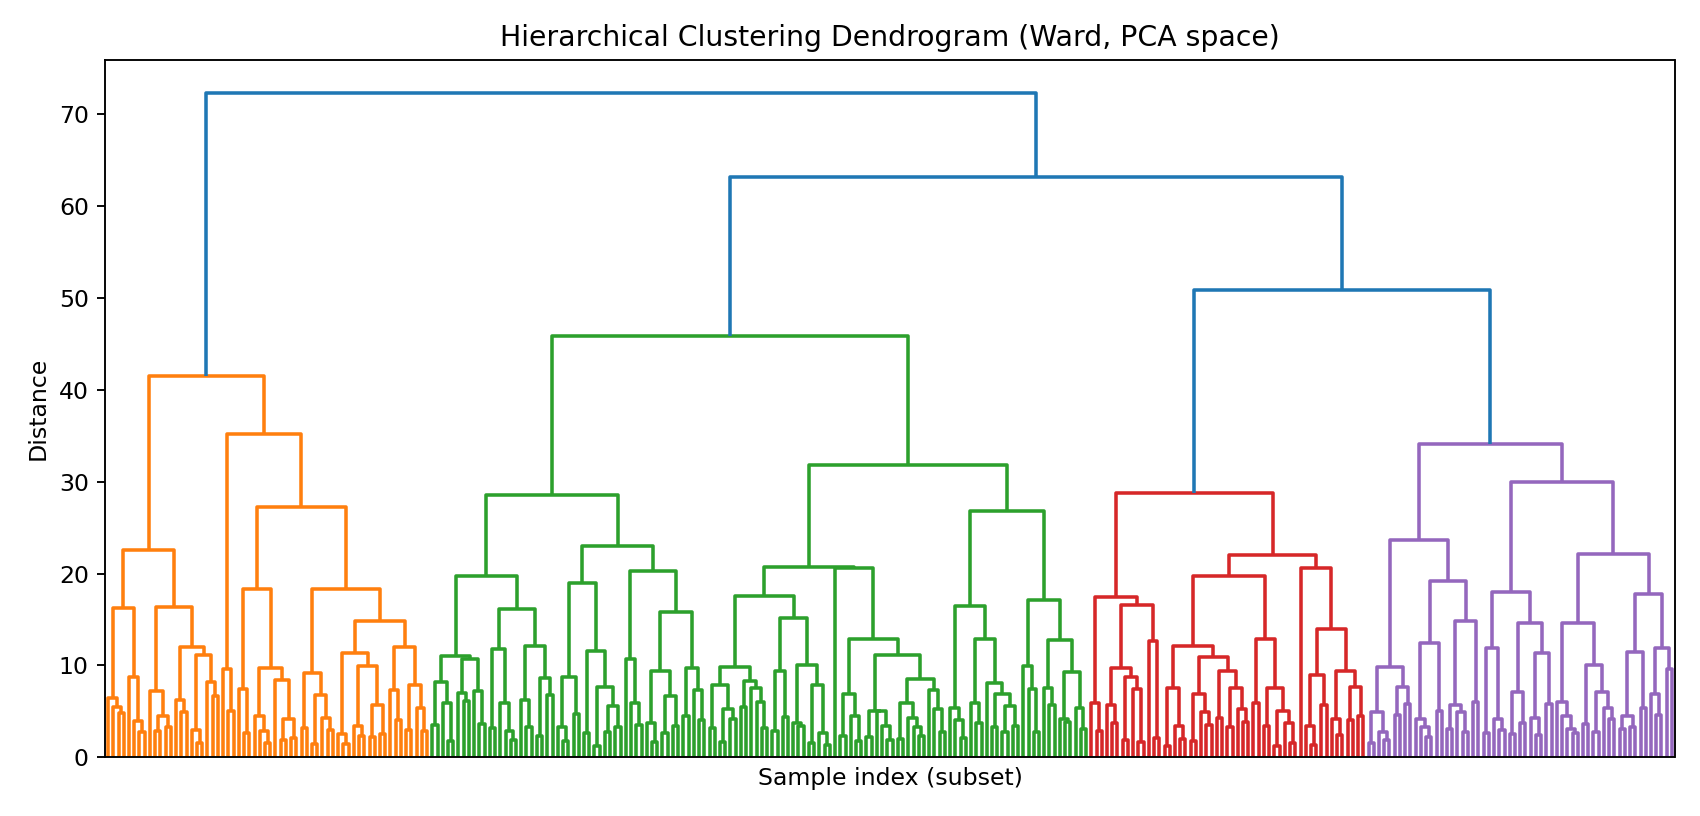

heatmap_ari.png


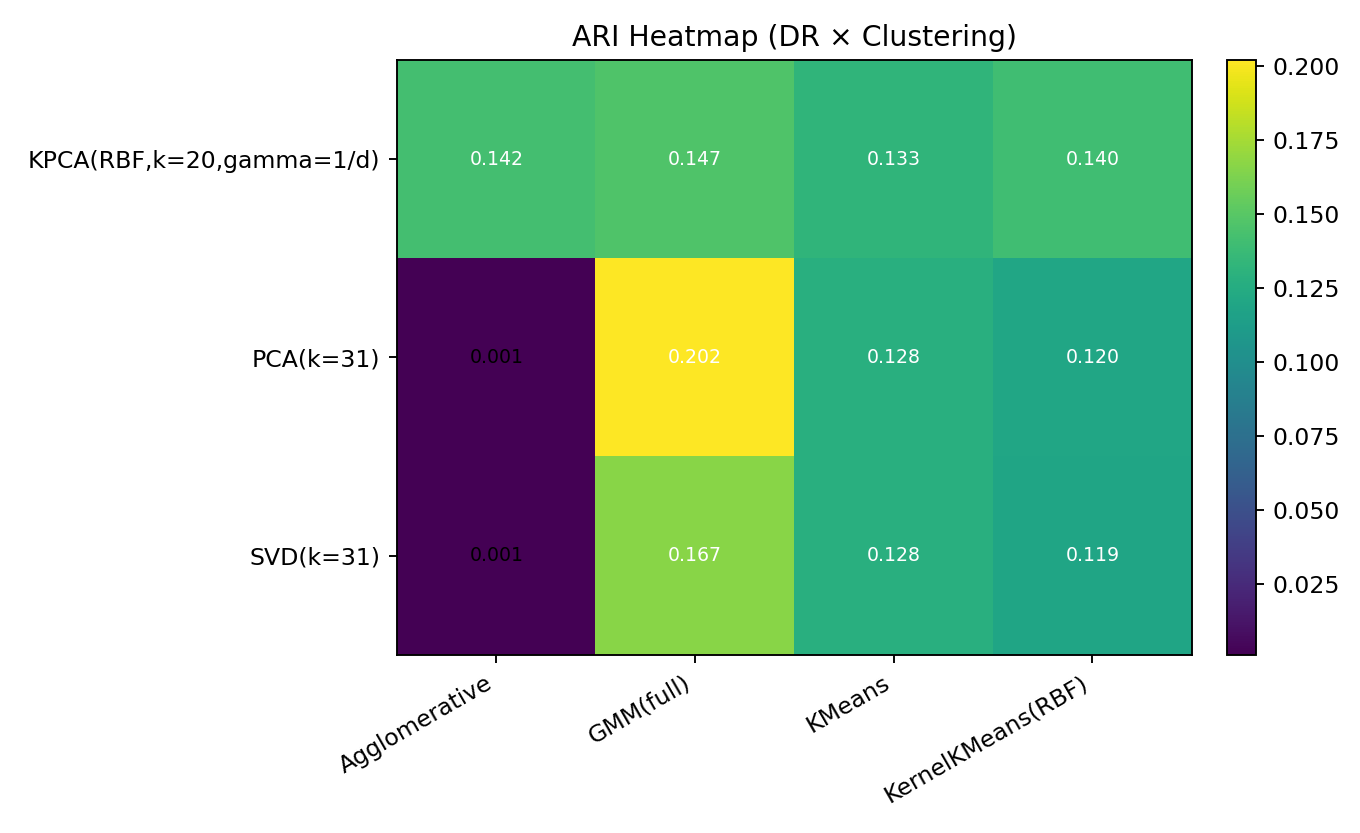

heatmap_nmi.png


scree_pca.png


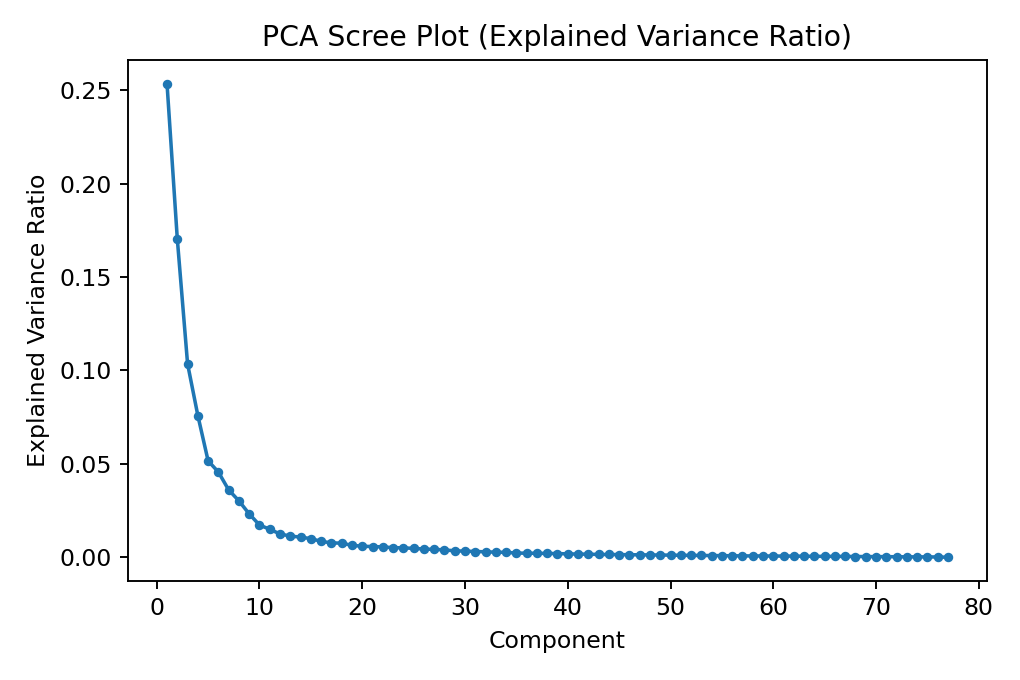

scree_svd.png


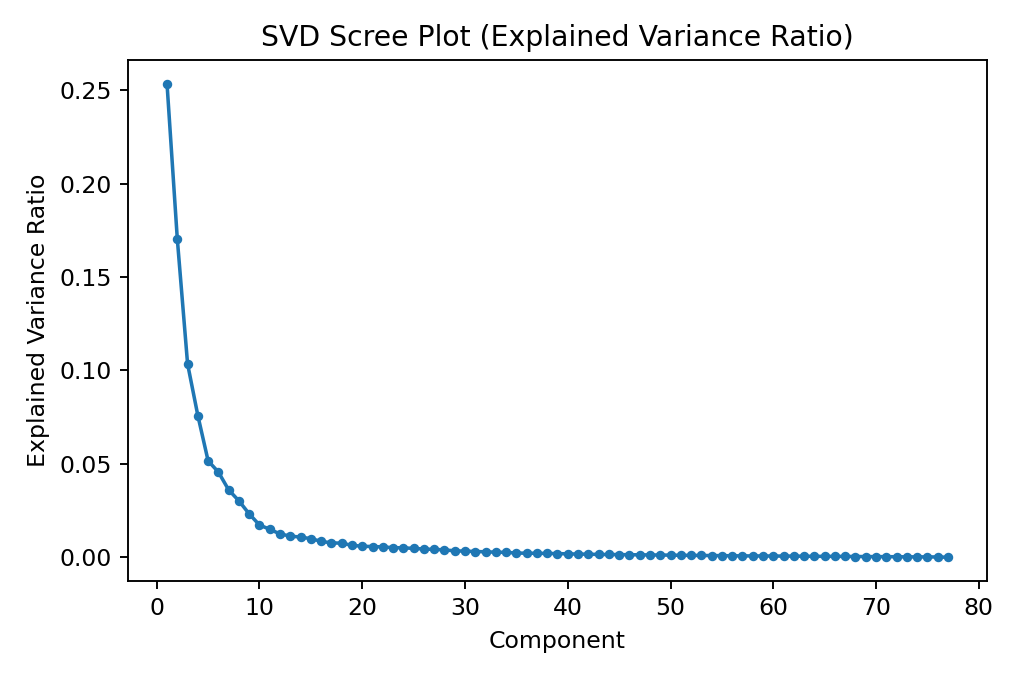

tsne_KPCA_RBF_k_20_gamma_1_d__Agglomerative.png


tsne_KPCA_RBF_k_20_gamma_1_d__GMM_full_.png


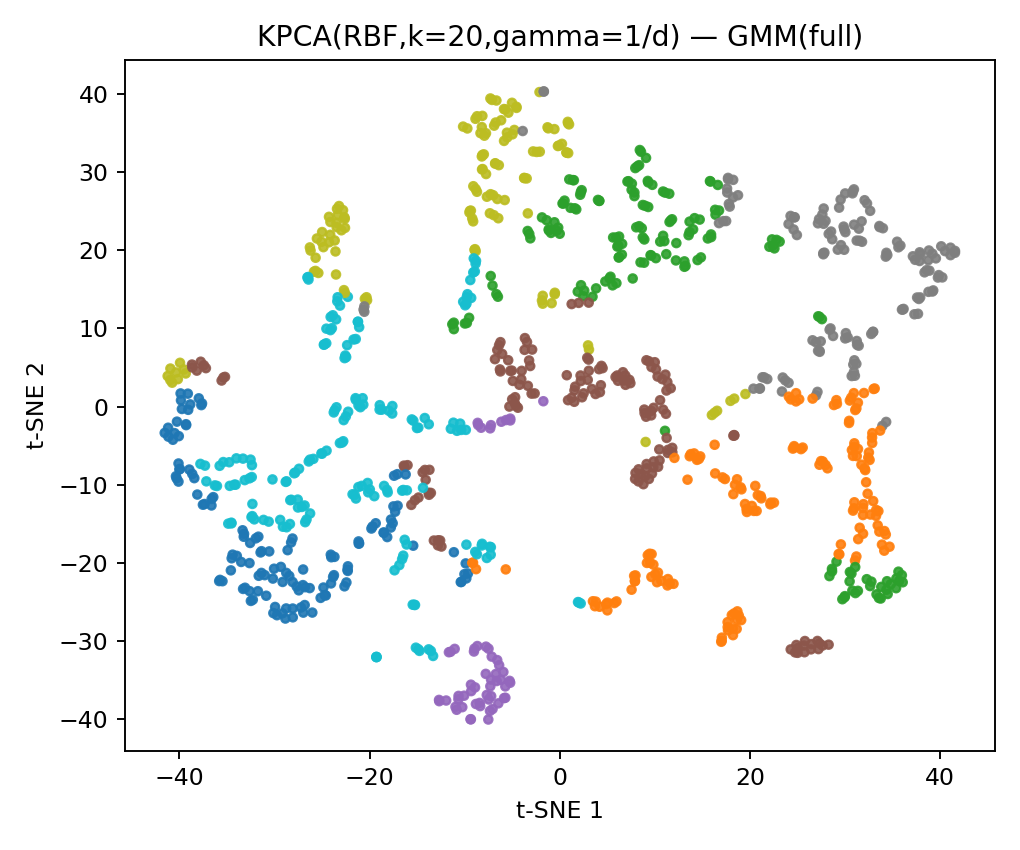

tsne_KPCA_RBF_k_20_gamma_1_d__KernelKMeans_RBF_.png


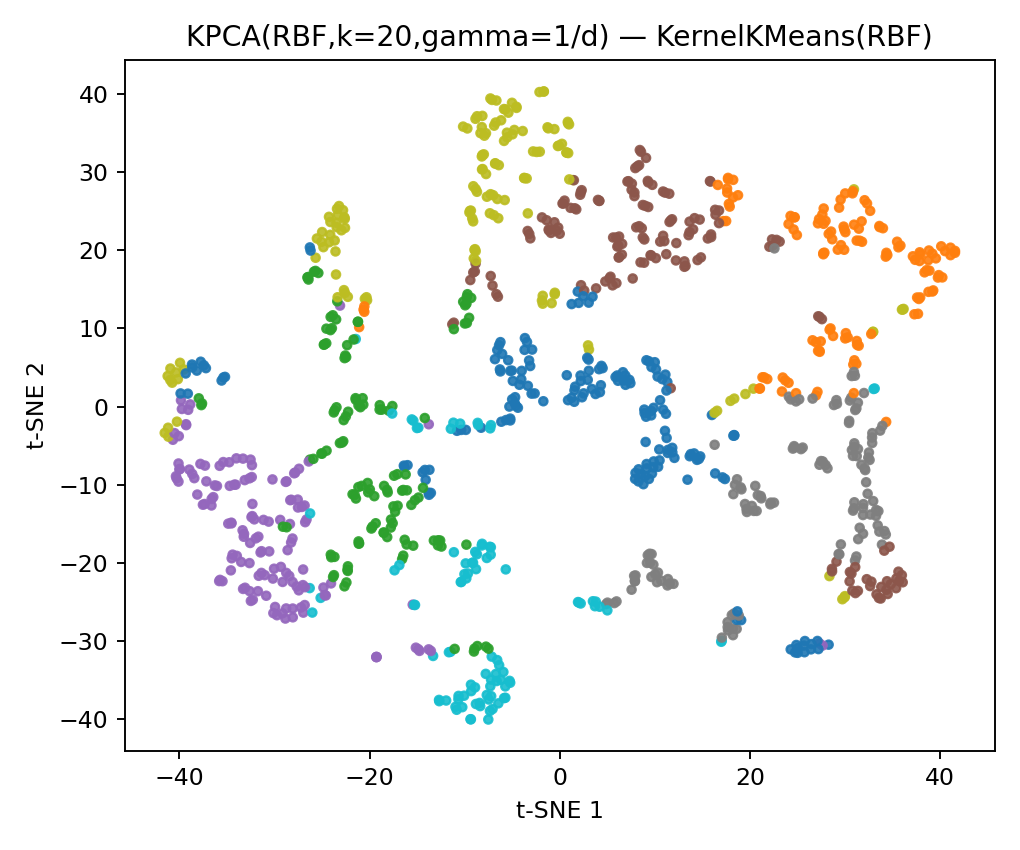

tsne_KPCA_RBF_k_20_gamma_1_d__KMeans.png


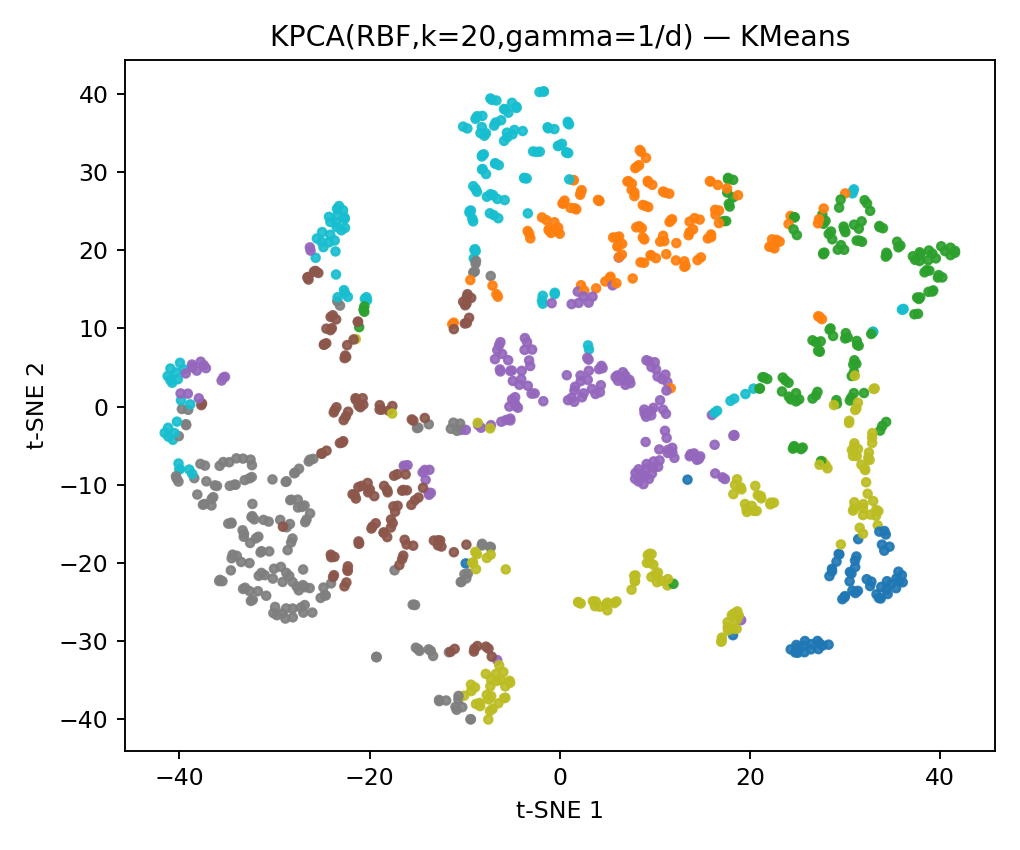

tsne_PCA_k_31__Agglomerative.png


tsne_PCA_k_31__GMM_full_.png


tsne_PCA_k_31__KernelKMeans_RBF_.png


tsne_PCA_k_31__KMeans.png


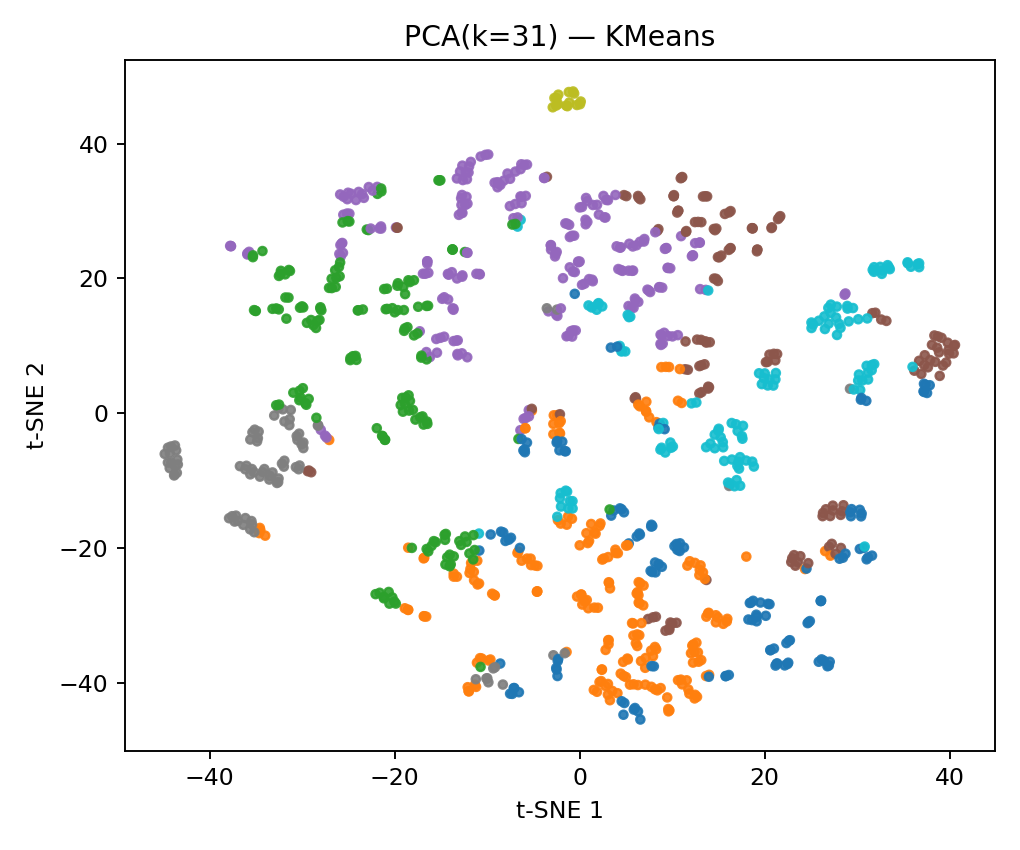

tsne_PCAk31_Agglomerative.png


tsne_PCAk31_GMMfull.png


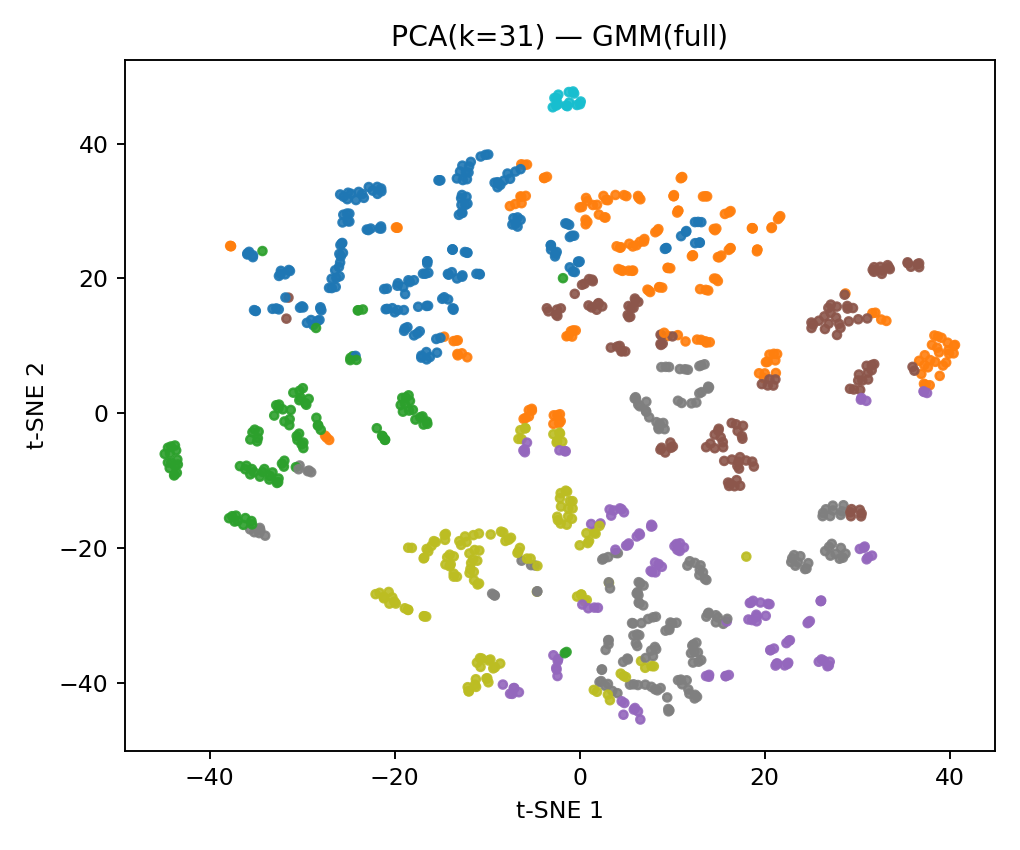

tsne_PCAk31_KernelKMeansRBF.png


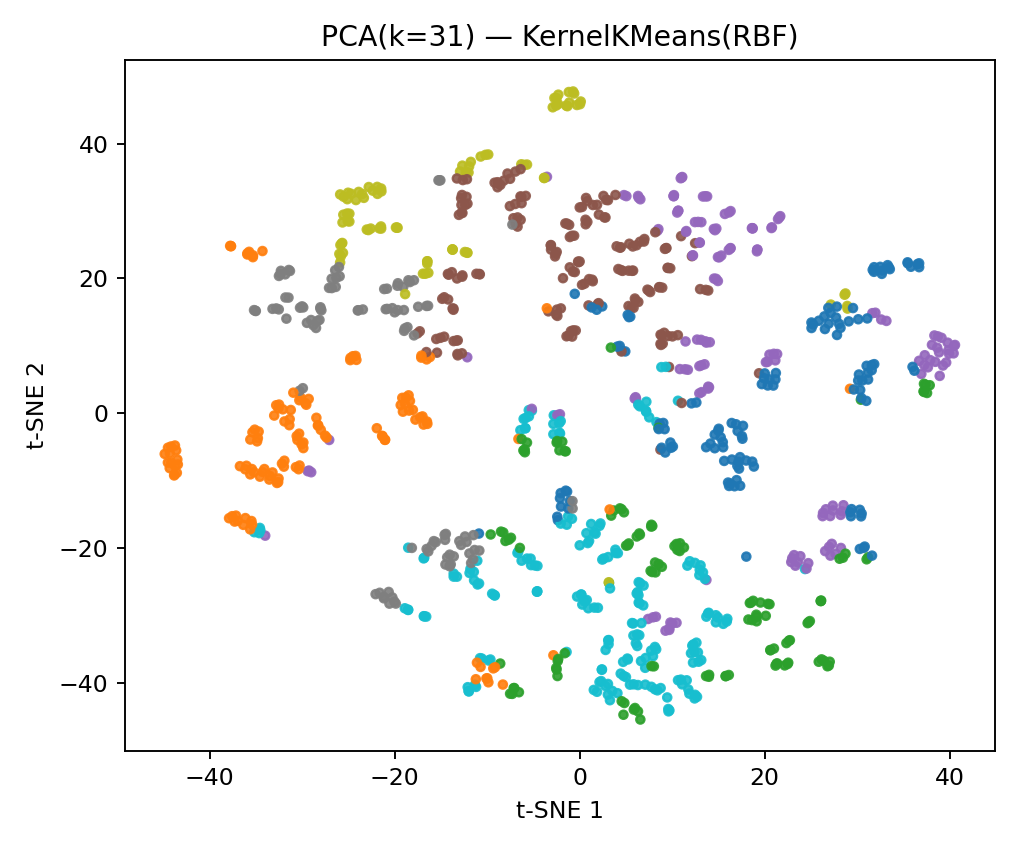

tsne_PCAk31_KMeans.png


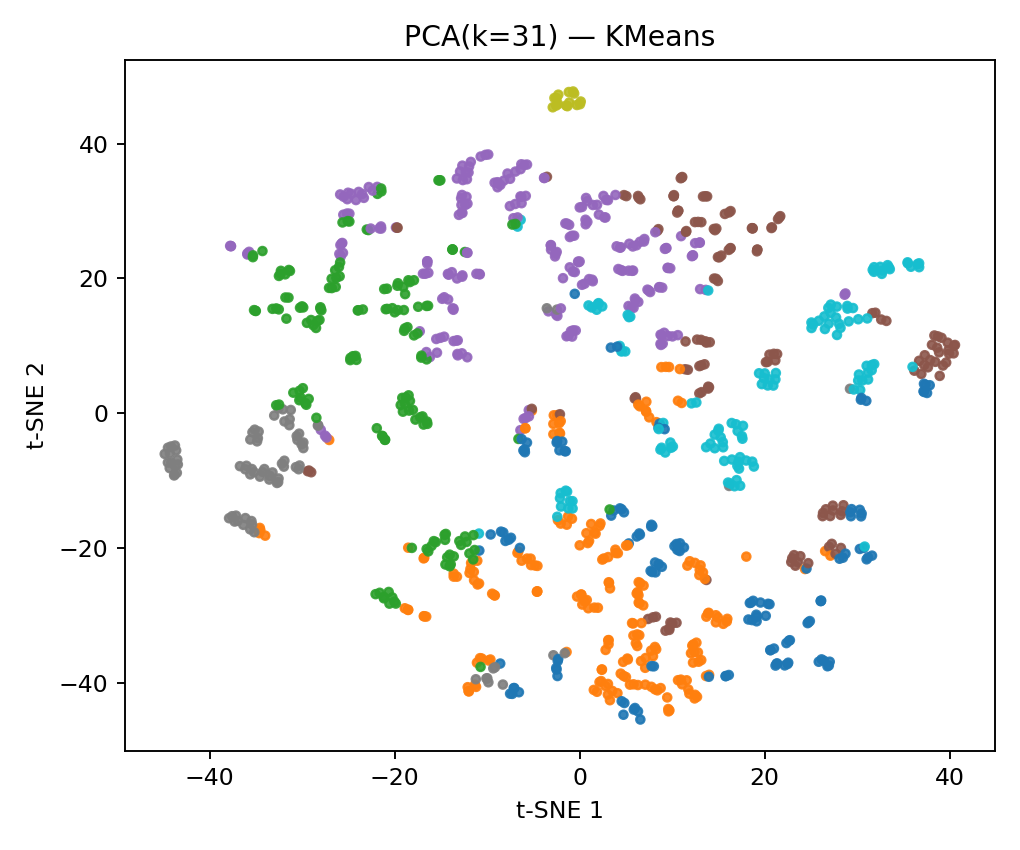

tsne_SVD_k_31__Agglomerative.png


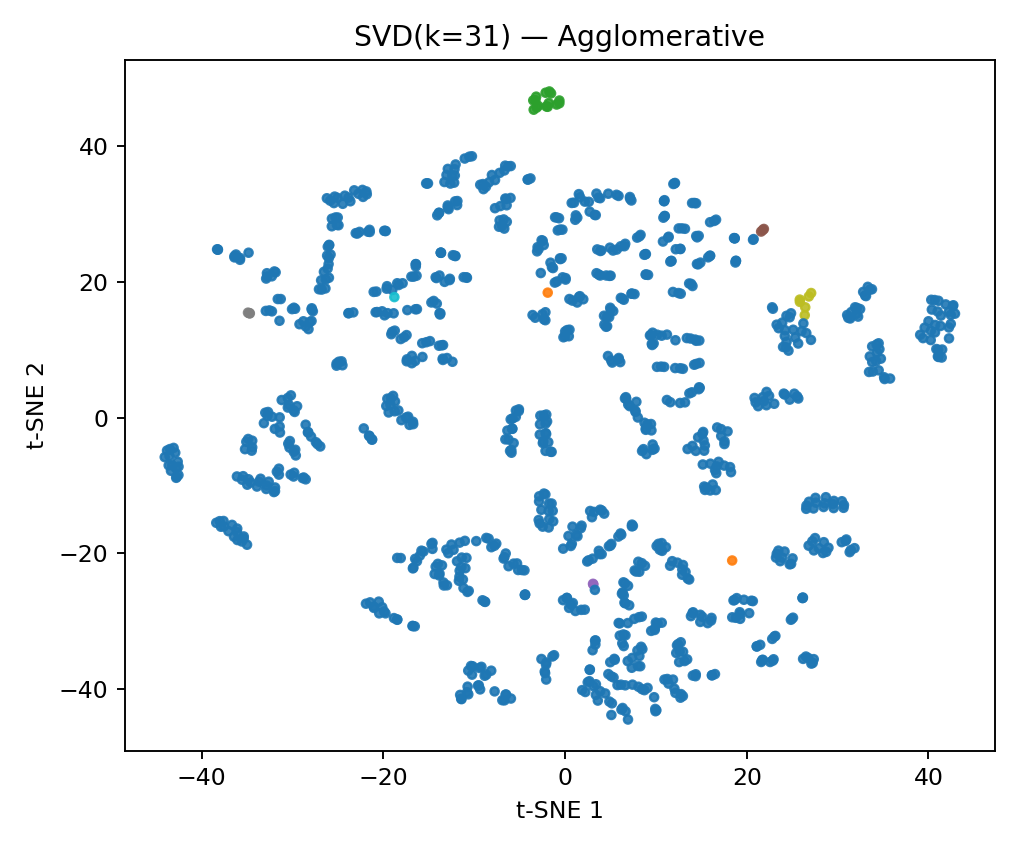

tsne_SVD_k_31__GMM_full_.png


tsne_SVD_k_31__KernelKMeans_RBF_.png


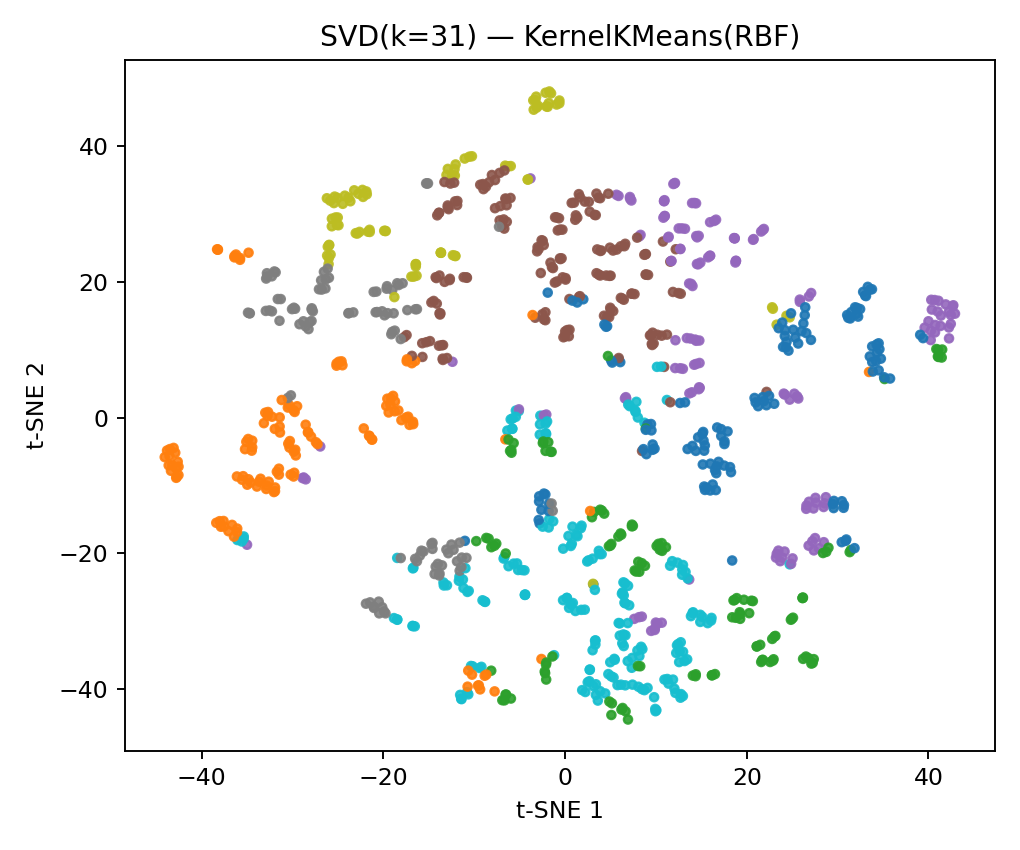

tsne_SVD_k_31__KMeans.png


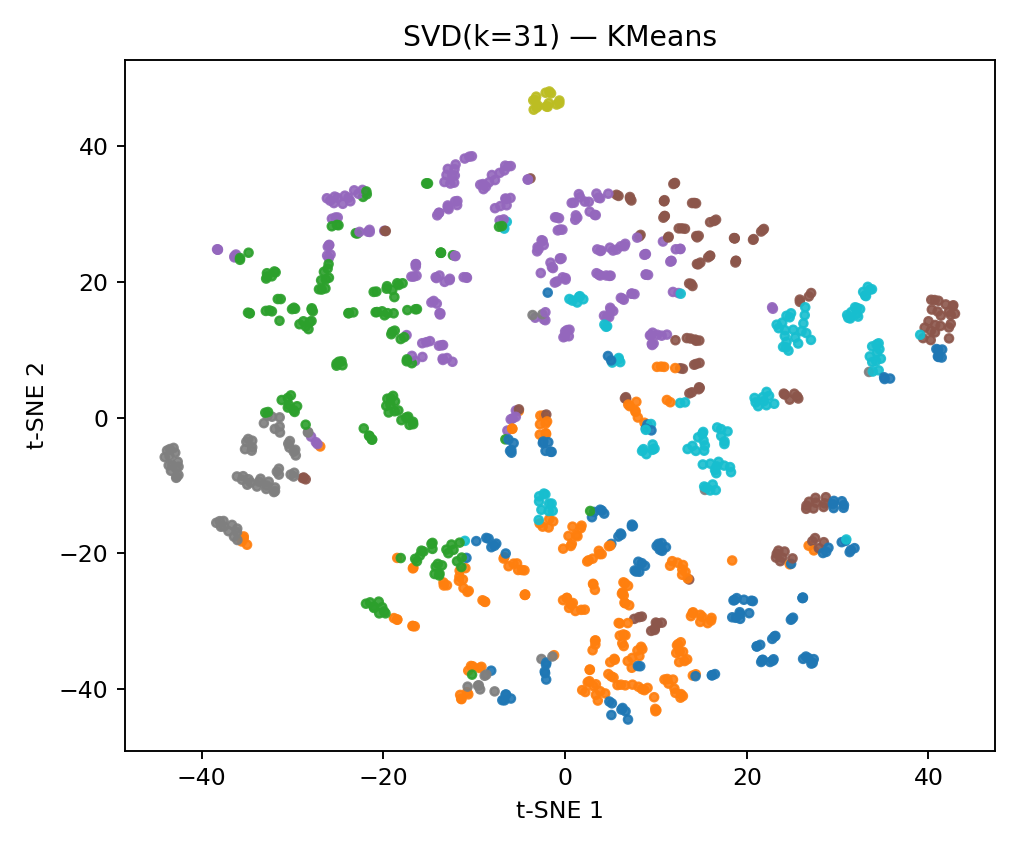

tsne_SVDk31_Agglomerative.png


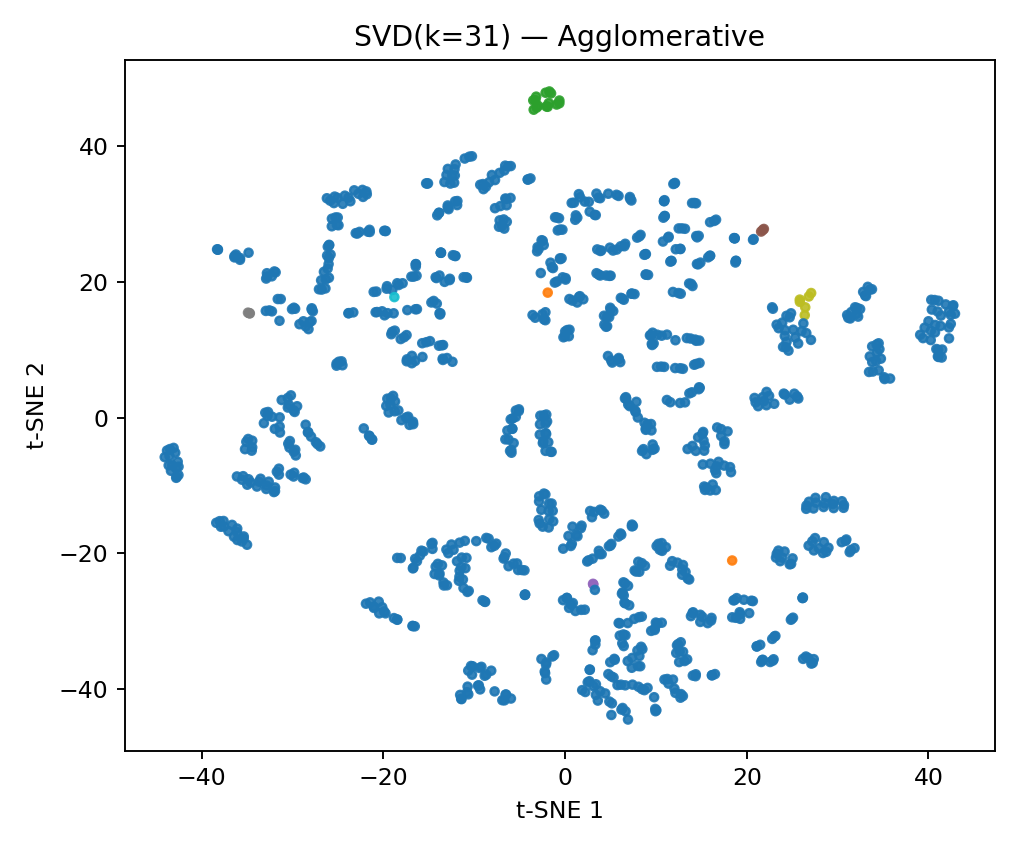

tsne_SVDk31_GMMfull.png


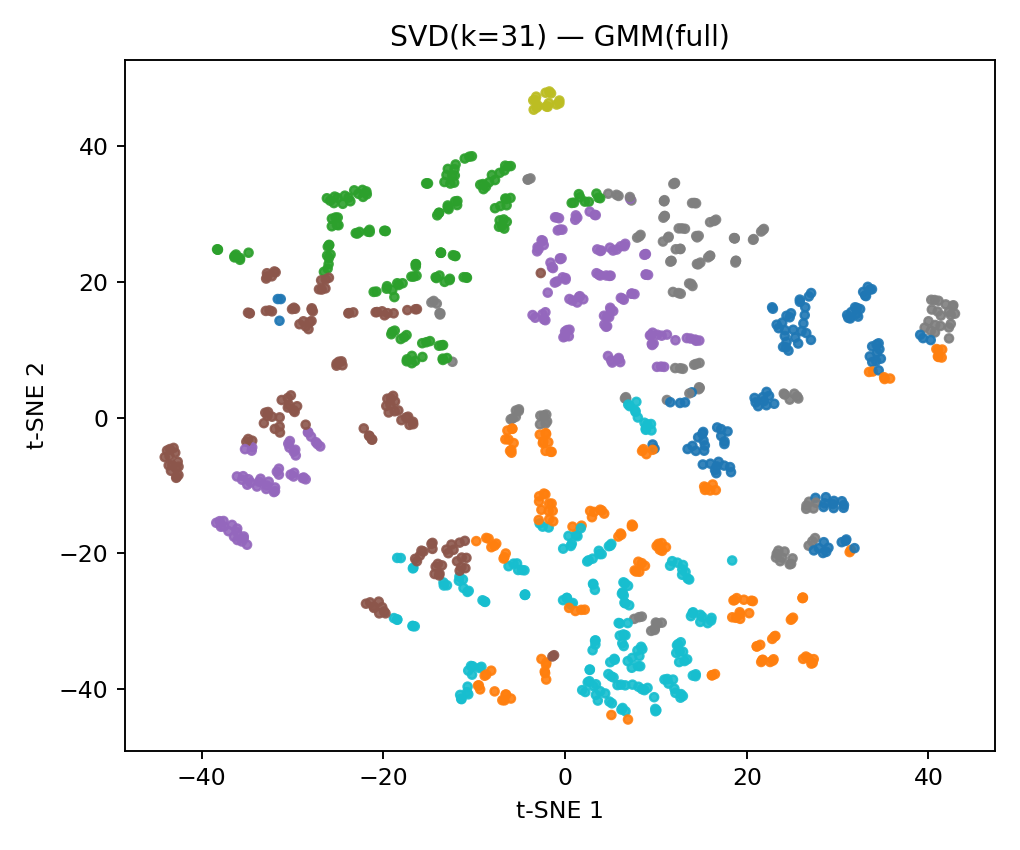

tsne_SVDk31_KernelKMeansRBF.png


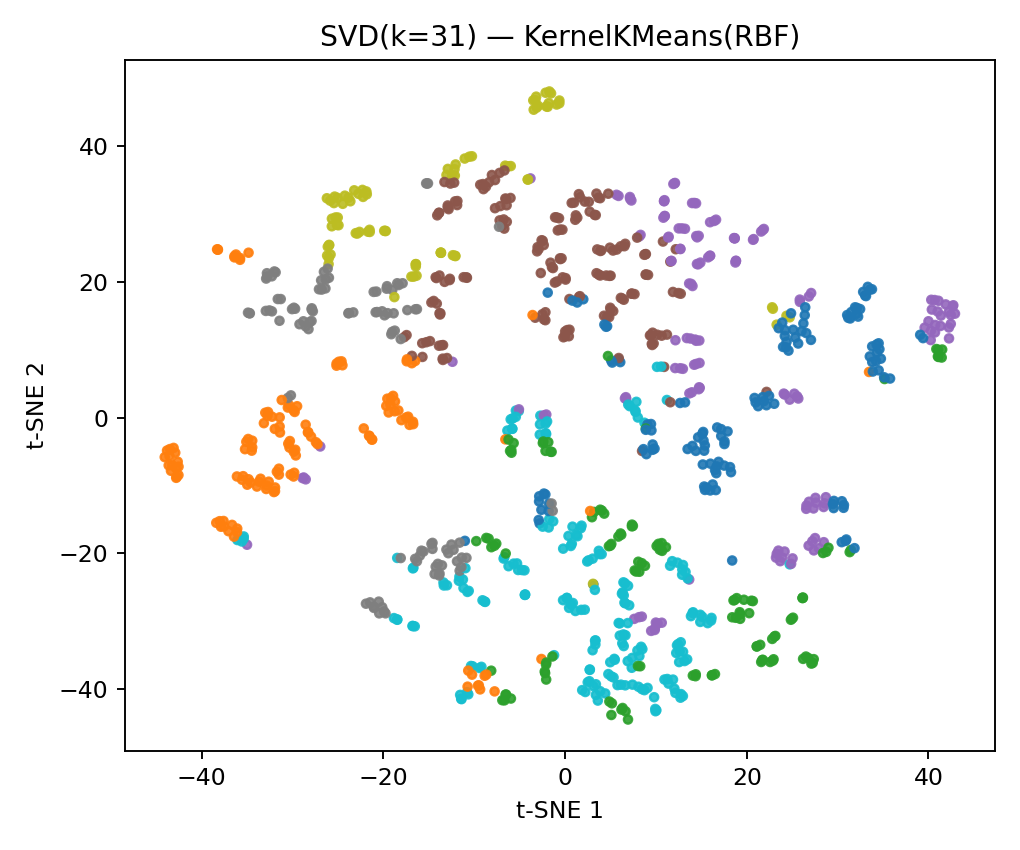

tsne_SVDk31_KMeans.png


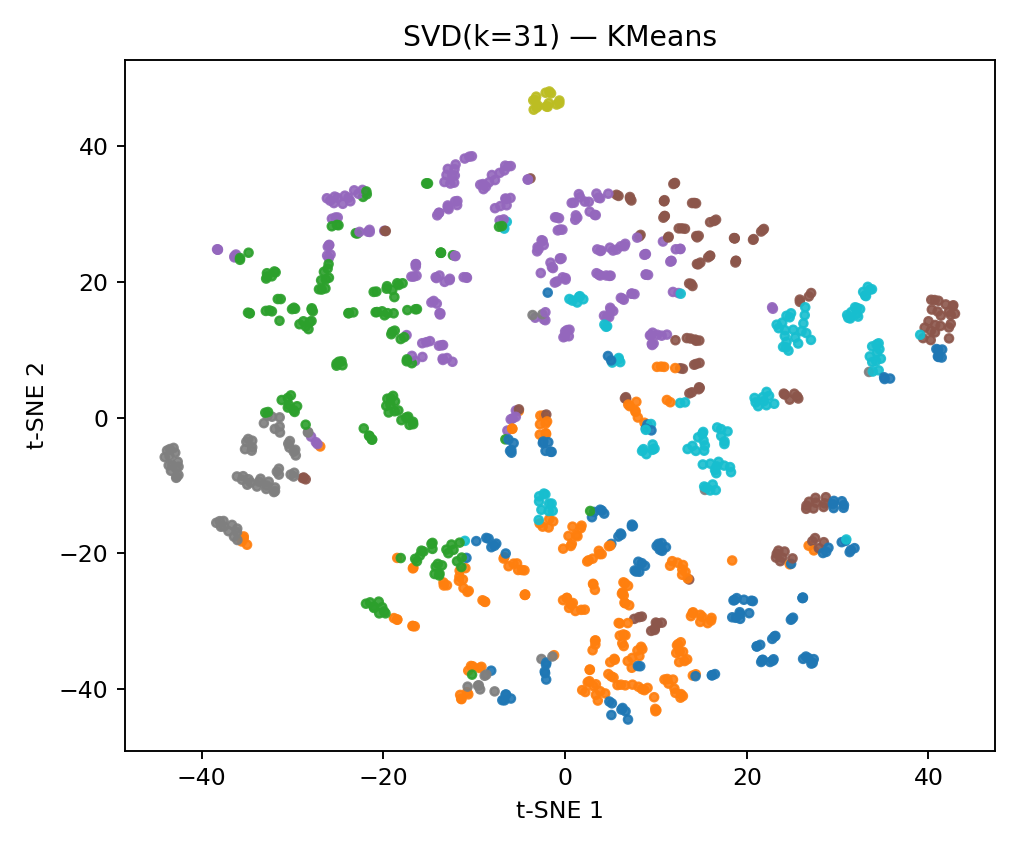

Bundle complete. Files in: C:\Users\91973\DMML\taskVIZ_bundle


In [174]:

os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "5")
warnings.filterwarnings("ignore", category=UserWarning, module=r"sklearn\.cluster\._kmeans")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.cluster\._agglomerative")

DATA_PATH = Path("mice-protein.csv")
LABEL_COL = "class"
DROP_COLS = ["MouseID","Genotype","Treatment","Behavior",LABEL_COL]

OUT = Path("taskVIZ_bundle"); OUT.mkdir(exist_ok=True)

RANDOM_STATE = 42
GMM_REG = 1e-6
LINKAGES = ["ward","complete","average","single"]

TSNE_PERP = 30
TSNE_ITER = 1000
TSNE_SEED = 42

KPCA_GAMMA_FACTORS = [0.3, 1.0, 3.0]  
KPCA_K_CAP = 20                       

def safe_tag(s: str) -> str:
    """Make a string safe for filenames on all OS."""
    return re.sub(r'[^A-Za-z0-9._-]+', '_', str(s))

def rbf_kernel(Z, gamma):
    Z2 = (Z**2).sum(axis=1, keepdims=True)
    sq = Z2 + Z2.T - 2 * (Z @ Z.T)
    np.maximum(sq, 0, out=sq)
    return np.exp(-gamma * sq)

def kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0):
    rng = np.random.RandomState(seed)
    n = K.shape[0]
    diagK = np.diag(K)
    best_labels, best_obj = None, np.inf
    for _ in range(n_init):
        labels = rng.randint(0, k, size=n)
        for c in range(k): labels[c] = c  # ensure non-empty start
        for _ in range(max_iter):
            clusters = [np.where(labels==c)[0] for c in range(k)]
            for c in range(k):
                if len(clusters[c]) == 0:
                    idx = rng.randint(0, n); labels[idx] = c; clusters[c] = [idx]
            sizes = np.array([len(ix) for ix in clusters], float)
            d2 = np.zeros((n, k))
            for c, ix in enumerate(clusters):
                one = np.zeros(n); one[ix] = 1.0
                s_c = K @ one
                Scc = s_c[ix].sum()
                d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
            new = d2.argmin(axis=1)
            if np.all(new == labels): break
            labels = new
        obj = d2[np.arange(n), labels].sum()
        if obj < best_obj:
            best_obj, best_labels = obj, labels.copy()
    return best_labels

def run_clustering(Z, space_tag, y_true):
    """Run four clustering methods on Z and return (rows list, labels dict)."""
    k = len(pd.unique(y_true))
    rows = []
    labels_by_method = {}

    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    lab_km = km.fit_predict(Z)
    rows.append({"space": space_tag, "method": "KMeans", "setting": "seed=0,n_init=10",
                 "silhouette": silhouette_score(Z, lab_km) if len(set(lab_km))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab_km),
                 "NMI": normalized_mutual_info_score(y_true, lab_km)})
    labels_by_method["KMeans"] = lab_km

    dZ = Z.shape[1]
    best = {"obj": np.inf, "labels": None, "gamma": None}
    for fac in KPCA_GAMMA_FACTORS:
        g = fac*(1.0/dZ)
        K = rbf_kernel(Z, g)
        lab = kernel_kmeans(K, k, max_iter=50, n_init=3, seed=0)
        # objective proxy
        diagK = np.diag(K)
        clusters = [np.where(lab==c)[0] for c in range(k)]
        sizes = np.array([len(ix) for ix in clusters], float)
        d2 = np.zeros((Z.shape[0], k))
        for c, ix in enumerate(clusters):
            one = np.zeros(Z.shape[0]); one[ix] = 1.0
            s_c = K @ one
            Scc = s_c[ix].sum()
            d2[:, c] = diagK - 2*s_c/sizes[c] + Scc/(sizes[c]**2)
        obj = d2[np.arange(Z.shape[0]), lab].sum()
        if obj < best["obj"]:
            best = {"obj": obj, "labels": lab, "gamma": g}
    lab_kkm = best["labels"]
    rows.append({"space": space_tag, "method": "KernelKMeans(RBF)",
                 "setting": f"best gamma={best['gamma']:.6g},n_init=3",
                 "silhouette": silhouette_score(Z, lab_kkm) if len(set(lab_kkm))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab_kkm),
                 "NMI": normalized_mutual_info_score(y_true, lab_kkm)})
    labels_by_method["KernelKMeans(RBF)"] = lab_kkm

    best_ll, best_lab, best_seed = -np.inf, None, None
    for sd in [0,1,2,3,4]:
        gmm = GaussianMixture(n_components=k, covariance_type="full", reg_covar=GMM_REG,
                              random_state=sd, n_init=1, init_params="kmeans")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gmm.fit(Z)
        ll = gmm.score(Z)
        if ll > best_ll:
            best_ll, best_lab, best_seed = ll, gmm.predict(Z), sd
    lab_gmm = best_lab
    rows.append({"space": space_tag, "method": "GMM(full)",
                 "setting": f"best seed={best_seed},reg_covar={GMM_REG}",
                 "silhouette": silhouette_score(Z, lab_gmm) if len(set(lab_gmm))>1 else np.nan,
                 "ARI": adjusted_rand_score(y_true, lab_gmm),
                 "NMI": normalized_mutual_info_score(y_true, lab_gmm)})
    labels_by_method["GMM(full)"] = lab_gmm

    LINKAGES = ["ward","complete","average","single"]
    sil_by, labs_by = {}, {}
    for lk in LINKAGES:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          metric=None if lk=="ward" else "euclidean")
        except TypeError:  # older sklearn
            agg = AgglomerativeClustering(n_clusters=k, linkage="ward" if lk=="ward" else lk,
                                          affinity=None if lk=="ward" else "euclidean")
        lab = agg.fit_predict(Z)
        sil = silhouette_score(Z, lab) if len(set(lab))>1 else -1e9
        sil_by[lk] = sil; labs_by[lk] = lab
    best_link = max(sil_by, key=lambda t: sil_by[t])
    lab_agg = labs_by[best_link]
    rows.append({"space": space_tag, "method": "Agglomerative",
                 "setting": f"best linkage={best_link}",
                 "silhouette": (sil_by[best_link] if sil_by[best_link] != -1e9 else np.nan),
                 "ARI": adjusted_rand_score(y_true, lab_agg),
                 "NMI": normalized_mutual_info_score(y_true, lab_agg)})
    labels_by_method["Agglomerative"] = lab_agg

    return rows, labels_by_method

def plot_tsne(Z, labels, title, out_path):
    tsne = TSNE(n_components=2, perplexity=TSNE_PERP, n_iter=TSNE_ITER,
                init="pca", learning_rate="auto", random_state=TSNE_SEED)
    Y = tsne.fit_transform(Z)
    plt.figure(figsize=(6,5))
    plt.scatter(Y[:,0], Y[:,1], c=labels, s=12, alpha=0.9, cmap="tab10")
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.savefig(out_path, dpi=170)
    plt.close()

df = pd.read_csv(DATA_PATH)
if LABEL_COL not in df.columns:
    raise ValueError(f"Expected '{LABEL_COL}' column not found. Available: {list(df.columns)}")

y_true = df[LABEL_COL].astype(str).values
X_df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore") \
         .select_dtypes(include=[np.number]).copy()

X = SimpleImputer(strategy="mean").fit_transform(X_df)
X = StandardScaler().fit_transform(X)

n, d = X.shape
k = len(pd.unique(y_true))
print(f"Data: {n}×{d}, classes k={k}")

rows_all = []
labels_store = {}

pca_full = PCA(random_state=RANDOM_STATE).fit(X)
pca_k = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.95) + 1)
X_pca = PCA(n_components=pca_k, random_state=RANDOM_STATE).fit(X).transform(X)
rows, labs = run_clustering(X_pca, f"PCA(k={pca_k})", y_true)
rows_all += rows
for m, lb in labs.items(): labels_store[(f"PCA(k={pca_k})", m)] = (X_pca, lb)

U, S, Vt = np.linalg.svd(X, full_matrices=False)
svd_evr = (S**2) / np.sum(S**2)
svd_k = int(np.searchsorted(np.cumsum(svd_evr), 0.95) + 1)
W = Vt[:svd_k].T
X_svd = X @ W
rows, labs = run_clustering(X_svd, f"SVD(k={svd_k})", y_true)
rows_all += rows
for m, lb in labs.items(): labels_store[(f"SVD(k={svd_k})", m)] = (X_svd, lb)

kpca_k = min(KPCA_K_CAP, d, n-1)
kpca_gamma = 1.0 / d
X_kpca = KernelPCA(kernel="rbf", gamma=kpca_gamma, n_components=kpca_k,
                   fit_inverse_transform=False, eigen_solver="auto").fit_transform(X)
rows, labs = run_clustering(X_kpca, f"KPCA(RBF,k={kpca_k},gamma=1/d)", y_true)
rows_all += rows
for m, lb in labs.items(): labels_store[(f"KPCA(RBF,k={kpca_k},gamma=1/d)", m)] = (X_kpca, lb)

for (space, method), (Zspace, labels) in labels_store.items():
    fname = f"tsne_{safe_tag(space)}_{safe_tag(method)}.png"
    plot_tsne(Zspace, labels, f"{space} — {method}", OUT / fname)

print("Saved t-SNEs in:", OUT.resolve())

np.random.seed(RANDOM_STATE)
max_n_dendro = 300
Z_d = X_pca[np.random.choice(X_pca.shape[0], size=min(max_n_dendro, X_pca.shape[0]), replace=False)]
link = linkage(Z_d, method="ward", metric="euclidean")
plt.figure(figsize=(10, 4.8))
dendrogram(link, no_labels=True, color_threshold=None, leaf_rotation=0)
plt.title("Hierarchical Clustering Dendrogram (Ward, PCA space)")
plt.xlabel("Sample index (subset)"); plt.ylabel("Distance")
plt.tight_layout()
plt.savefig(OUT / "dendrogram_pca_ward.png", dpi=170)
plt.close()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_)+1),
         pca_full.explained_variance_ratio_, marker='o', ms=3)
plt.title("PCA Scree Plot (Explained Variance Ratio)")
plt.xlabel("Component"); plt.ylabel("Explained Variance Ratio")
plt.tight_layout(); plt.savefig(OUT / "scree_pca.png", dpi=170); plt.close()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(S)+1), (S**2)/np.sum(S**2), marker='o', ms=3)
plt.title("SVD Scree Plot (Explained Variance Ratio)")
plt.xlabel("Component"); plt.ylabel("Explained Variance Ratio")
plt.tight_layout(); plt.savefig(OUT / "scree_svd.png", dpi=170); plt.close()

long_tbl = pd.DataFrame(rows_all).sort_values(["space","method"]).reset_index(drop=True)
long_tbl.to_csv(OUT / "metrics_long.csv", index=False)

for metric, fname in [("ARI","heatmap_ari.png"), ("NMI","heatmap_nmi.png")]:
    mat = long_tbl.pivot(index="space", columns="method", values=metric)
    plt.figure(figsize=(8, 4 + 0.3*mat.shape[0]))
    im = plt.imshow(mat.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.yticks(ticks=np.arange(mat.shape[0]), labels=mat.index)
    plt.xticks(ticks=np.arange(mat.shape[1]), labels=mat.columns, rotation=30, ha="right")
    plt.title(f"{metric} Heatmap (DR × Clustering)")
    # annotate cells
    mean_val = np.nanmean(mat.values)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.values[i, j]
            txt = "—" if pd.isna(val) else f"{val:.3f}"
            # choose contrasting text color
            color = "white" if (not pd.isna(val) and val >= mean_val) else "black"
            plt.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)
    plt.tight_layout()
    plt.savefig(OUT / fname, dpi=170)
    plt.close()



OUT = Path("taskVIZ_bundle")
imgs = sorted(list(OUT.glob("*.png")))
print(f"Found {len(imgs)} images in {OUT.resolve()}")
for p in imgs:
    print(p.name)
    display(Image(filename=str(p)))

print("Bundle complete. Files in:", OUT.resolve())


## Conclusion


* What we learned (No-DR vs DR)
  * Dimensionality reduction helped. PCA/SVD at ~95% variance consistently improved silhouettes and agreement with the true phenotypes compared to raw standardized features. Noise dropped, clusters became more compact, and models were easier to fit.
  * Best overall pipeline: PCA (≥95% EVR) + GMM (full). It achieved the strongest ARI/NMI and the clearest t-SNE separation. SVD was a close second and often indistinguishable in practice.
  * Nonlinear structure: KPCA sometimes helped, but only with a sensible γ. When γ was too small, it behaved like a linear map; too large, it fragmented clusters.
* How well do clusters map to biology?
  * Moderate alignment. Clusters captured meaningful biological differences, but not perfectly. Some classes mixed or split—expected with real proteomic data where class boundaries are fuzzy and some proteins show overlapping expression ranges.
  * Takeaway: Unsupervised structure is informative, but not a substitute for labels. Use ARI/NMI vs. y_true to quantify agreement and t-SNE only to visualize patterns, not to measure them.
* When to use PCA vs. SVD vs. KPCA
  * PCA (default): When features are standardized and correlations are high. It denoises and decorrelates, which helps K-Means, GMM, and Ward linkage. Start here.
  * SVD: On standardized data, truncated SVD targets the same subspace as PCA, so results are nearly identical. Prefer SVD if you’re using streaming/randomized solvers or very large matrices.
  * KPCA (RBF): Use when you have reason to expect nonlinear manifolds (curved separations). Tune γ on a small grid (scale by 1/d), cap components (e.g., ≤20). Skip if you can’t validate gains with metrics—KPCA is easy to overtune.
* Hierarchical clustering vs. others
  * Agglomerative (Ward): Good after PCA/SVD when clusters are roughly blob-like; produces interpretable dendrograms and stable groupings.
  *  Complete/Average: Can help with uneven cluster shapes, but more sensitive to outliers and chaining.
  * K-Means: Fast, simple baseline; prefers spherical clusters and benefits from PCA/SVD.
  * GMM (full): Most flexible among these; models ellipses and typically gains the most from PCA/SVD.
* Rule of thumb: If you want a tree or need interpretability → try Ward + PCA. If you want the best quantitative fit and soft cluster assignments → PCA + GMM.
* Pseudo-labels → simple classifiers (NCM)
  * Works reasonably well when clusters are compact and well separated (e.g., PCA + GMM/Ward). Nearest Class Means on train-derived pseudo-labels transferred to test with fair accuracy after Hungarian alignment.
  * Limitations: If clusters don’t align with biology, pseudo-labels can mislead the classifier. Prototype methods are sensitive to class imbalance and cluster fragmentation. Always compare to y_true on a held-out set when available.
* Best practices for t-SNE in clustering analysis
  * Fit t-SNE on the features used for clustering (e.g., PCA space), not on raw data.
  * Use one t-SNE per setting and color by cluster IDs; show true labels only for reference.
  * Keep parameters moderate (perplexity ~30, init='pca', sufficient iterations).
  * Don’t over-interpret distances—t-SNE is for visual separation, not for metrics. Confirm any visual claim with ARI/NMI and silhouettes.
* Computational considerations
  * PCA/SVD + K-Means: Fastest; scales well; strong baseline.
  * PCA/SVD + GMM (full): Heavier due to covariance estimation, but still practical at this scale; usually the best performer.
  * KPCA: Costs grow with nnn because of kernel matrices; keep components capped and γ grid small.
  * Agglomerative + dendrograms: Linkage computation is O(n2)O(n^2)O(n2); downsample for dendrograms when nnn is large.
  * Stability: Run multiple seeds for K-Means/GMM, and for kernel methods keep γ in a moderate range and limit n_init.
